<a href="https://colab.research.google.com/github/shaanbarca/graduation_project/blob/main/GP2_eda_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The government of Indonesia has launched an initiative called Satu Data Indonesia (SDI) to consolidate data, increase data quality, and access central and local government data. The objectives of the program in its own words are to increase transparency and accountability of the government and help the development of the nation. By leveraging machine learning, we can help realize the goals of the program to help policymakers make data-driven decisions. Badan Pusat Statistik (BPS) Indonesia is a government bureau that collects, surveys, and analyzes data for the government. They are the main entities that provide statistical analysis to help decision-makers to make data-driven policies.  


## Current situation



The primary focus of the BPS is on sampling or data acquisition and not data analysis. While some data analysis is done, most government ministries, agencies and other forms of organizations need to conduct the analysis independently. As the analysis is being conducted individually, there is yet to be a standardized way to clean, visualize, understand and evaluate the results of their analysis. 


## What does this notebook hope to address 

Previous studies on (ML) for public policy in Indonesia have largely focused on prediction/forecasting [4]. Certain implemented models were also “blackbox” methods (Section 2), where the results were not interpretable.  For this application, policymakers must not only have predictions of future forecasts but also reasoning on how the predictions were derived. While prediction is certainly an important component, it is also important to identify the levers that influence such outcomes. For example, if a model is developed to accurately predict the hospitalization rate in a particular area, we must also know what factors such outcomes are and how to mitigate it. Thus, in this domain, we must not only employ models, but also ensure that they are interpretable. 
Research has been published on the use of interpretable models in Indonesia. They employed Causal Forest, an ML-based model for Indonesian public healthcare that identifies causal variables [8]. While this was able to successfully derive causal factors, the emphasis on the papers was largely on singular modeling rather than a diverse approach.  Situations related to public policy are often multifaceted problems that require a diverse approach to derive an understanding from different perspectives. Recognizing the use of multiple approaches is something that also needs to be further explored.

Finally, there is a lack of emphasis on understanding visualized data in the current literature. Descriptive statistics are typically included but however with current frameworks used in Data Science, “Explanatory Data Analysis” (section 3) goes beyond just looking at the mean, mode, median and deviation etc. in tabular mode. Different types of visualizations are needed to understand the variables involved and to fully grasp the situation. It also helps us to decide which models are the most ideal for the dataset.  

This notebooks aims to serve as a framework for Data science applications for public policy in Indonesia. Specifically, it addresses the main gaps in the current literature by employing data explanatory techniques (1), using an ensemble of models (2) methods to make them interpretable (3), and translating its results to actionable policy recommendations (4). Additionally, it also discusses the end-user’s involvement in every stage and the limitations of ML to avoid negligent use (5). 
To fully illustrate this, we analyze the gross regional product (GRP) of each province in Indonesia. The GRP is similar to the gross domestic product but is limited to a province rather than the whole country.  The objective of the analysis is to identify the variables that contribute to a province’s GRP and the actions policymakers can take to increase their GRP.
An extensive list of variables are included, such as geographical location, climate, level of education, and infrastructure to name a few. These variables were represented as continuous, categorical, ordinal, and spatial values. 
Dealing with such a diverse dataset allows demonstrations of  how machine learning can be used in public policy. Because the Satu Data Indonesia initiative is still ongoing, the dataset used may not be fully accurate. Thus, the model interpretations and policy recommendations made in this study serve only as an example and to illustrate the framework.


In [ ]:
#!pip install dataprep

In [ ]:
#from dataprep.eda import create_report
#!pip install geopandas

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 14.9 MB/s 


https://www.kemenkeu.go.id/publikasi/artikel-dan-opini/memahami-dana-transfer-ke-daerah-dan-dana-desa/

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
import seaborn as sns
from matplotlib import rcParams
from google.colab import drive
#import geopandas as gpd
#----------------------- Data analysis libs

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix


#-------------- We want to set the figure size here 
sns.set(rc={'figure.figsize':(20,10)})
plt.style.use(
    "https://github.com/aeturrell/coding-for-economists/raw/main/plot_style.txt"
)
rcParams['figure.figsize'] = 20,10

#----------------- Pandas settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Goal

## Regression analysis on what factors affect a city/regency's income

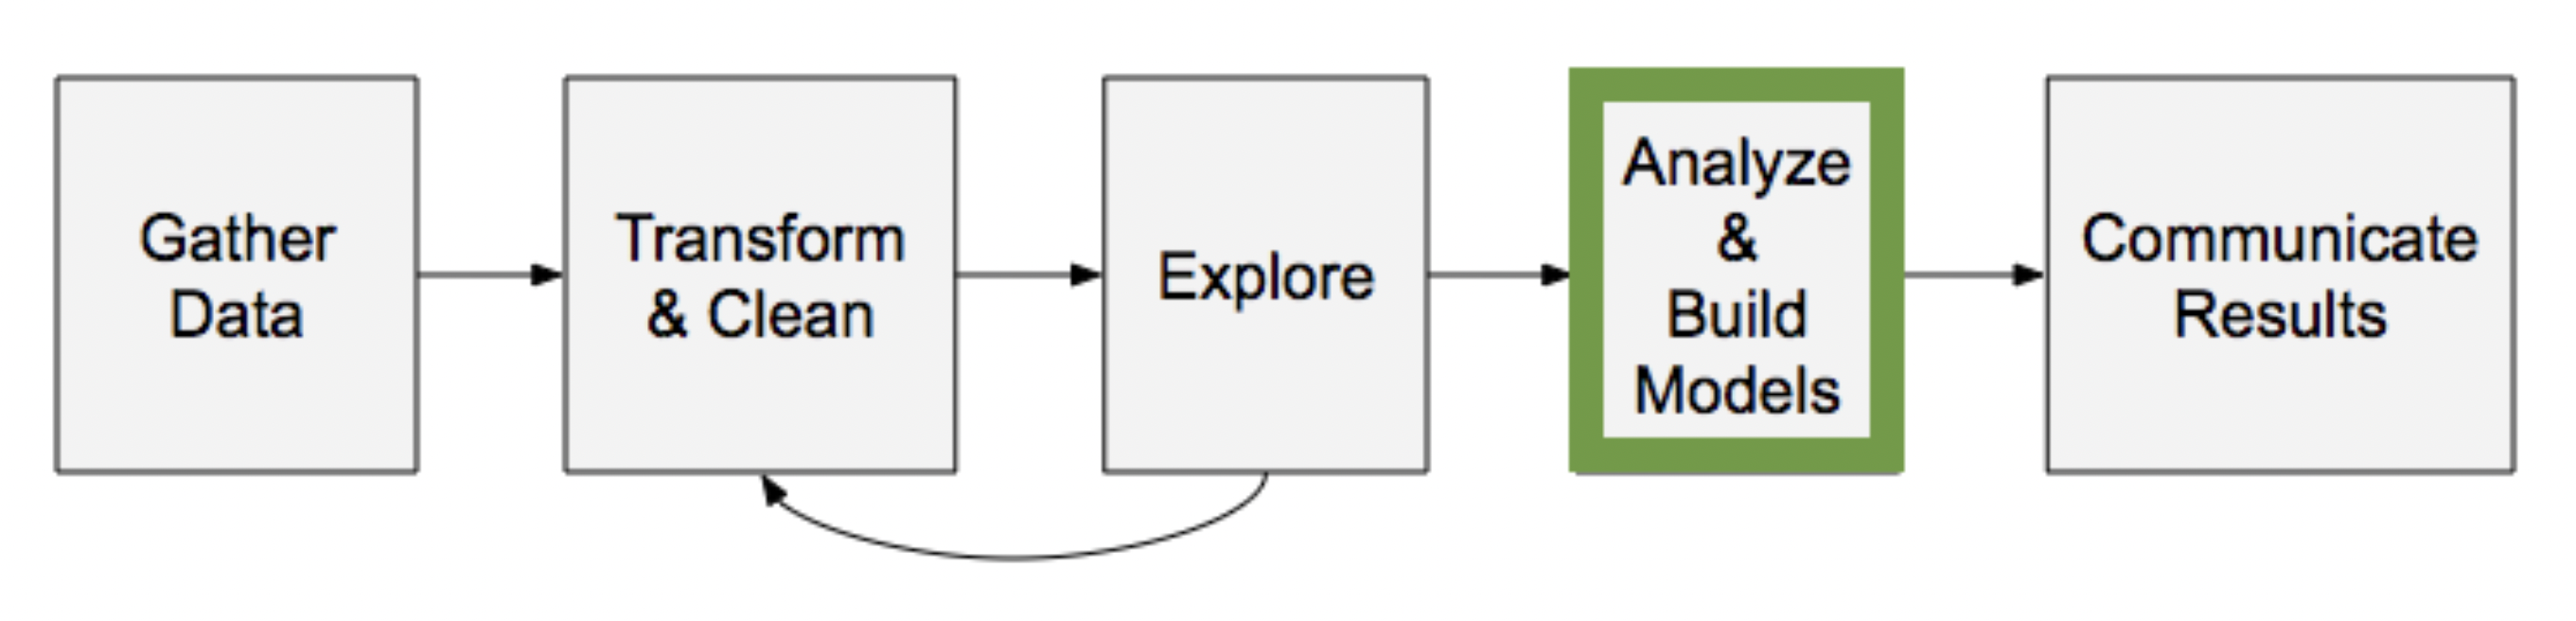

# Load clean dataset.

Data was partially pre-proccessed to shorten the length of the notebook. For detailed explanations/code of steps taken to preproccessed they can be viewed in a seperate notebook here [] and documentations of libraries here []

There are several problems that will occur frequently when dealing with datasets. 

* Data inputed incorectly 
* Inconsistent namings, this is especially difficult when dealing with multiple datasets
* Modifying data to ensure they are in the correct format

In this notebook we will only be dealing with detecting outliers that is falsely inputted and inconsistent naming but there are supplementary notebooks attached which include other proccess for data cleaning. 



Steps taken were:

2. Using regex to make city names consistent
3. Detected outliers and verified if they were valid
4. Merged data sources
5. impute/drop missing data

In [ ]:
df = pd.read_excel('/content/gdrive/MyDrive/gp/GP2/normalized_gp2_data.xlsx')

## DRY principle

DRY stand for do not repeat yourself. This means if a set of steps are going to be repeated multiple times, in this context, we must use functions to ensure we avoid being redundant and prevents bugs/errors to appear. To illustrate this we will be calculating outliers multiple times

### We will store all our functions here 

In [ ]:
def descriptive_table(data):
  " Function that outputs descriptive data "
 
  sum_table = data.describe().round(1)
  sum_table = sum_table.T
  return sum_table


In [ ]:
def outlier_range(df,col):
  '''
  Function to find outliers
  '''
  q3 = df[col].quantile(q=0.75)
  q1 = df[col].quantile(q=0.25)
  iqr = q3 - q1
  outlier = q3 + 1.5*iqr
  outlier_df = df[col] >= outlier 
  return df[['Provinsi','Kabupaten/Kota',col]][outlier_df]



# Heatmap

One of the benefits of seeing heatmap based on correlation is that it also helps us see which variables are correlated to our target variable ( PAD per Capita). From this heatmap we can see variables such as Agama and Kepercayaan or Tenaga kesehatan has no correlation to the target variable. This could also be that  those independedent variables has not been inputed appropriately. 

In this instance, all of the columns that have no correlation (grey) in relation to the target variable will be dropped. 

## Multicolinearity 

Remove data that are colinear with each other . to be done

## Remove features that have no correlation

In [ ]:
plt.figure(figsize=(100, 50))
mask = np.triu(np.ones_like(df.iloc[:,3:].corr(), dtype=bool))


heatmap =sns.heatmap(df.iloc[:,3:].corr() ,mask=mask, vmin=-1,vmax=1,annot=True,cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')


In [ ]:
df = df.drop(columns=['Agama dan Kepercayaan','Tenaga Kesehatan','Kepercayaan terhadap Tuhan YME','Unnamed: 0','f4_18_tahun_pendidikan_khusus',
                      'f5_6_tahun_paud','f7_12_tahun_sd','f12_15_tahun_smp','f16_18_tahun_sma','lahir_thn4','lahir_thn5','lahir_thn6','lahir_seb4',
                      'lahir_seb5','lahir_seb6'],axis=1)

# why is correlation not enough 


In [ ]:
additional_drop = ['Usia sekolah 3-4 thn','Usia sekolah 5 thn','Usia sekolah 6-11 thn','Usia sekolah 12-24 thn','Usia sekolah 15-17 thn','Usia sekolah 18-22 thn']

df = df.drop(columns=additional_drop)

It is always important see how our data looks like after modifying our data.

In [ ]:
df.head()  

Provinsi   Kabupaten/Kota  Jumlah Kecamatan  Jumlah Desa  Jumlah Kelurahan  \
0     ACEH            PIDIE                23          730                 0   
1     ACEH         SIMEULUE                10          138                 0   
2     ACEH  KOTA BANDA ACEH                 9           90                 0   
3     ACEH      KOTA SABANG                 3           18                 0   
4     ACEH      KOTA LANGSA                 5           66                 0   

   Jumlah Penduduk  Jumlah KK  Luas Wilayah (km2)  Kepadatan Penduduk  \
0           435797     132522                3133                 139   
1            94368      25611                1821                  52   
2           253198      74245                  55                4534   
3            42696      12850                 122                 350   
4           185836      53727                 217                 856   

   Perpindahan Penduduk  Jumlah Meninggal  Perubahan Data  Wajib KTP  \
0                220656               828          415357     310044   
1                 45990               282           85629      66453   
2                126525               939          231423     171676   
3                 21161               175           40653      29413   
4                 92425               441          165304     134356   

   Laki-Laki  Perempuan  Belum Kawin   Kawin  Cerai Hidup  Cerai Mati  \
0     215141     220656       225988  181831         5193       22785   
1      48378      45990        49594   39717          610        4447   
2     126673     126525       129688  111174         2826        9510   
3      21535      21161        22259   17601          742        2094   
4      93411      92425        96768   77728         3198        8142   

   Usia 0-4 thn  Usia 5-9 thn  Usia 10-14 thn  Usia 15-19 thn  Usia 20-24 thn  \
0             9             9               9               8               8   
1             8             9               9              10               9   
2            10            10              10               6               6   
3            10            10               9               8               7   
4             8             8               9               8               8   

   Usia 25-29 thn  Usia 30-34 thn  Usia 35-39 thn  Usia 40-44 thn  \
0               8               8               7               6   
1               7               7               7               7   
2               8               9               9               7   
3               7               8               8               7   
4               7               8               8               7   

   Usia 45-49 thn  Usia 50-54 thn  Usia 55-59 thn  Usia 60-64 thn  \
0               5               4               3               3   
1               5               4               3               2   
2               6               4               3               2   
3               6               4               3               2   
4               6               5               4               3   

   Usia 65-69 thn  Usia 70-74 thn  Usia 75 thn ke Atas  Lahir thn 2018  \
0               2               1                    2            8079   
1               1               1                    1            1730   
2               1               0                    1            5294   
3               2               1                    1             848   
4               2               1                    1            3164   

   Lahir sebelum thn 2018  Pertumbuhan penduduk thn 2016 (%)  \
0                  408225                                  2   
1                   88807                                  2   
2                  234368                                  2   
3                   39601                                  2   
4                  174490                                  2   

   Pertumbuhan penduduk thn 2017 (%)  Pertumbuhan penduduk thn 

# Summary statistics

While the .head() functions was useful to see how our data looks like, we can also see some descriptive statistics of our data by calling the .describe() function to see our mean, stdev, mode etc. 

A function to output a descriptive table has been created by use under the List of functions section. 


#  Descriptive statistics

Descriptive statistics useful to see if our data is reliable. 

In this particular table we have the count, mean, std, min max and percentiles.

From here we can see if the ranges of our data make sense. We can easily cross check our data with other data to verify its validity. For example, we can easily check that Jakarta is the most populated city with a population of around 11 million. If any city/regency exceeds this value, then it is most likely erroneus data. There are other ways to check for outliers but this is the most basic way. 


In [ ]:
summary_stats_all = descriptive_table(df)
summary_stats_all.head(5)

count      mean       std      min       25%       50%  \
Jumlah Kecamatan  507.0      14.3       8.2      2.0       8.0      12.0   
Jumlah Desa       507.0     147.6     122.1      0.0      61.5     127.0   
Jumlah Kelurahan  507.0      16.7      25.6      0.0       2.0       9.0   
Jumlah Penduduk   507.0  534415.5  771077.1  24855.0  155021.5  285420.0   
Jumlah KK         507.0  171284.6  253514.2   5465.0   47446.0   88427.0   

                       75%         max  
Jumlah Kecamatan      19.0        51.0  
Jumlah Desa          214.5       852.0  
Jumlah Kelurahan      20.5       267.0  
Jumlah Penduduk   618542.5  11261595.0  
Jumlah KK         186818.0   3655673.0

# Pre proccessing data

## Feature scaling

As mentioned in the section where we load our dataset, we have scaled features in the dataset prior to loading in the notebook. However, certain features were left unscaled so we can demonstrate how to do so. 

Since we are interested in the Income per Capita of a City/Regency, we must also get the percentages of features instead of raw value. For example, if we had 2 cities, City A and City B and they both have 10,000 people who have attained a bachelors degree if City A has a population of 100,000 while City B has a population of 1,000,000 we realize that in City A 10% of the population are well educated while in City B only 1% are well educated. By not scaling them to percentages, we are not giving a clear picture of the whole situation.



In [ ]:
# calculate population density ourselves
df['population_density'] = df['Jumlah Penduduk'] / df['Luas Wilayah (km2)'] # results were different then the one calculated by the government

In [ ]:
df['Percentage_married'] = df['Kawin'] / df['Jumlah Penduduk'] 
df['Percentage_divorced_alive'] = df['Cerai Hidup'] / df['Jumlah Penduduk']  
df['Percentage_divorced_death'] = df['Cerai Mati'] / df['Jumlah Penduduk']    
# jumlah meningal

In [ ]:
df = df.drop(columns=['Kepadatan Penduduk'],axis=1) # remove old population density column

## Removing features

While additional features/independent variables can help us making better predictions, often multicolinnear features or data that is not relevant to our model may harm it. The reason for this is our model will start overfitting. 

add info about over fitting

There are multiple ways to approach this. Depending on our knowledge of the data we can simply remove features we know are not important. If not there are other methods to remove or even combine features that will be explored on later. 

In [ ]:
df = df.drop(columns=['Cerai Hidup','Cerai Mati','Kawin','Belum Kawin'],axis=1)

In [ ]:
#df = df.drop(columns=[''])

In [ ]:
# output desc statisitcs
summary_stats_all.to_excel('gp2_summary_stats.xlsx')

In this instance, we want to see the descriptive statisitcs of only the PAD per capita.

* The max value is 25000
* The min value is 0
* The mean is 3171
* The stdev is 2752.9

We need to verify whether or not this data is valid

In [ ]:
sum_pad = descriptive_table(df['PAD per Capita'])
sum_pad

count      507.0
mean      3171.7
std       2752.9
min          0.0
25%       1550.1
50%       2439.5
75%       4048.0
max      25239.9
Name: PAD per Capita, dtype: float64

In [ ]:
 25239.9/(3000*2)

4.206650000000001

We can directly check what are the highest earning cities. 


It turns out MANOKWARI SELATAN financial data was flagged by the ministry of finance as erroneous data. We therefore should remove it

In [ ]:
df[['Kabupaten/Kota','PAD per Capita']].sort_values(by='PAD per Capita',ascending=False).head()

Kabupaten/Kota  PAD per Capita
506        DKI JAKARTA    25239.854568
363             BADUNG    23138.824627
438             MIMIKA    19448.098101
189      KOTA MAGELANG    17067.465089
484  MANOKWARI SELATAN    14696.091065

In [ ]:
df[['Kabupaten/Kota','PAD per Capita']].sort_values(by='PAD per Capita',ascending=False).tail()

Kabupaten/Kota  PAD per Capita
433           DEIYAI             0.0
292  KOTA BALIKPAPAN             0.0
51              KARO             0.0
475           NATUNA             0.0
415            SARMI             0.0

For the cities with an income of 0, the PAD per Capita is indeed 0 as they are dependent on financial aid from the central government. 

# Boxplots

Looking at data from tables to see and check which are anomolous or potentially erronoeus would take a long time. A solution to that is by utilizing boxplots

We can identify outliers by using the function we defined above. We need to ensure the outliers are actually valid

Depending on the case, but outliers should not be removed without understanding why they are outliers
\

Text(0.5, 1.0, 'PAD per Capita')

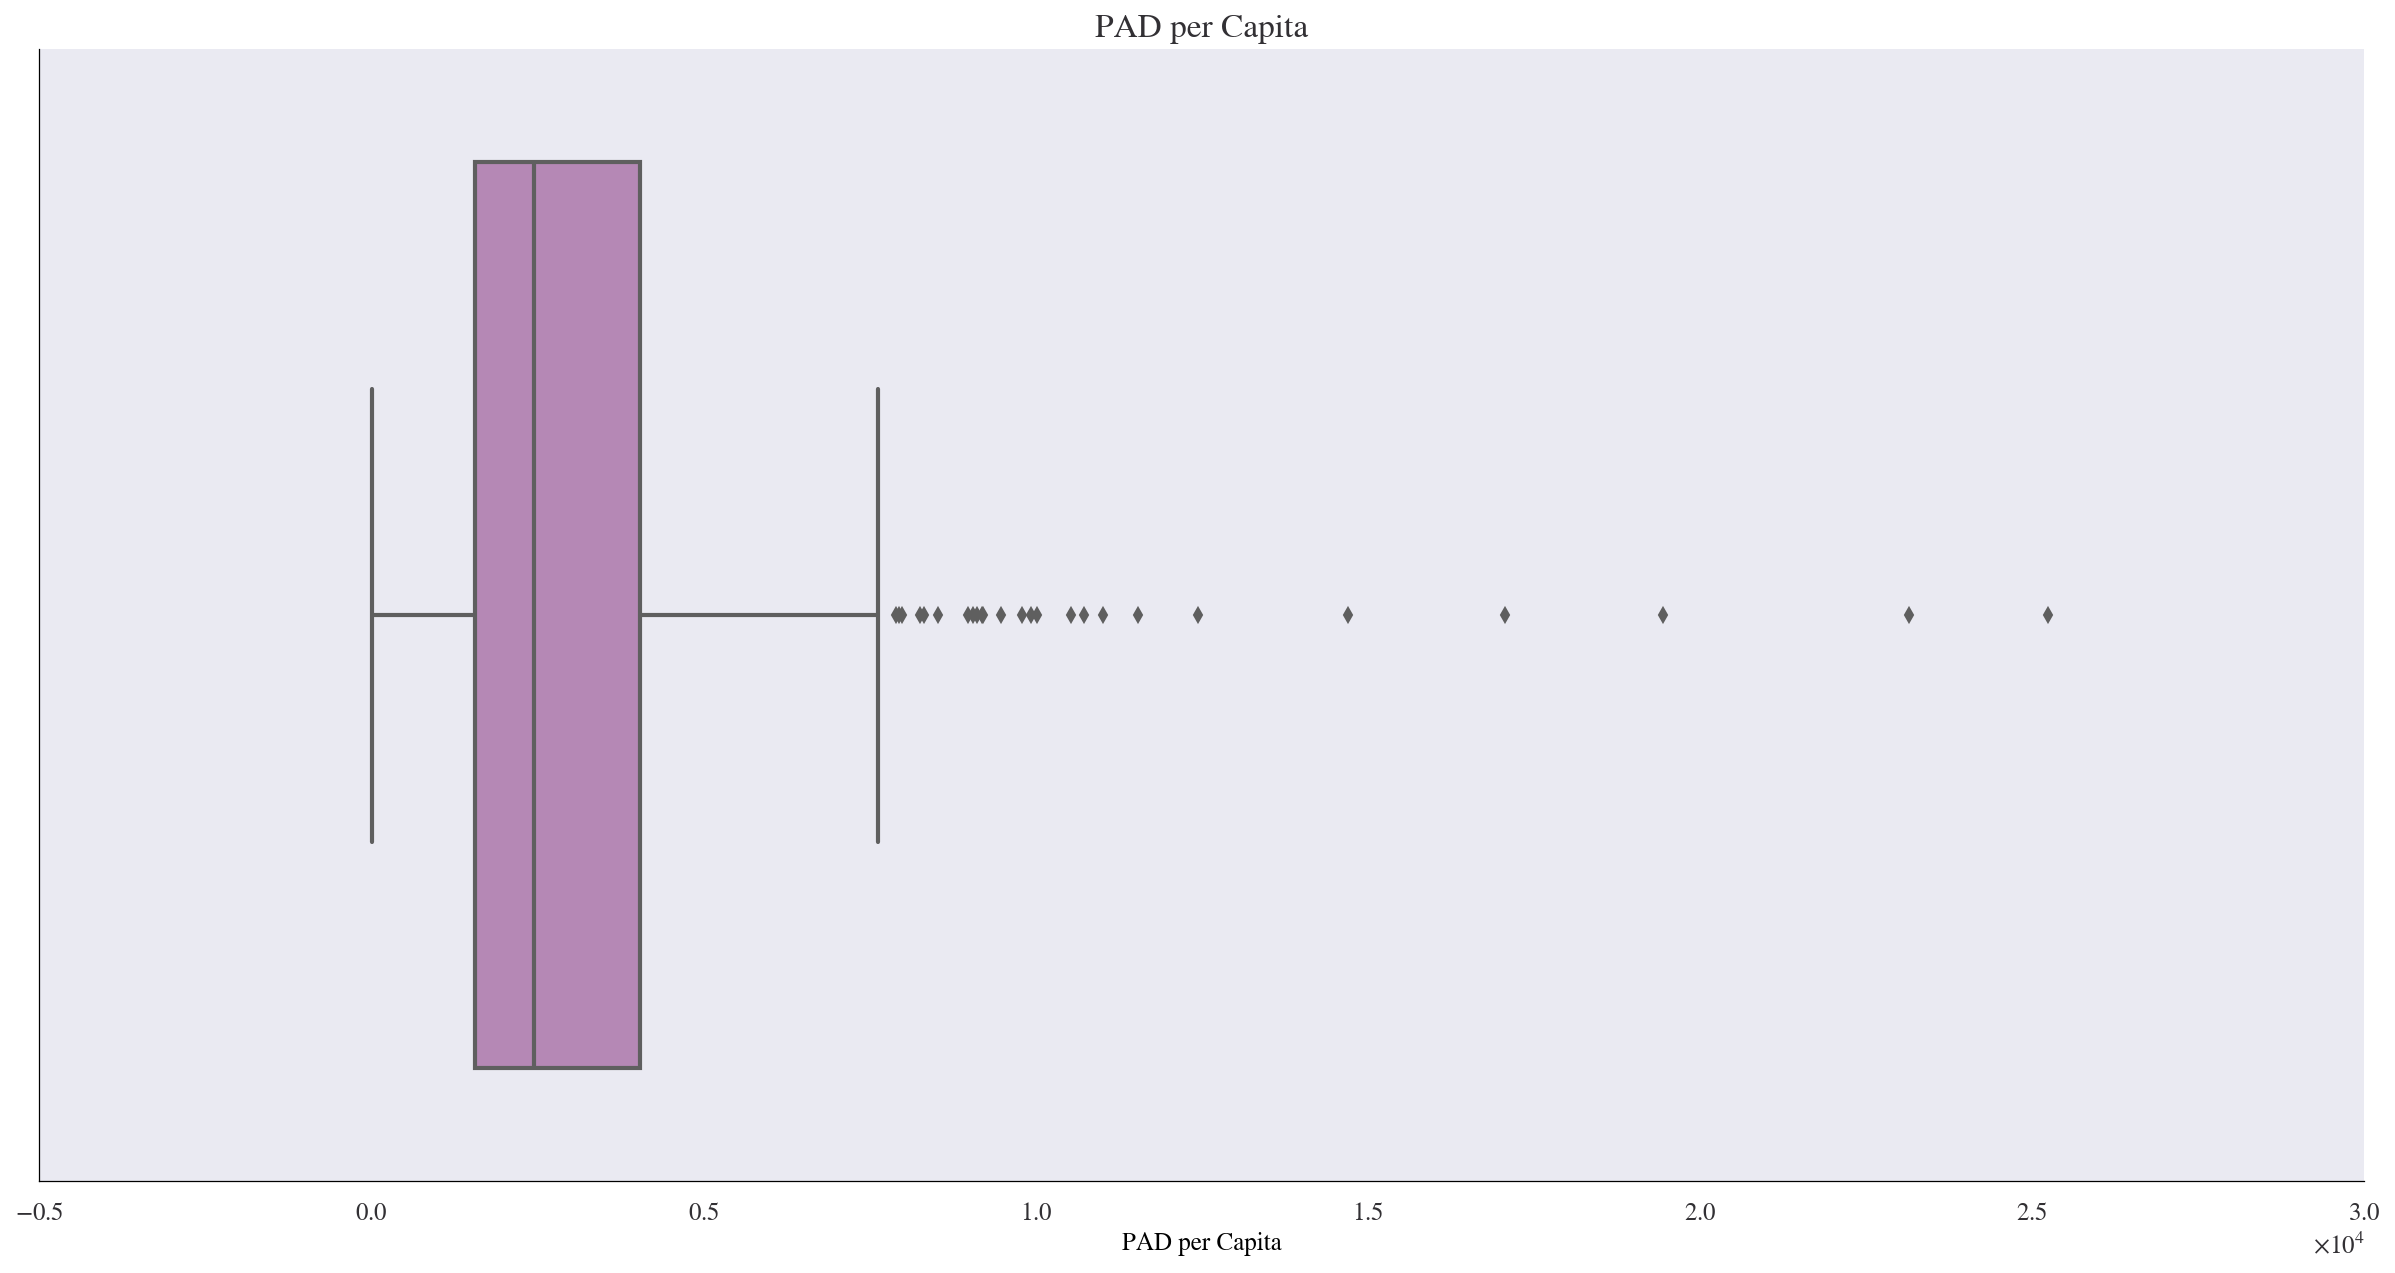

In [ ]:
plt.figure(figsize=(20, 10))
ax = sns.boxplot(x=df['PAD per Capita'])
ax.set_title("PAD per Capita", loc="center")

In [ ]:
outlier_pad = outlier_range(df,'PAD per Capita')
outlier_pad.sort_values(by='PAD per Capita',ascending=False)
# dont remove pad 

Provinsi          Kabupaten/Kota  PAD per Capita
506                 DKI JAKARTA             DKI JAKARTA    25239.854568
363                        BALI                  BADUNG    23138.824627
438                       PAPUA                  MIMIKA    19448.098101
189                 JAWA TENGAH           KOTA MAGELANG    17067.465089
484                 PAPUA BARAT       MANOKWARI SELATAN    14696.091065
228                  JAWA TIMUR          KOTA MOJOKERTO    12438.083687
318             SULAWESI TENGAH                MOROWALI    11532.466909
231                  JAWA TIMUR           KOTA SURABAYA    11014.621576
263           KALIMANTAN TENGAH      KOTAWARINGIN BARAT    10729.515865
237                  JAWA TIMUR                  GRESIK    10525.994465
471                   GORONTALO          KOTA GORONTALO    10022.287437
477              KEPULAUAN RIAU                 KARIMUN     9930.473486
208  DAERAH ISTIMEWA YOGYAKARTA         KOTA YOGYAKARTA     9788.514810
458                      BANTEN            KOTA CILEGON     9471.252188
3                          ACEH             KOTA SABANG     9202.360877
1                          ACEH                SIMEULUE     9186.715836
192                 JAWA TENGAH           KOTA SEMARANG     9113.944697
283            KALIMANTAN TIMUR            KOTA BONTANG     9056.005351
226                  JAWA TIMUR             KOTA MADIUN     8975.438318
461                      BANTEN  KOTA TANGERANG SELATAN     8522.197886
369                        BALI               KLUNGKUNG     8311.435388
371                        BALI           KOTA DENPASAR     8254.660440
127                     LAMPUNG              KOTA METRO     7991.586490
152                  JAWA BARAT            KOTA CIREBON     7936.205687
481              KEPULAUAN RIAU                  BINTAN     7893.857331

MANOKWARI SELATAN	anomalous

Lets see interaction between province and scatterplot

Text(0.5, 1.0, 'Boxplot PAD per Capita for each province')

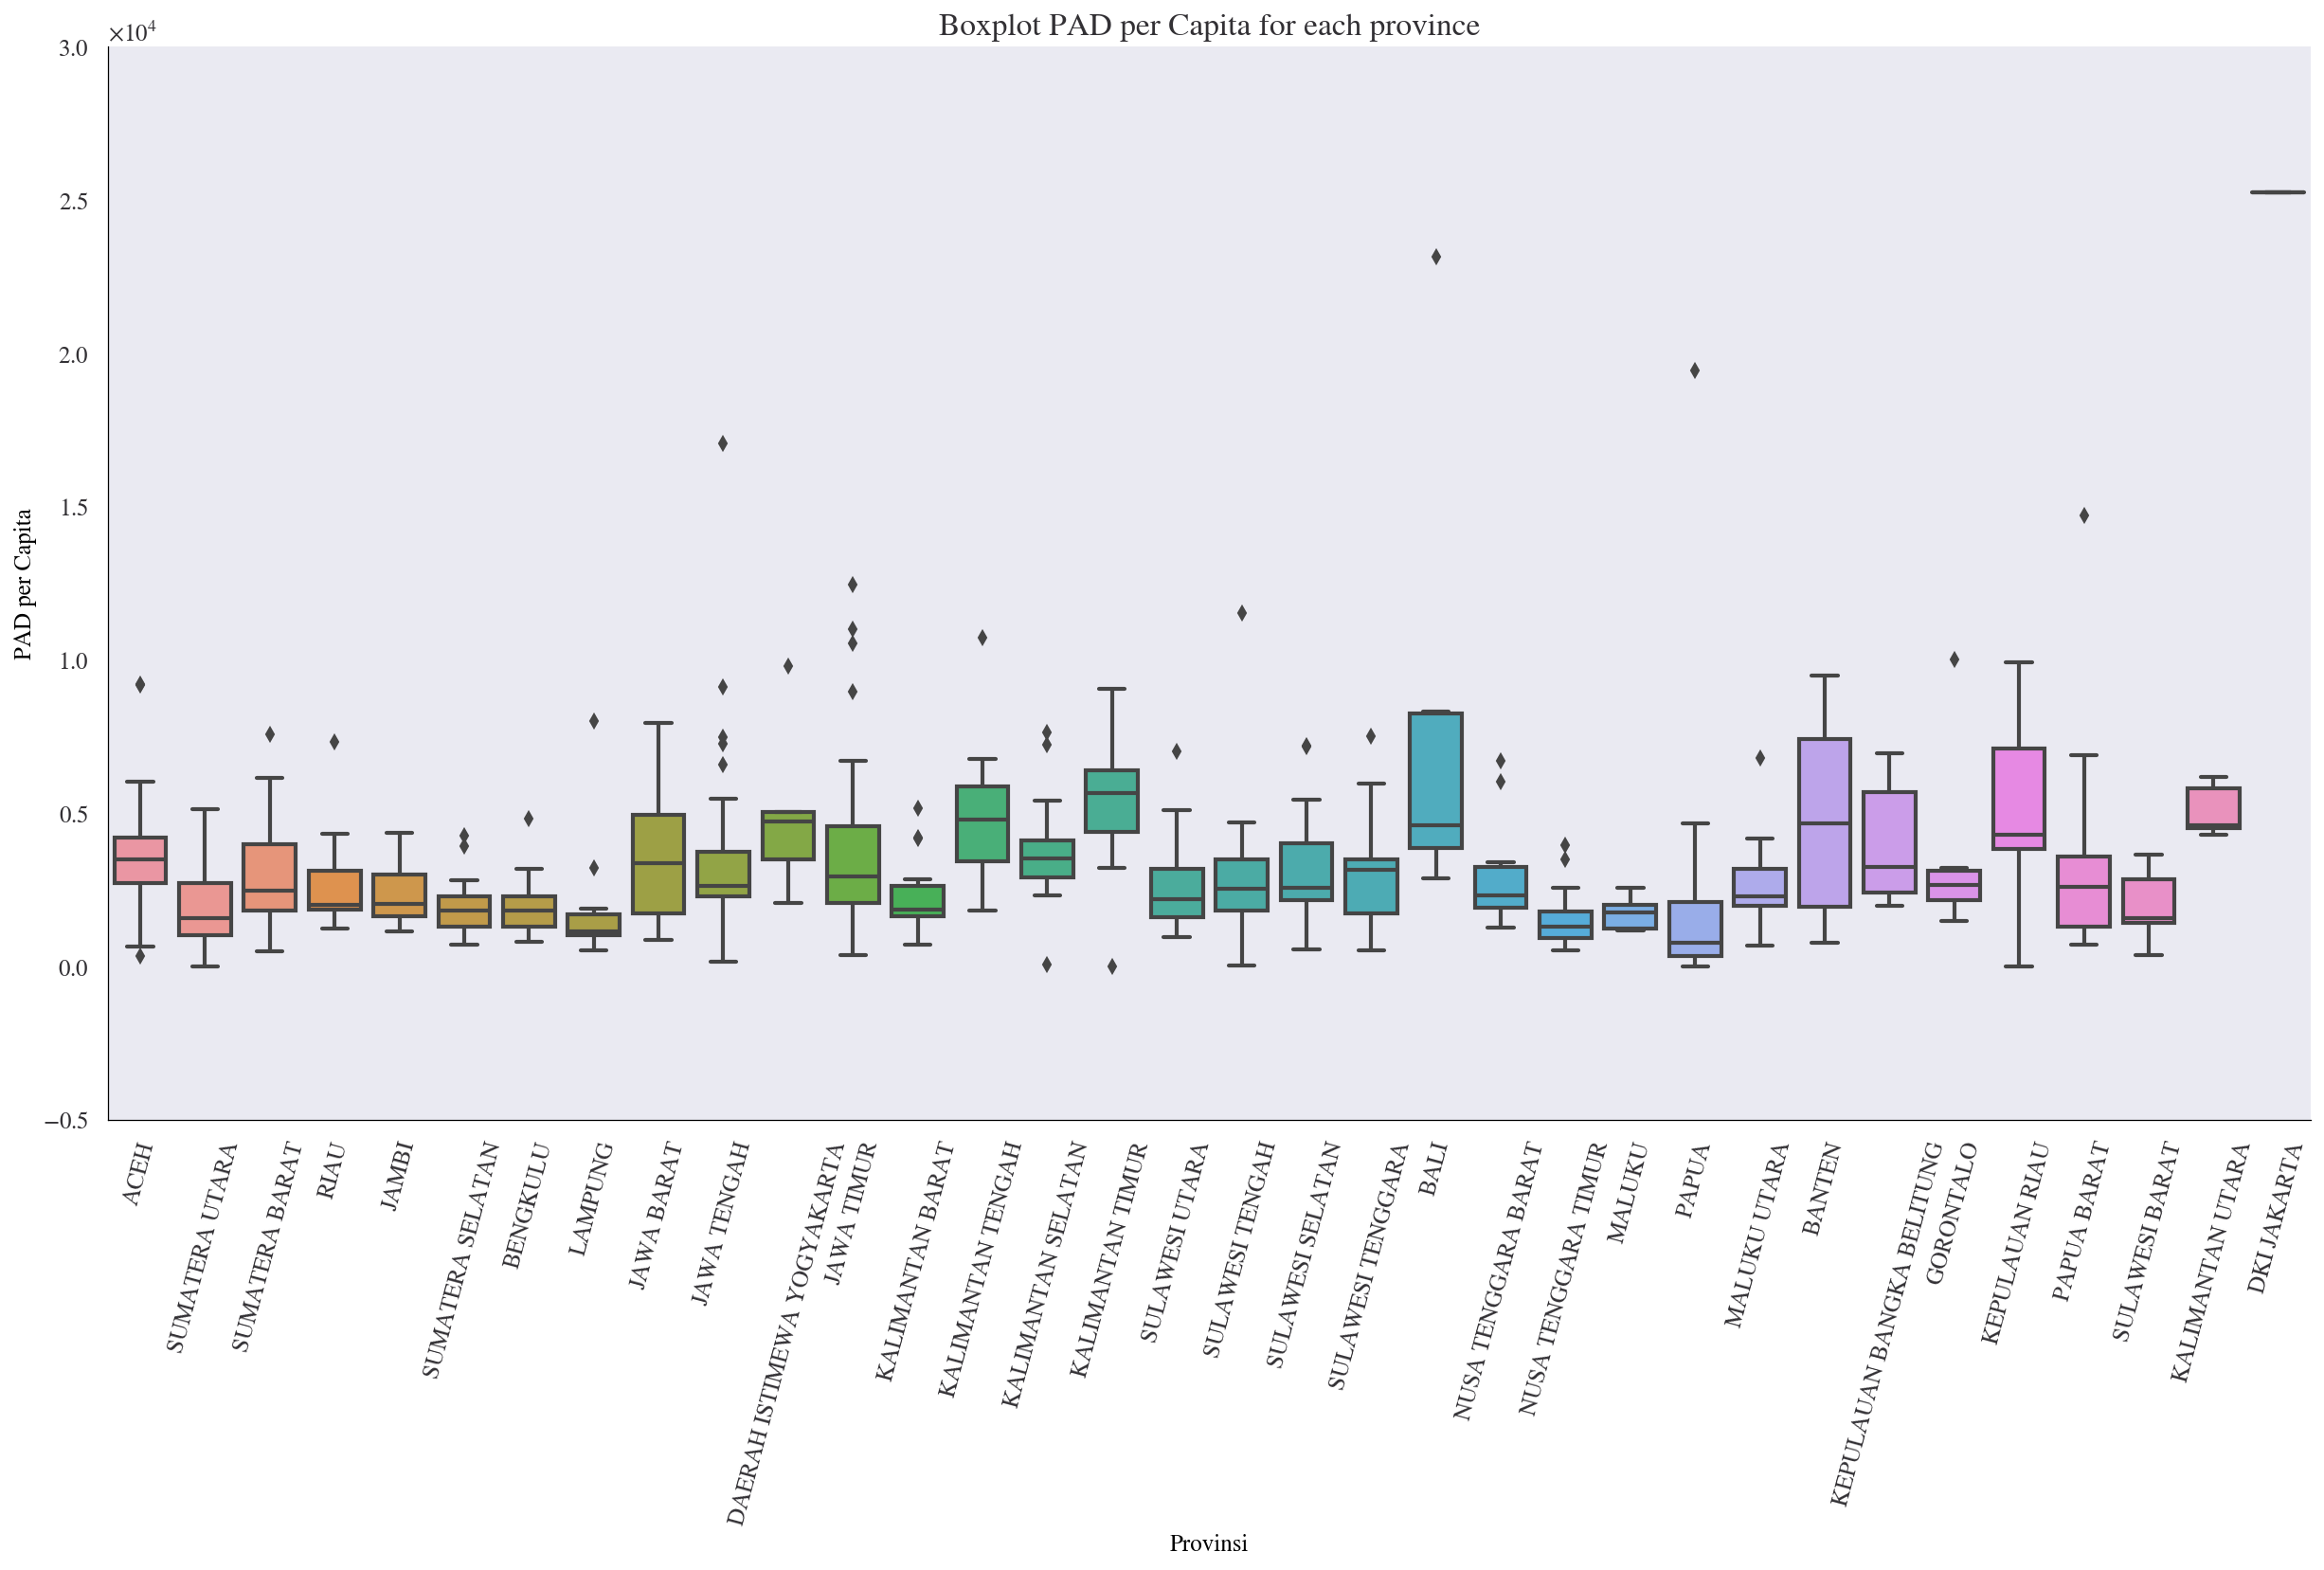

In [ ]:
ax = sns.boxplot(data=df, x="Provinsi", y="PAD per Capita");
ax.set_xticklabels(ax.get_xticklabels(),rotation = 75)
ax.set_title("Boxplot PAD per Capita for each province", loc="center")
 # rotate plots


As we can see, using boxplots gives us an idea which provinces have a higher PAD and which have lower one. Box plots with this many categories can be difficult to read. We can also use distributions to see the skew. 

# Distributions

We will plot the PAD per Capita/ Income per Capita of our dataset.
By plotting the distribution, we see that we have a positively skewed distribution. This means the median of our data is less than the mean. What this is telling us is that a few cities/regencies in Indonesia have a Income per Capita that is much higher than the rest that influences our mean to be greater than the median. Or another way of saying it is The income distribution in Indonesia is imbalanced

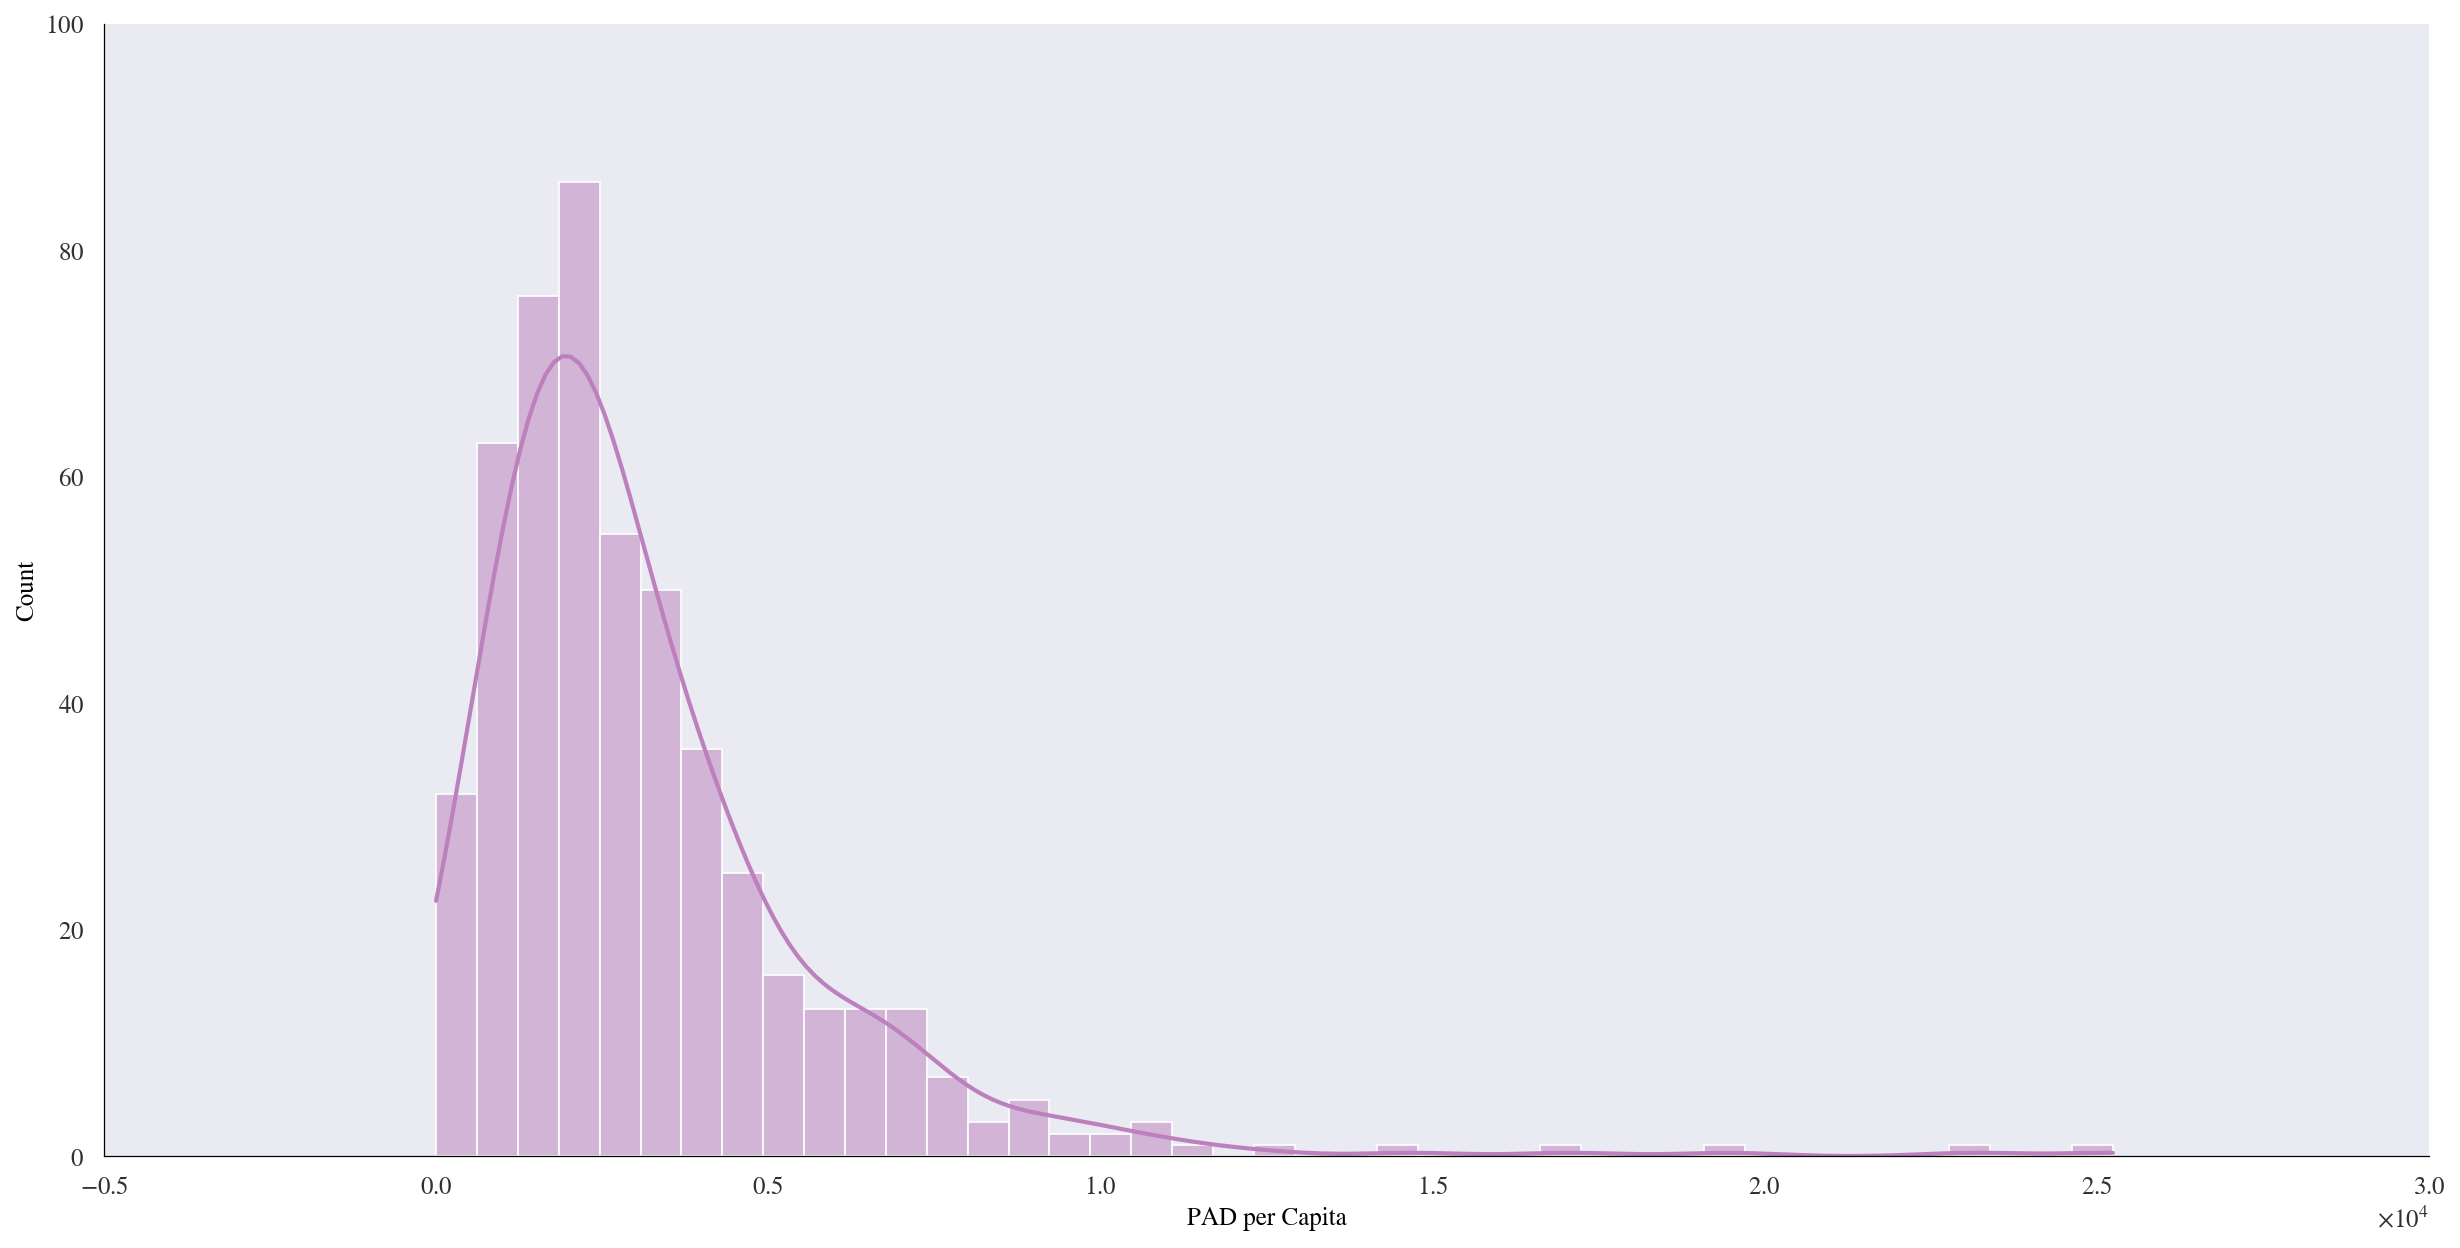

In [ ]:
# plot dist
# plot top correlation to PAD
ax = sns.histplot(data=df,x="PAD per Capita",kde=True)

Sort correlation on PAD per Capita

Text(0.5, 1.0, 'Highest correlation value to PAD per Capita')

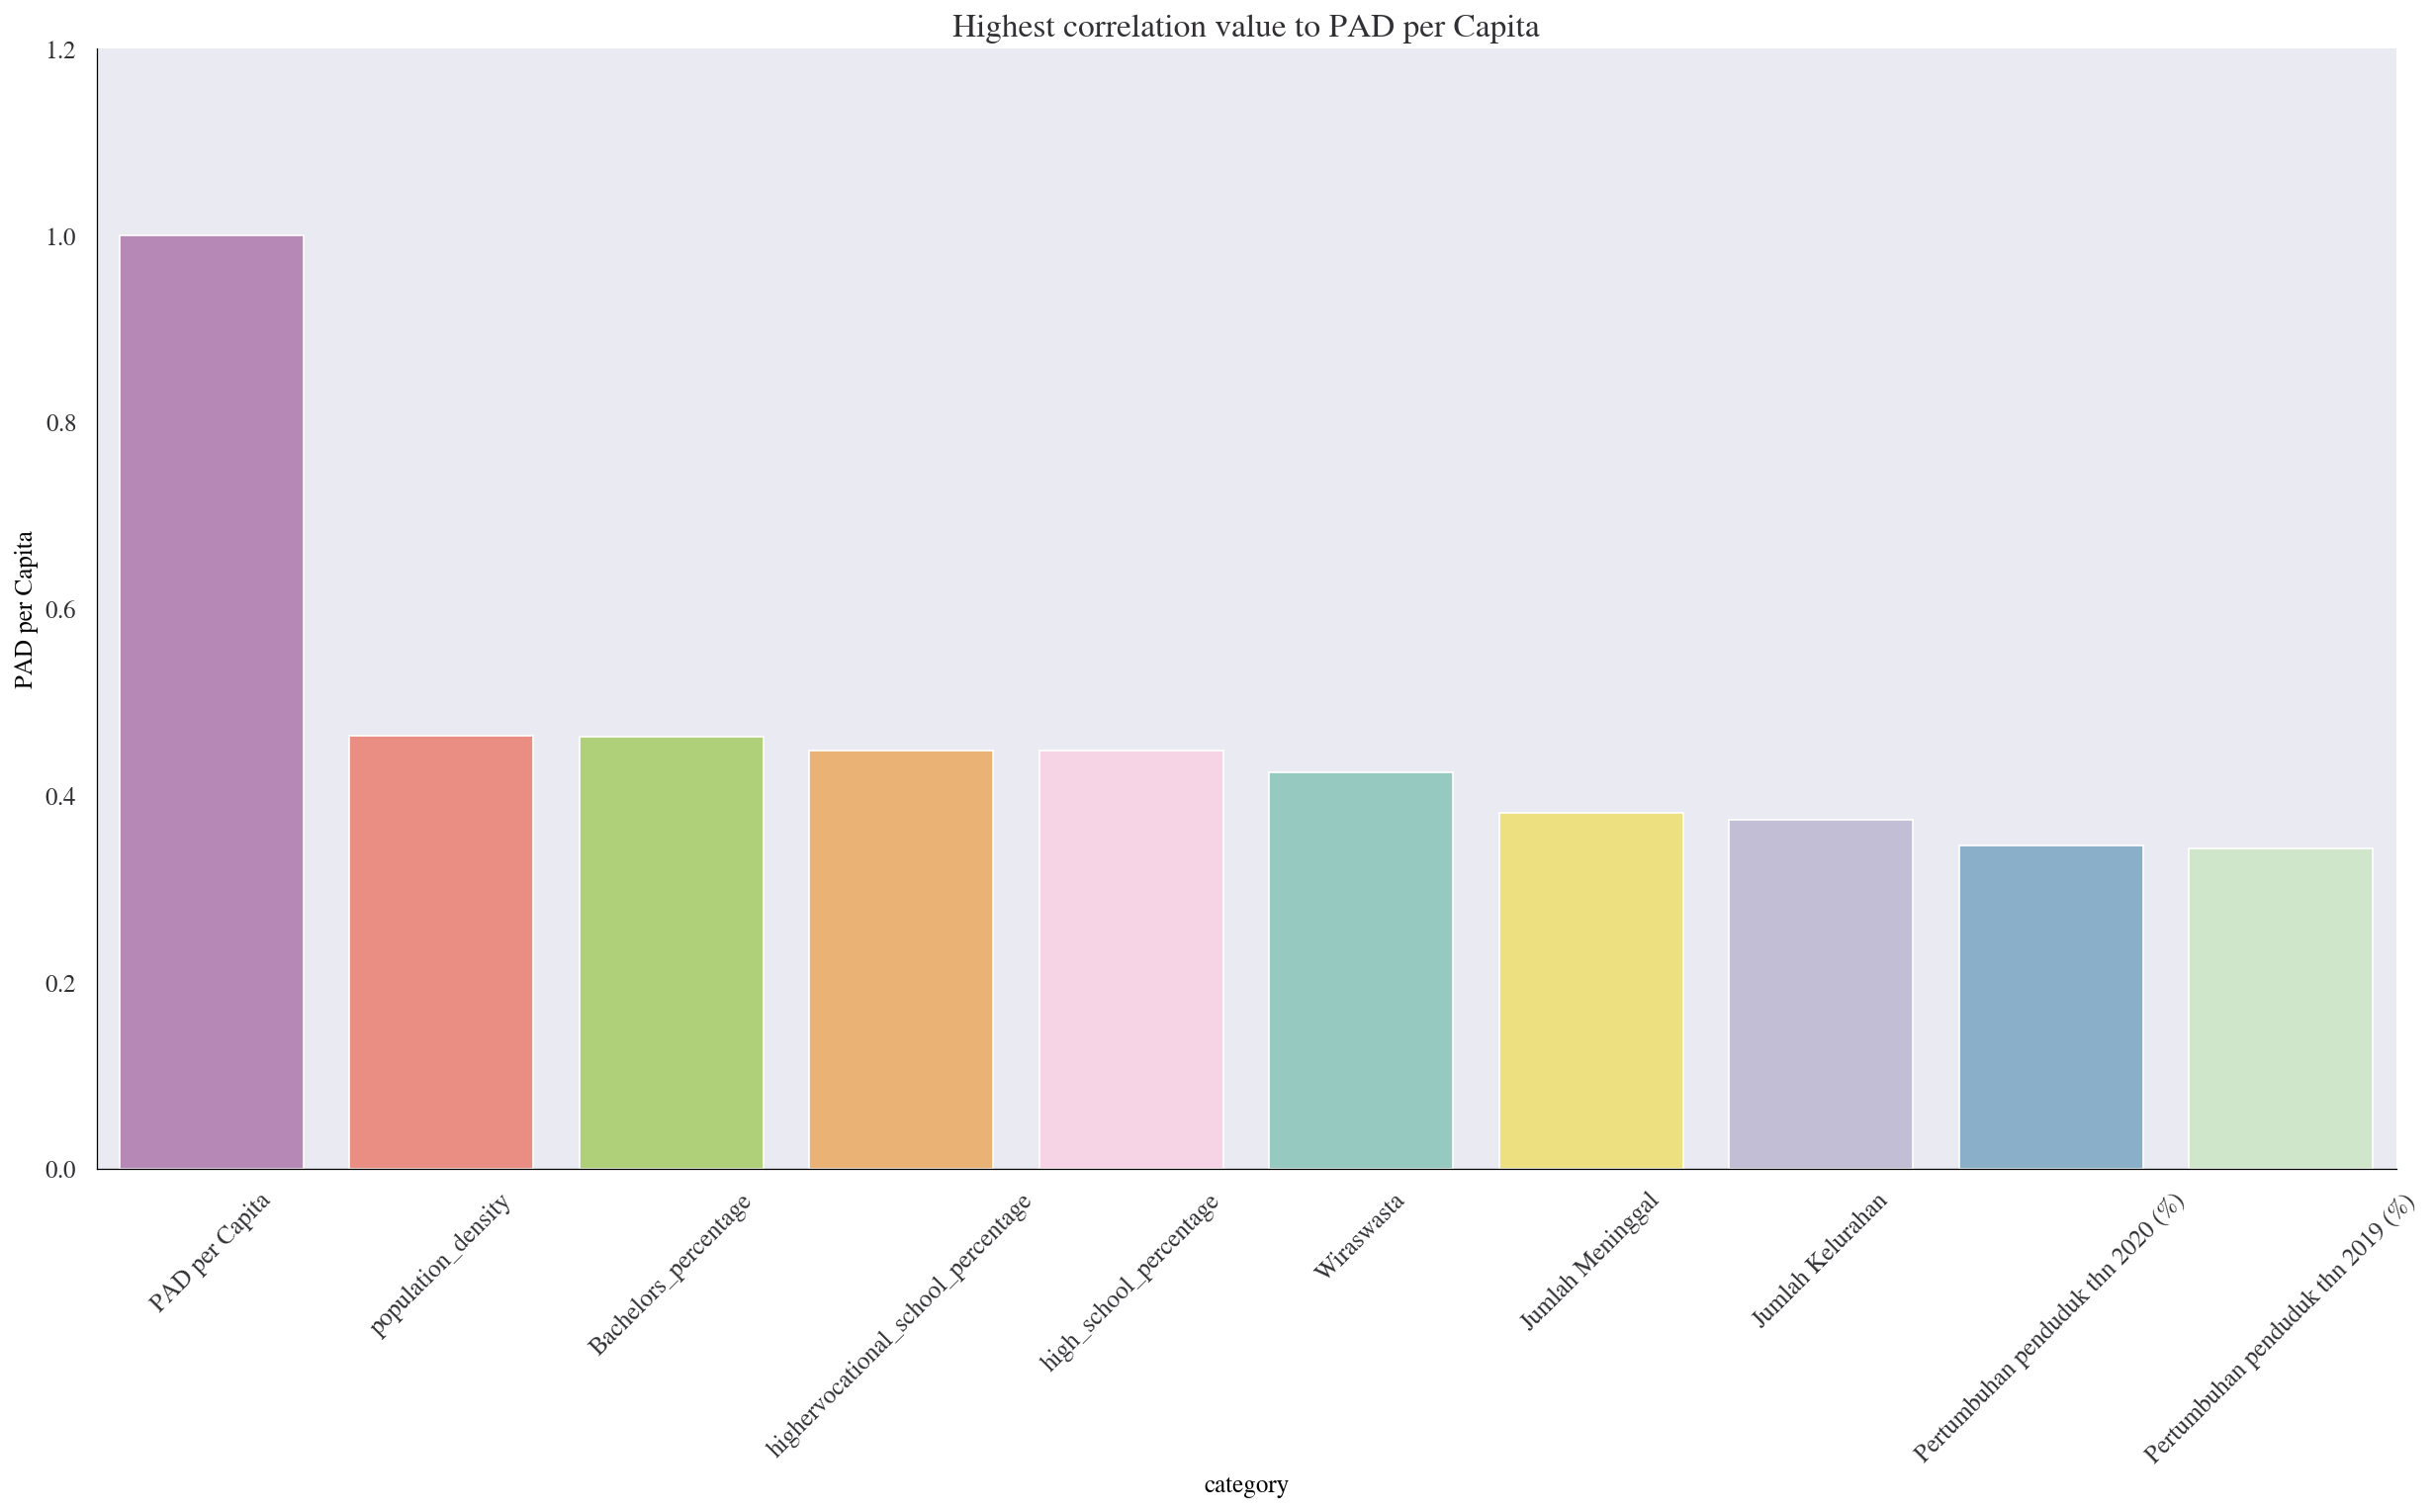

In [ ]:
highest_pos_corr_pad = df.corr()[['PAD per Capita']].sort_values(by='PAD per Capita',ascending=False).head(10)
highest_pos_corr_pad['category'] = highest_pos_corr_pad.index
highest_pos_corr_pad.head()
ax = sns.barplot(x="category", y="PAD per Capita", data=highest_pos_corr_pad)
ax.set_xticklabels(labels = highest_pos_corr_pad.category,rotation=45)
ax.set_title("Highest correlation value to PAD per Capita", loc="center")

Text(0.5, 1.0, 'Highest negative correlation value to PAD per Capita')

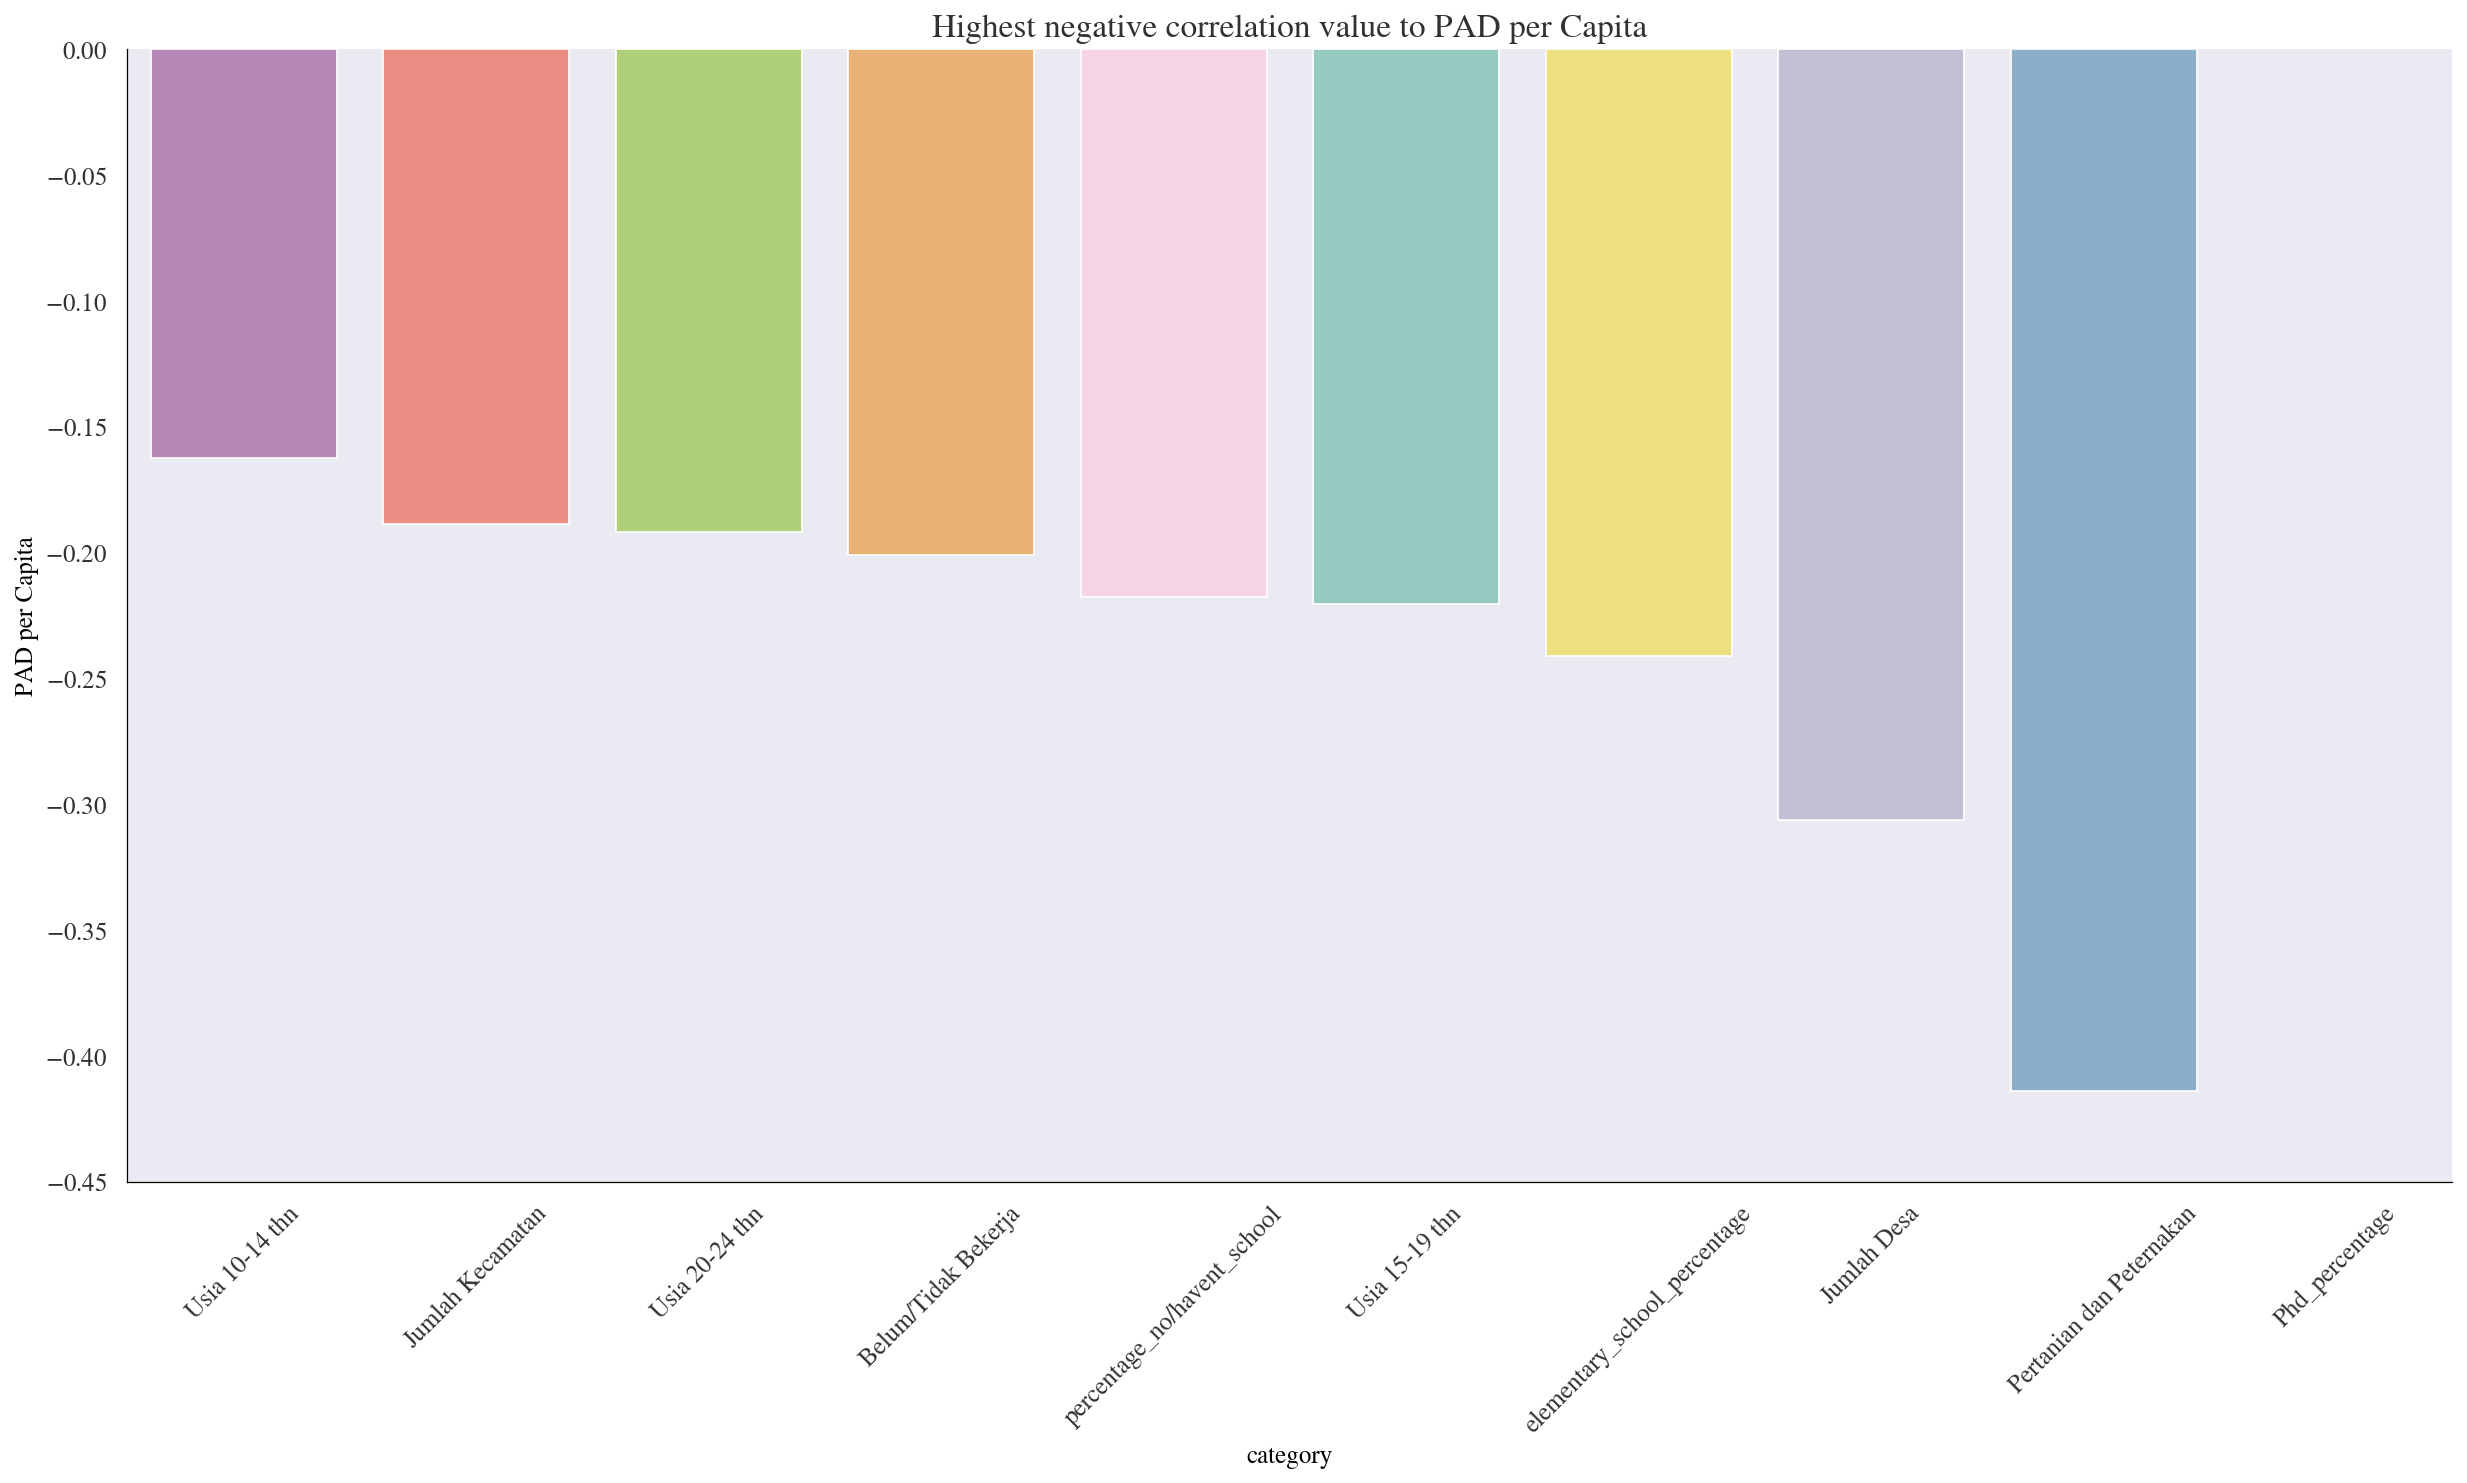

In [ ]:
lowest_pos_corr_pad = df.corr()[['PAD per Capita']].sort_values(by='PAD per Capita',ascending=False).tail(10)
lowest_pos_corr_pad['category'] = lowest_pos_corr_pad.index
#lowest_pos_corr_pad.head()
ax = sns.barplot(x="category", y="PAD per Capita", data=lowest_pos_corr_pad)
ax.set_xticklabels(labels = lowest_pos_corr_pad.category,rotation=45)
ax.set_title("Highest negative correlation value to PAD per Capita", loc="center")

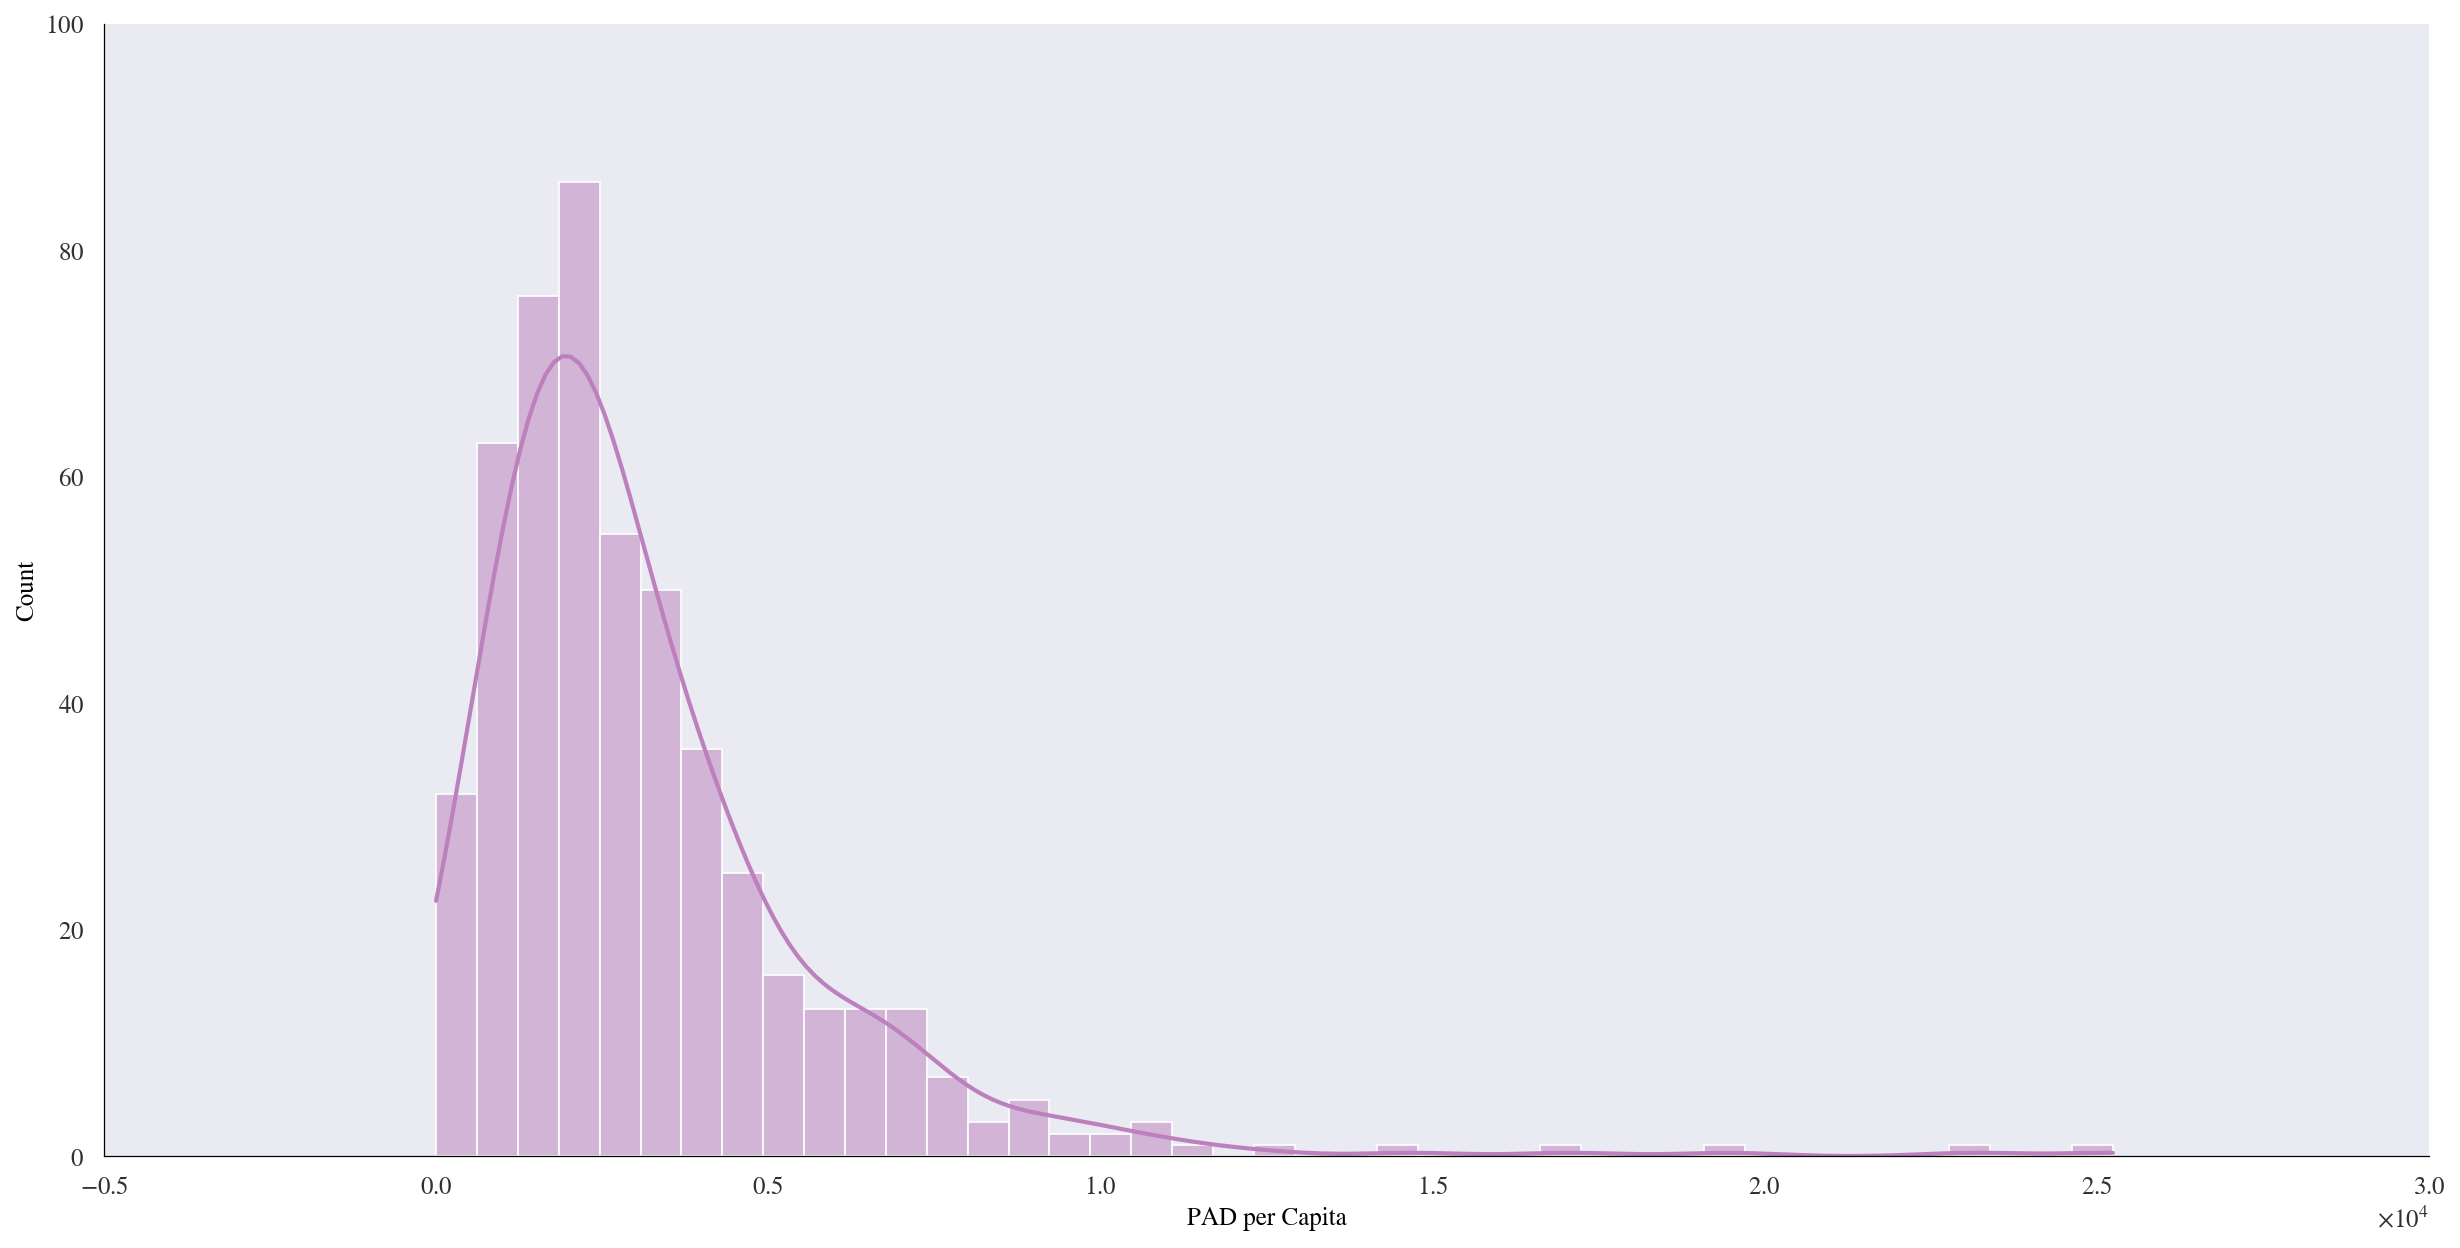

In [ ]:
# plot dist
# plot top correlation to PAD
ax = sns.histplot(data=df,x="PAD per Capita",kde=True)

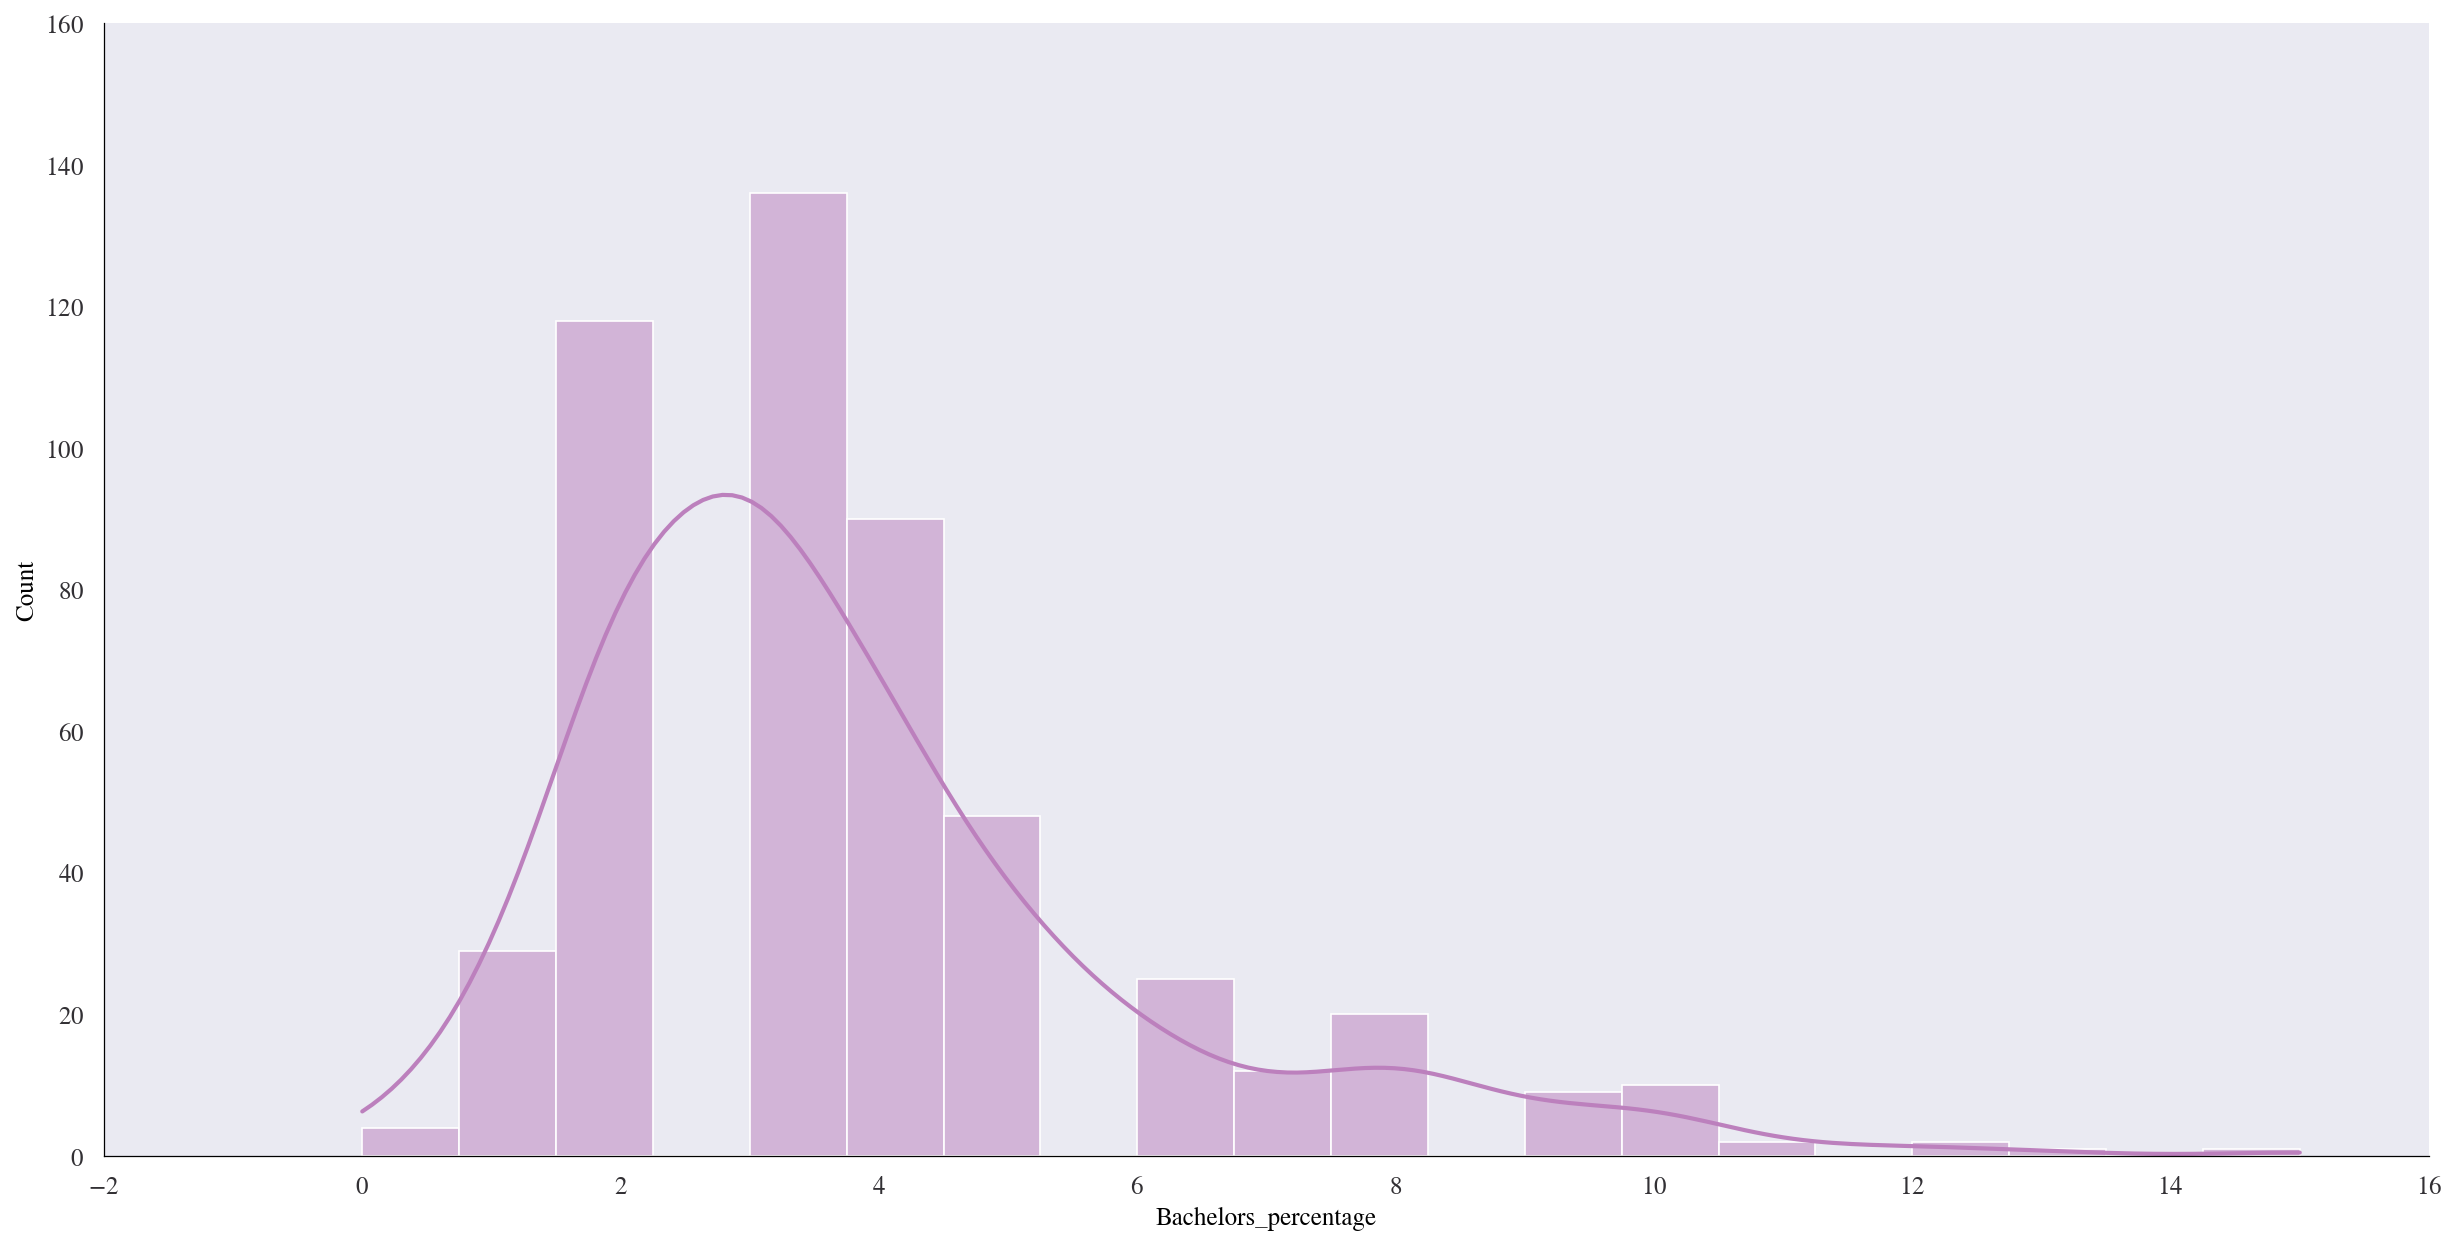

In [ ]:
ax = sns.histplot(data=df,x="Bachelors_percentage",kde=True)

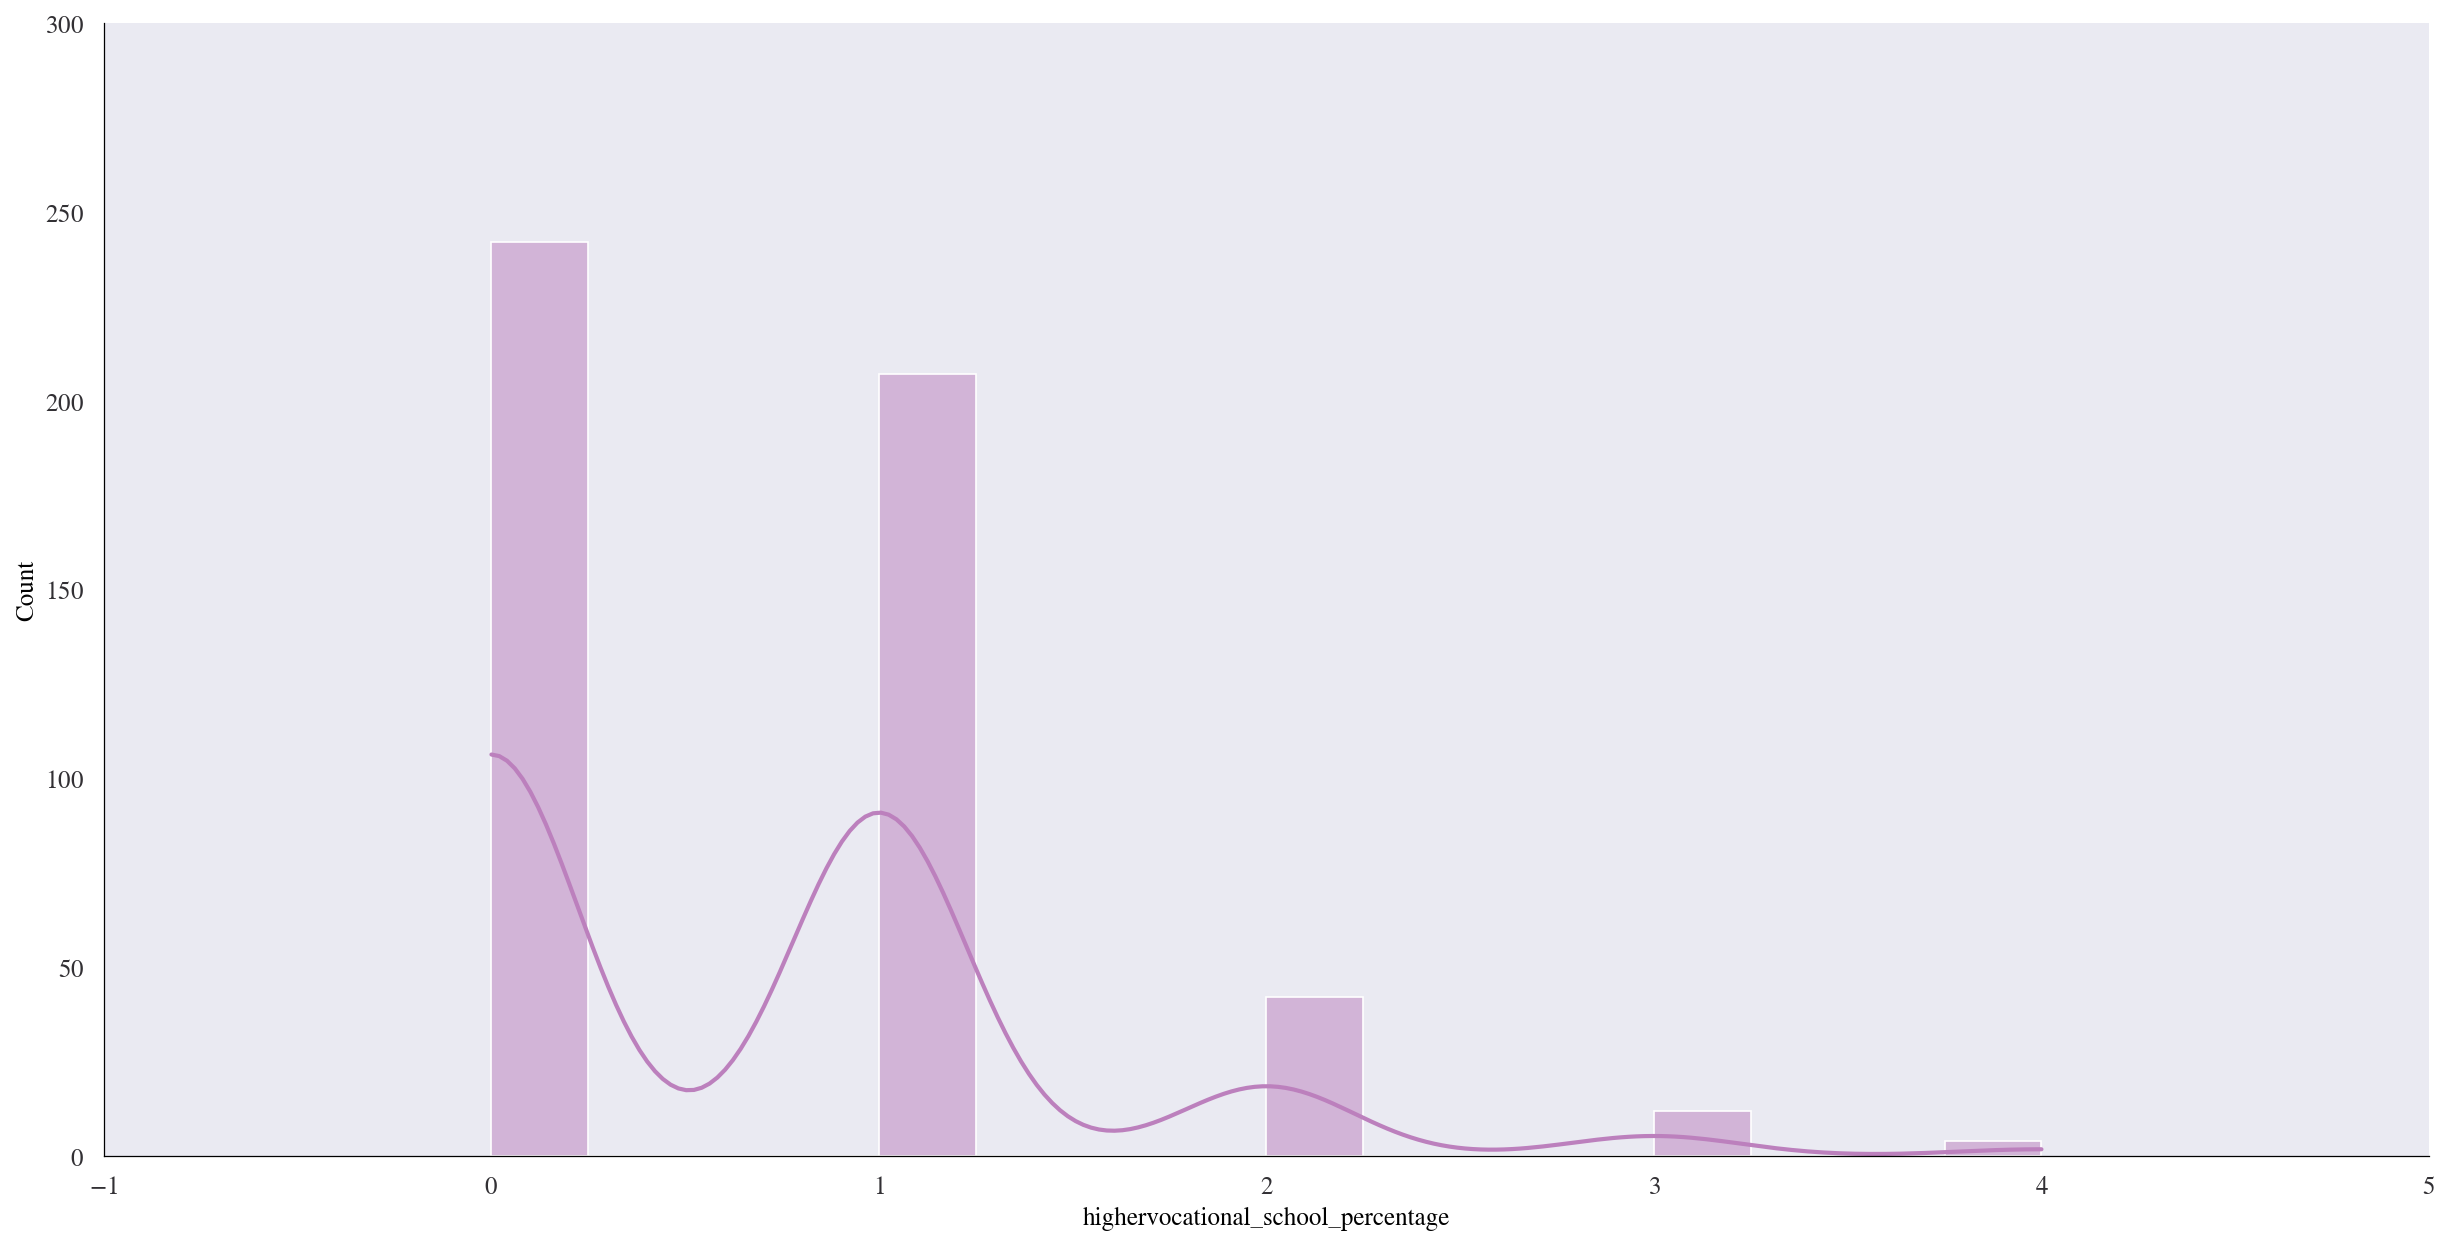

In [ ]:
ax = sns.histplot(data=df,x="highervocational_school_percentage",kde=True)

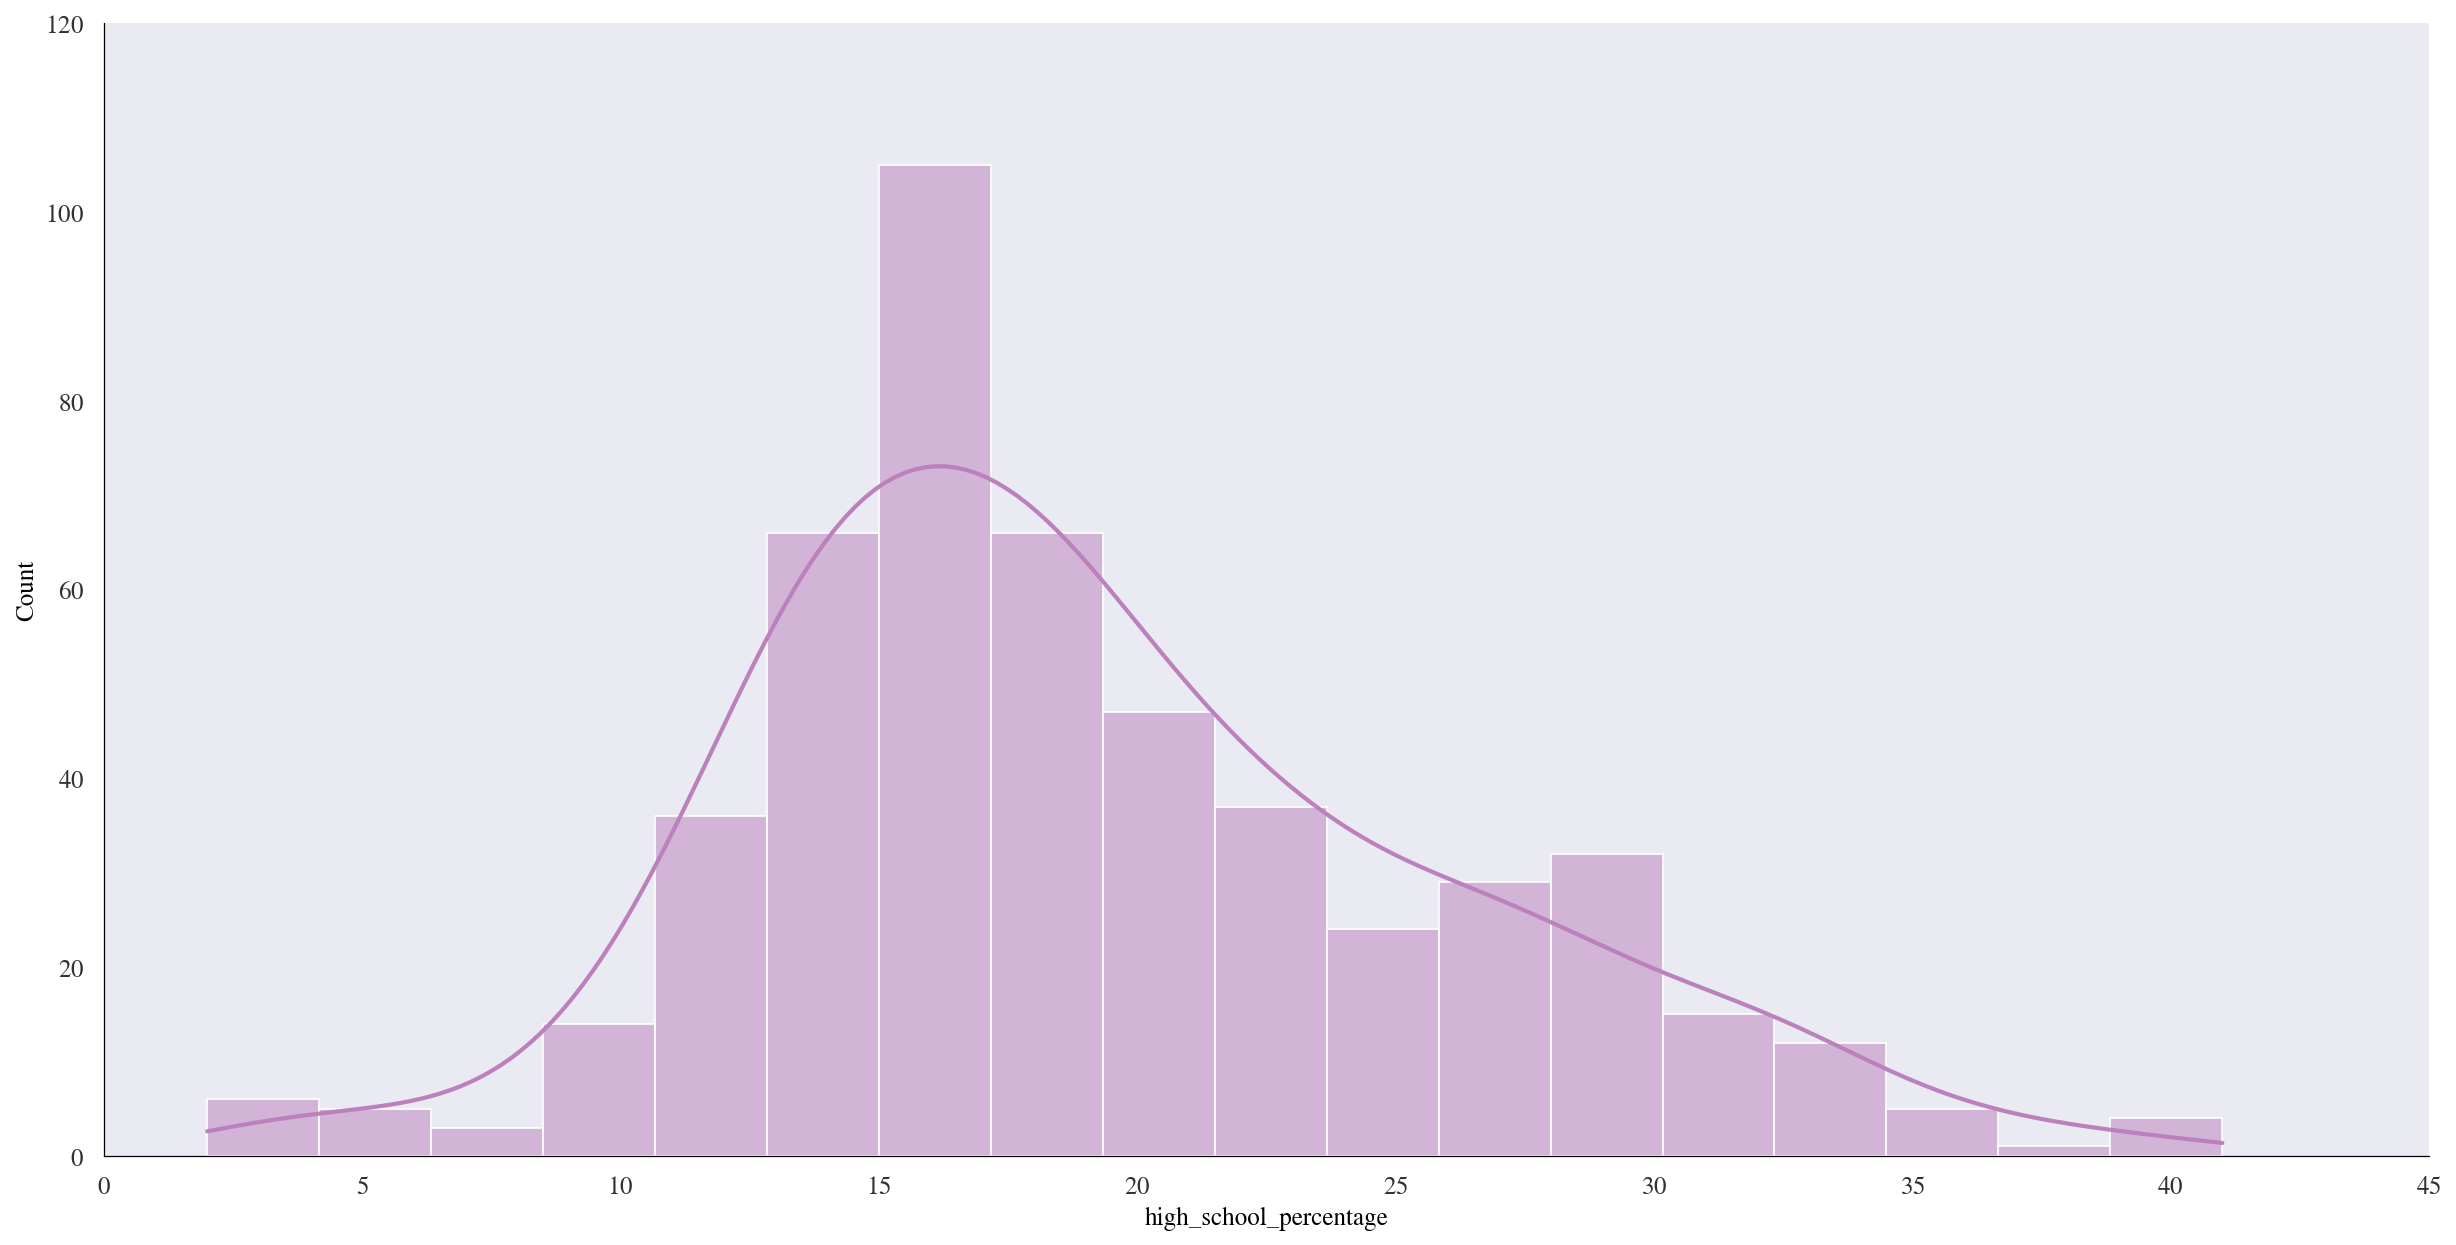

In [ ]:
ax = sns.histplot(data=df,x="high_school_percentage",kde=True)

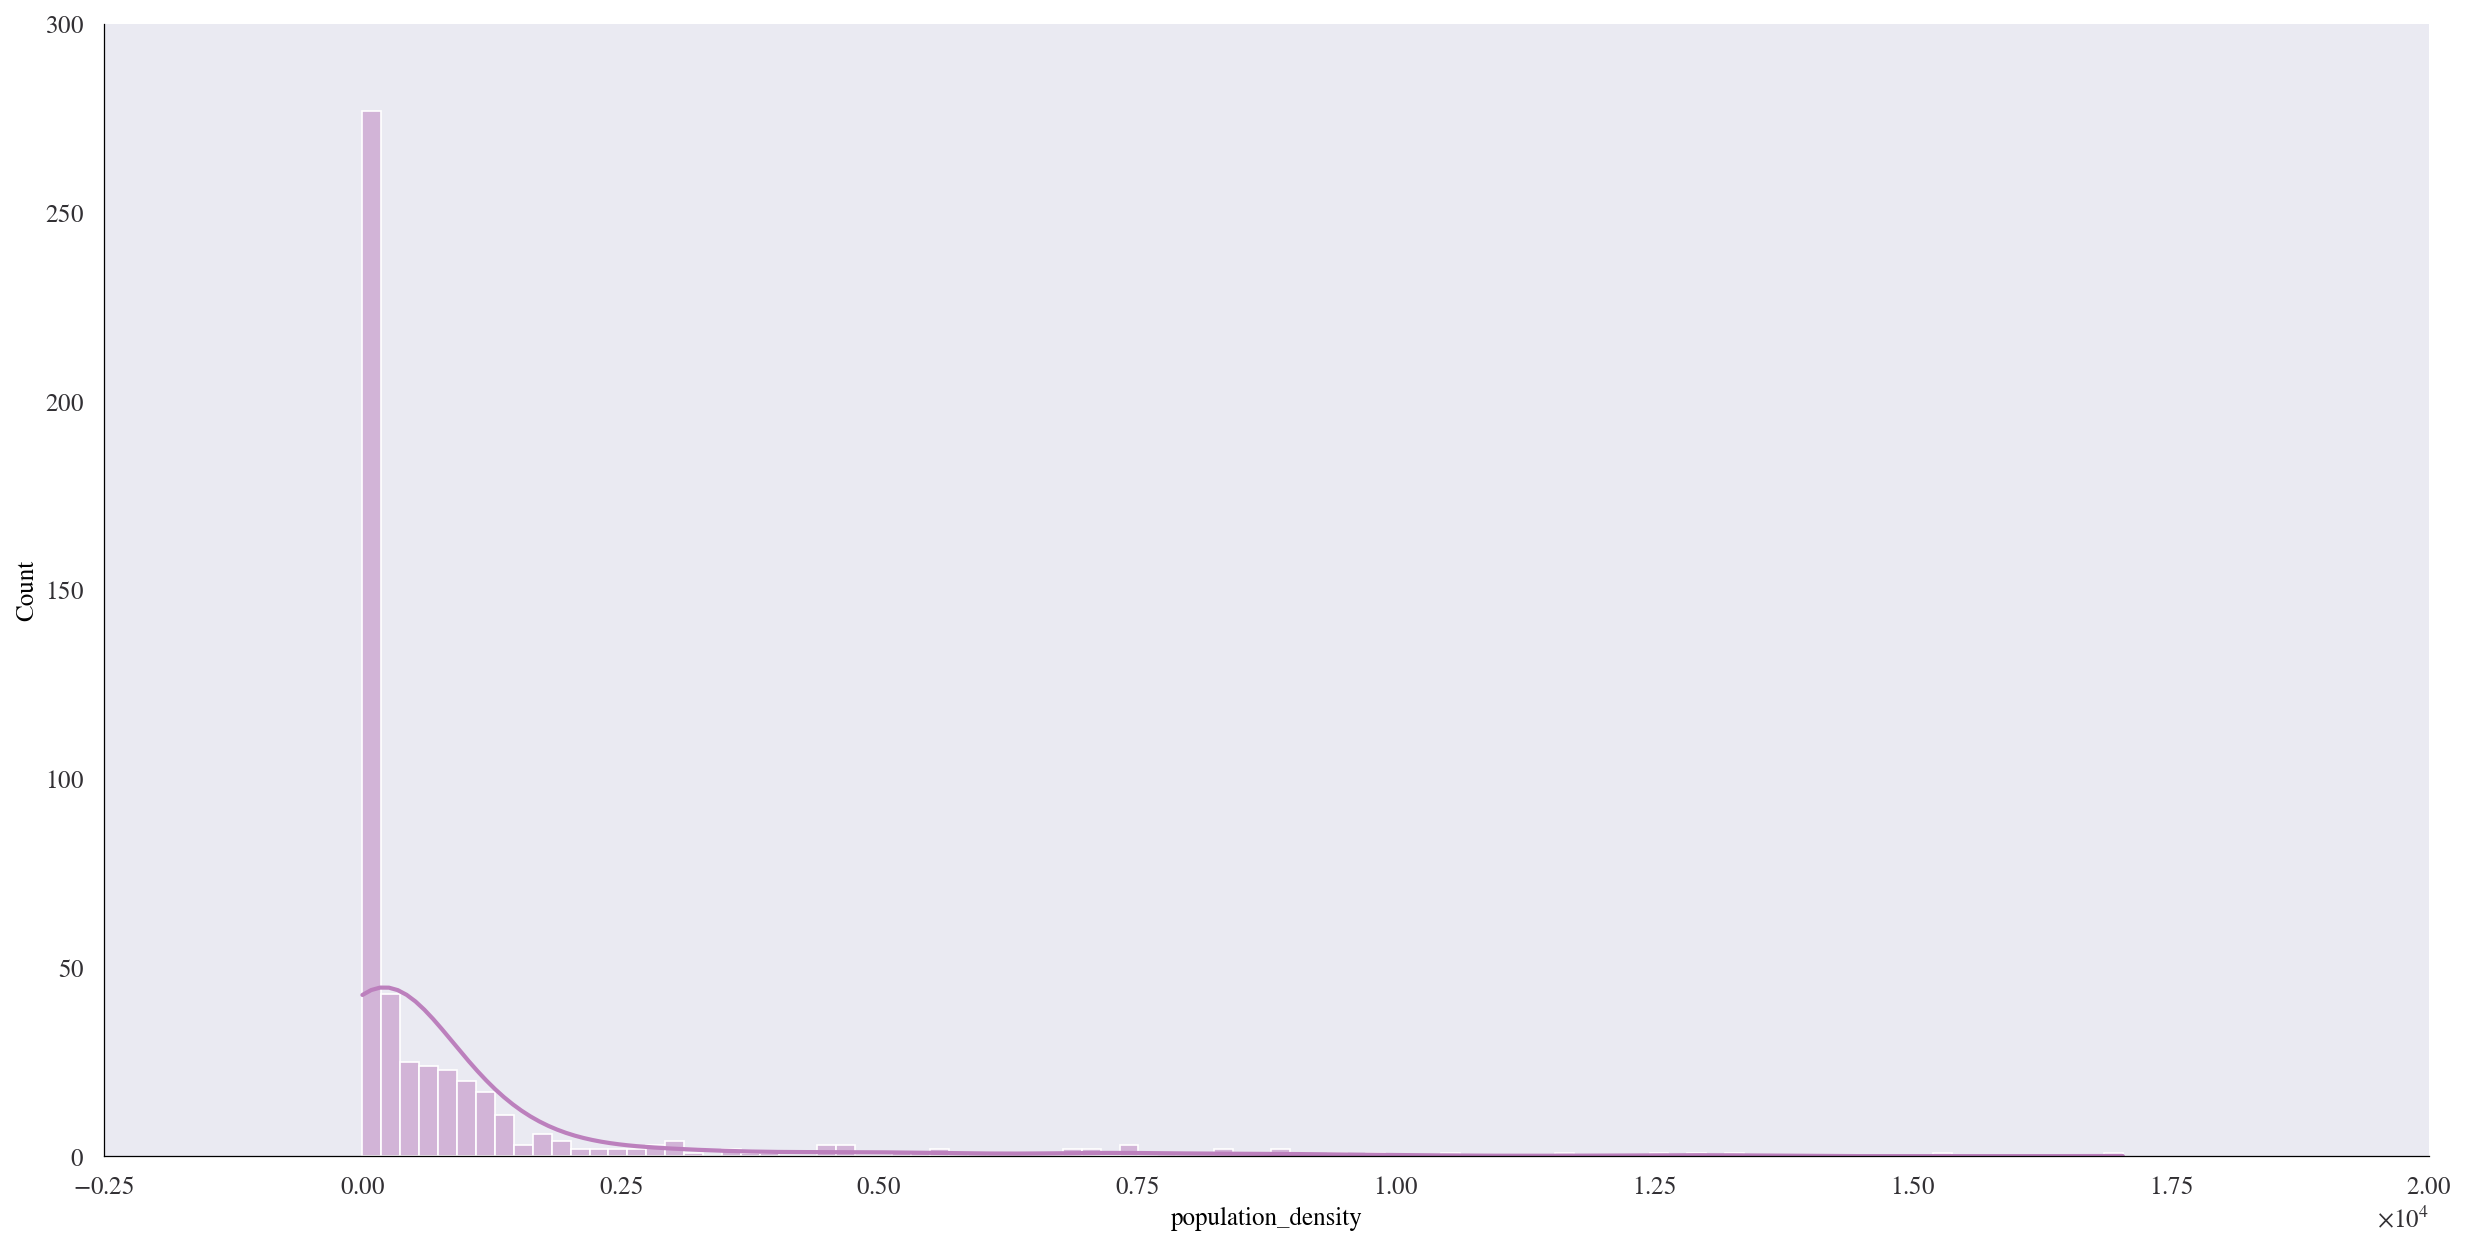

In [ ]:
ax = sns.histplot(data=df,x="population_density",kde=True)

In [ ]:
# plot bachelors, vocational school, highschool percentage 

# Ansecombe Quartet

Importance of plotting/visualization... 

### Positive correlation

Text(0.5, 1.0, 'Regression of Highschool Percentage to PAD per Capita')

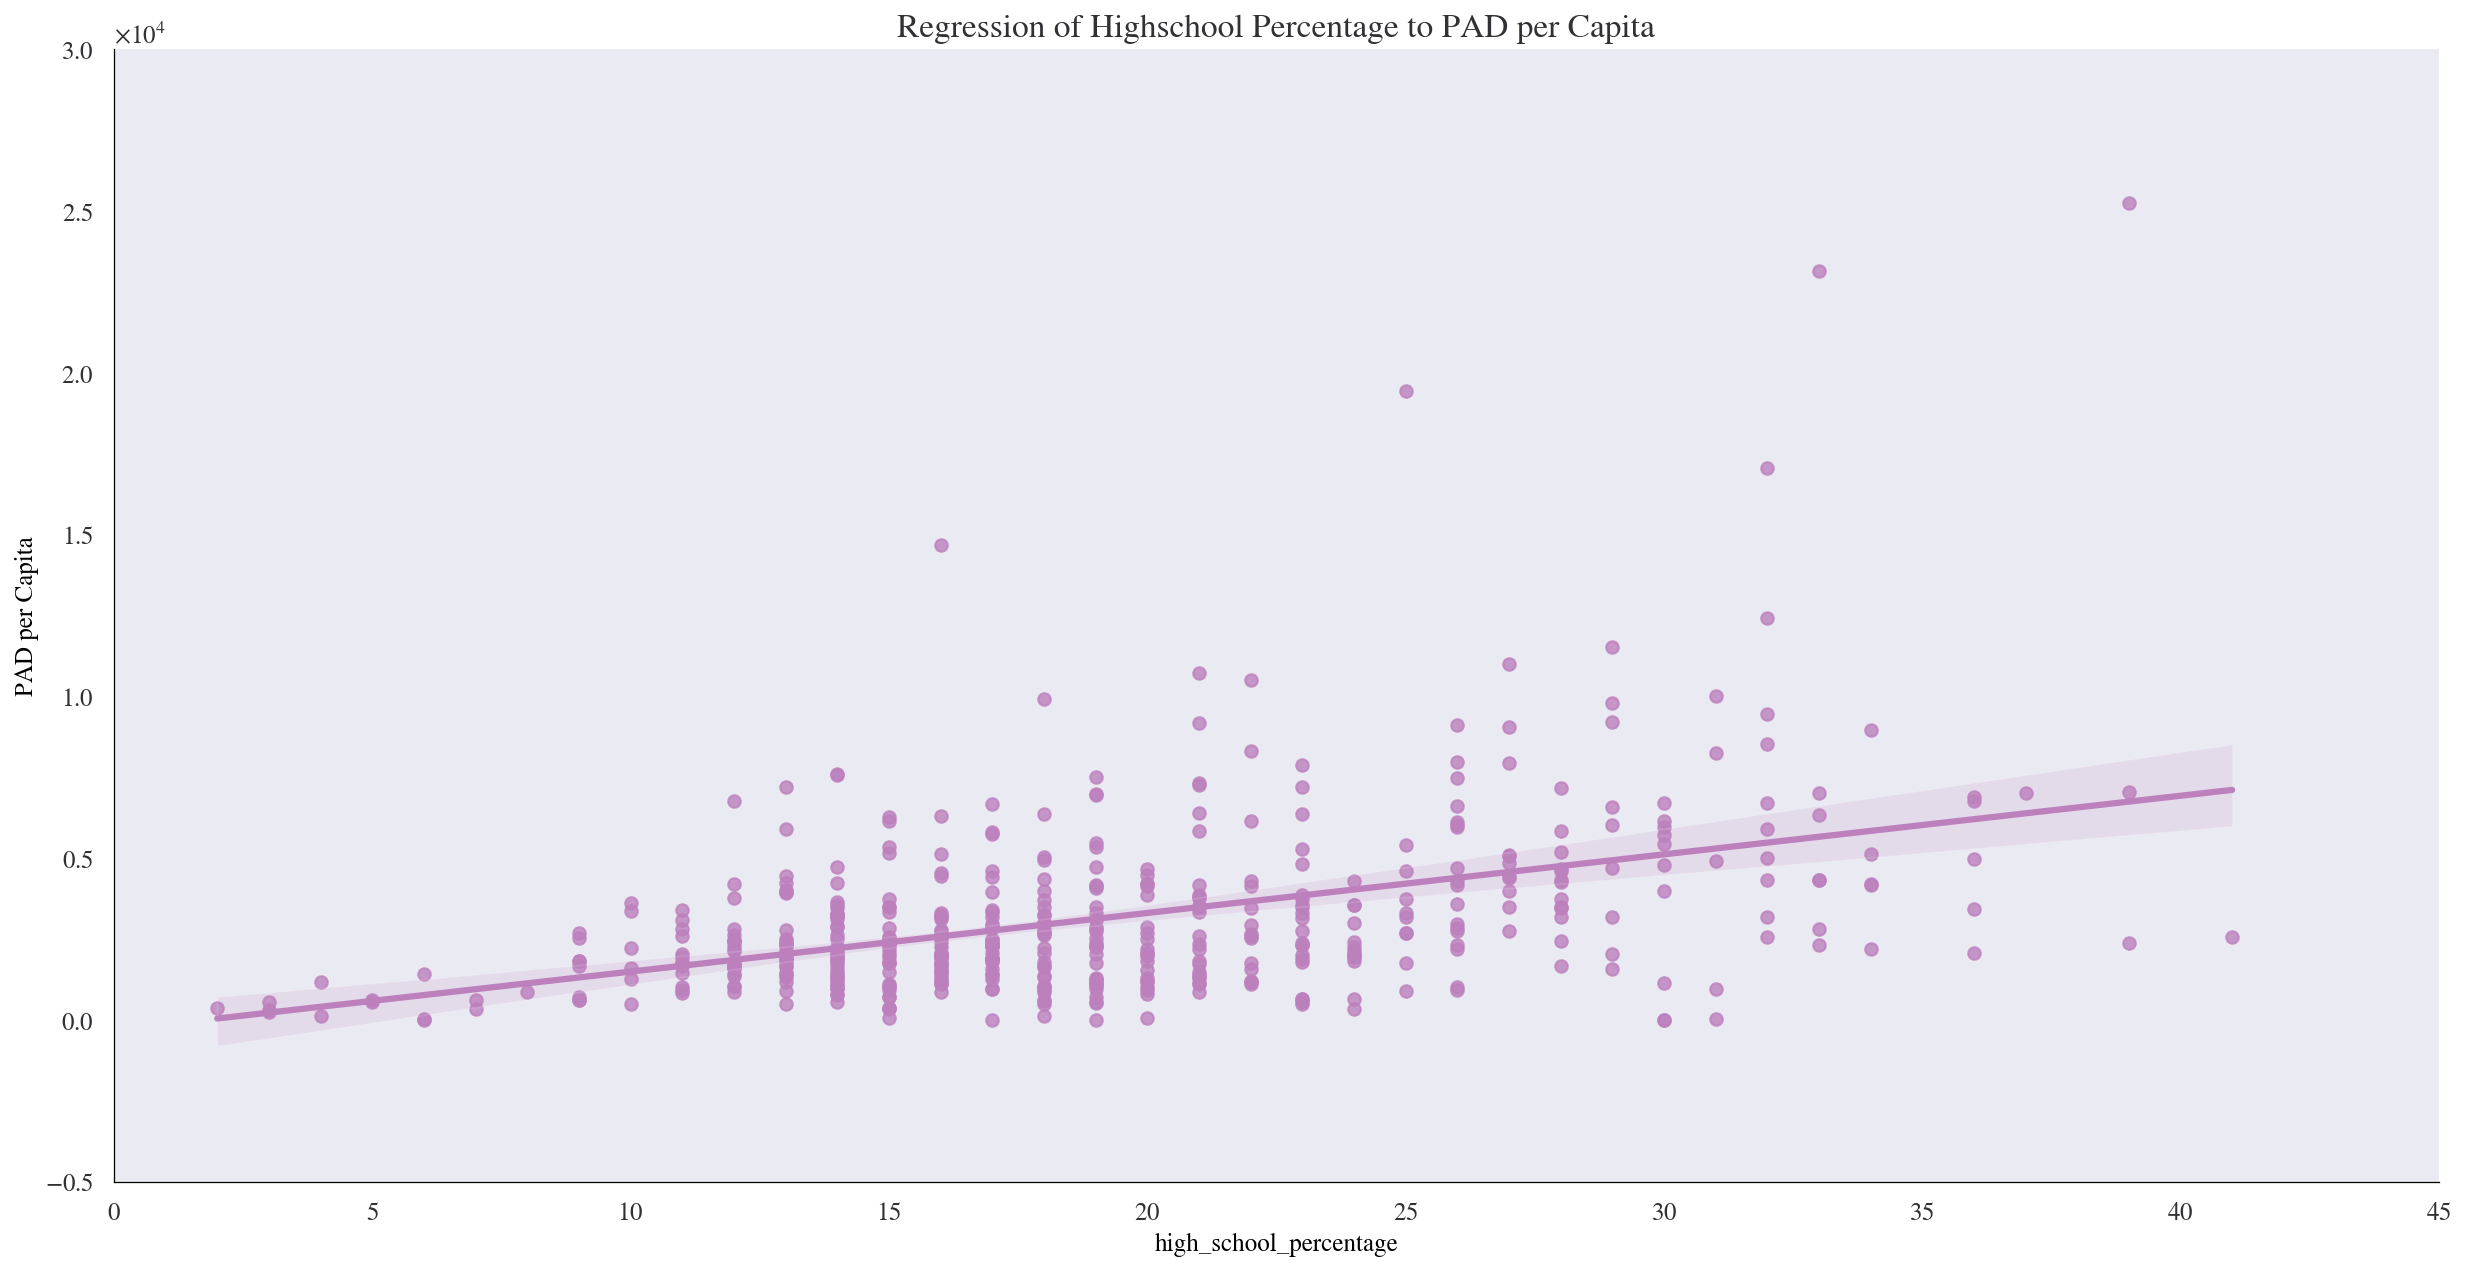

In [ ]:
ax = sns.regplot(x="high_school_percentage", y="PAD per Capita", data=df)
ax.set_title("Regression of Highschool Percentage to PAD per Capita", loc="center")

Text(0.5, 1.0, 'Regression of Vocational school Percentage to PAD per Capita')

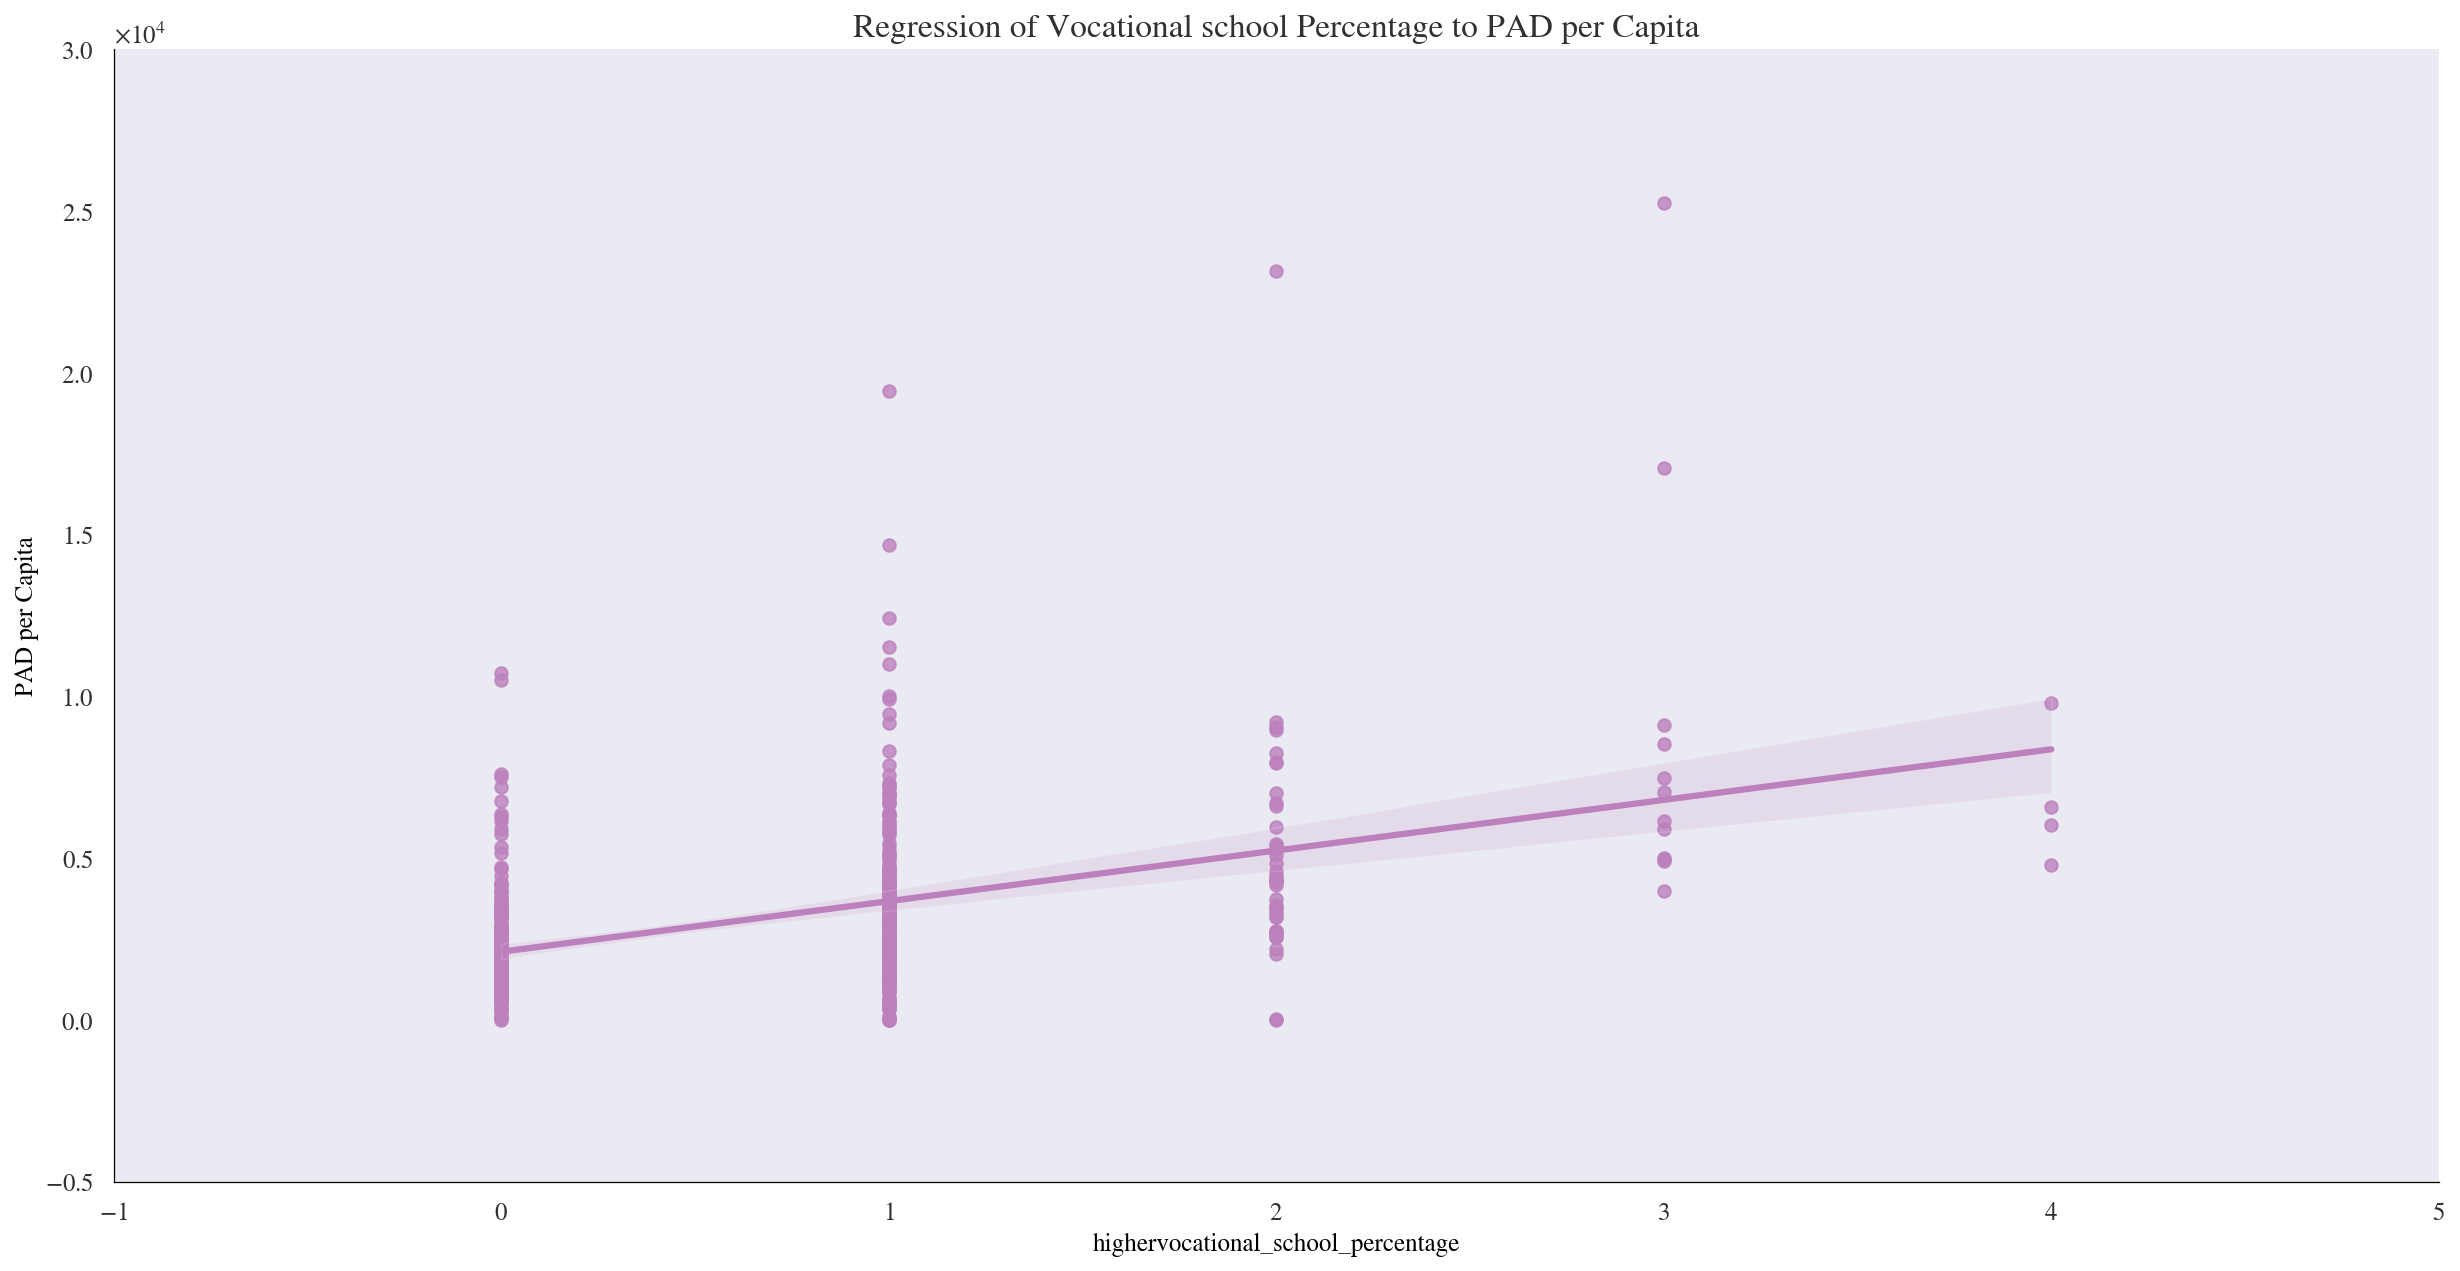

In [ ]:
ax = sns.regplot(x="highervocational_school_percentage", y="PAD per Capita", data=df)
ax.set_title("Regression of Vocational school Percentage to PAD per Capita", loc="center")

Text(0.5, 1.0, 'Regression of Bachelors Percentage to PAD per Capita')

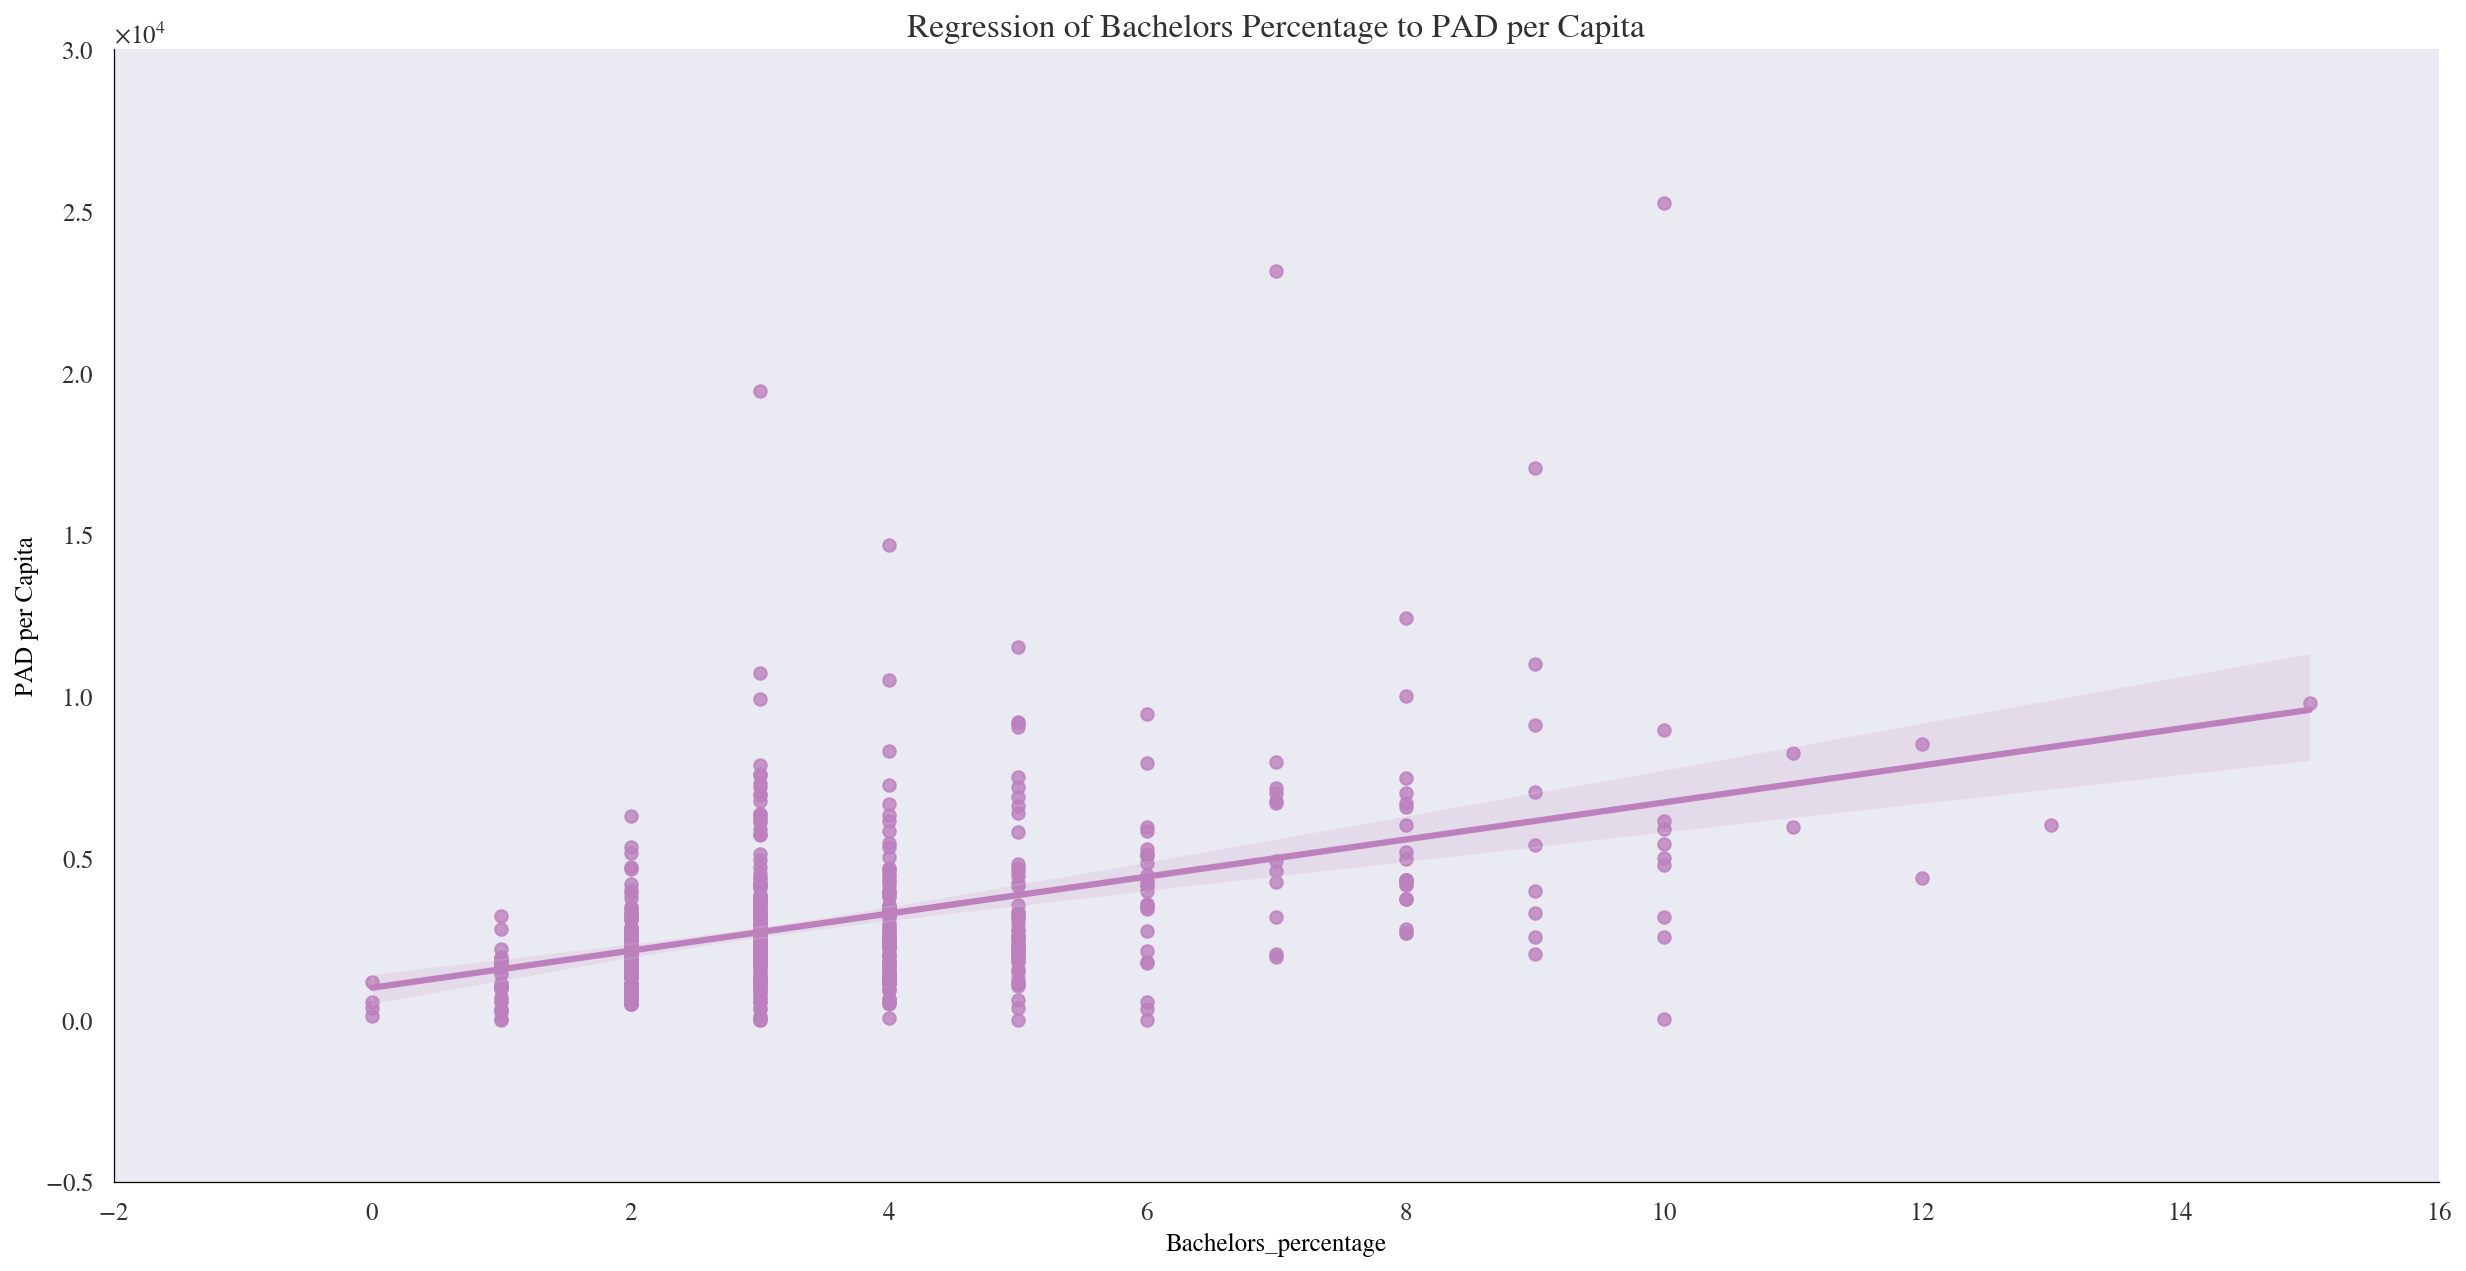

In [ ]:
ax = sns.regplot(x="Bachelors_percentage", y="PAD per Capita", data=df)
ax.set_title("Regression of Bachelors Percentage to PAD per Capita", loc="center")

Text(0.5, 1.0, 'Regression of Density Percentage to PAD per Capita')

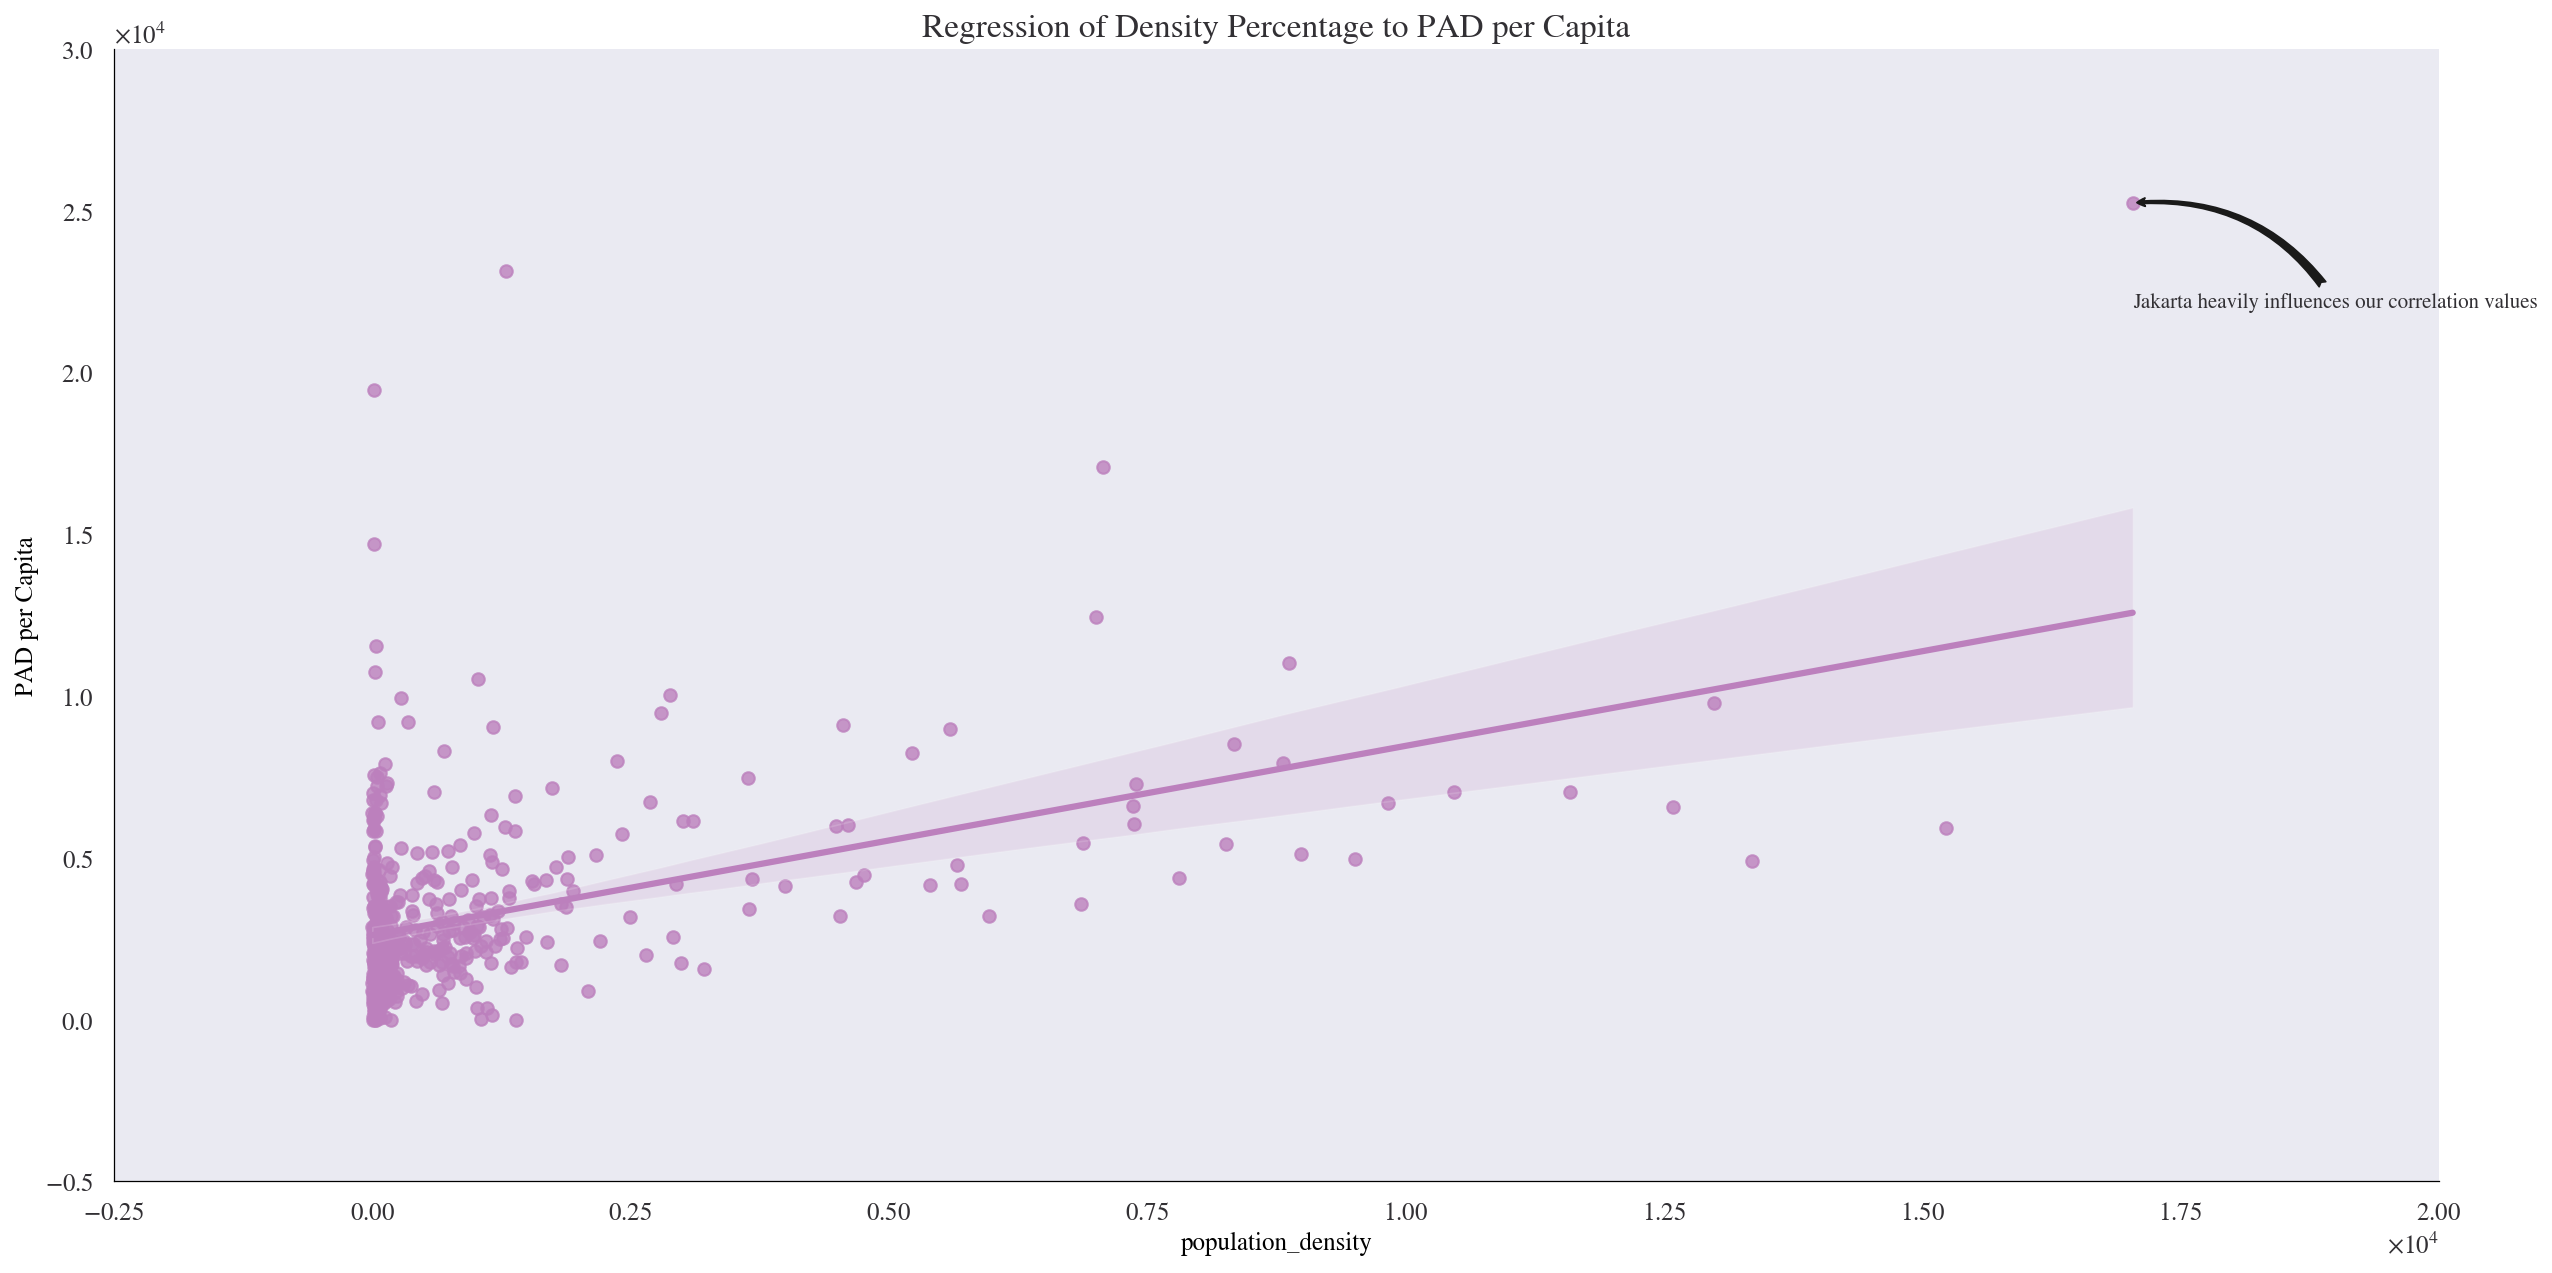

In [ ]:
ax = sns.regplot(x="population_density", y="PAD per Capita", data=df)
ax.annotate(
    "Jakarta heavily influences our correlation values",
    df.iloc[df["PAD per Capita"].idxmax()][["population_density", "PAD per Capita"]],  
    xytext=(0, -50),
    textcoords="offset points",
    arrowprops=dict(
        arrowstyle="fancy",
        color="k",
        connectionstyle="arc3,rad=0.3",
    ),
)
ax.set_title("Regression of Density Percentage to PAD per Capita", loc="center")

In [ ]:
#df[["Kepadatan Penduduk",'Kabupaten/Kota']].sort_values(by='Kepadatan Penduduk',ascending=False).head(1)

drop jakarta and see the difference


Text(0.5, 1.0, 'Regression of Bachelors Percentage to PAD per Capita (Jakarta dropped)')

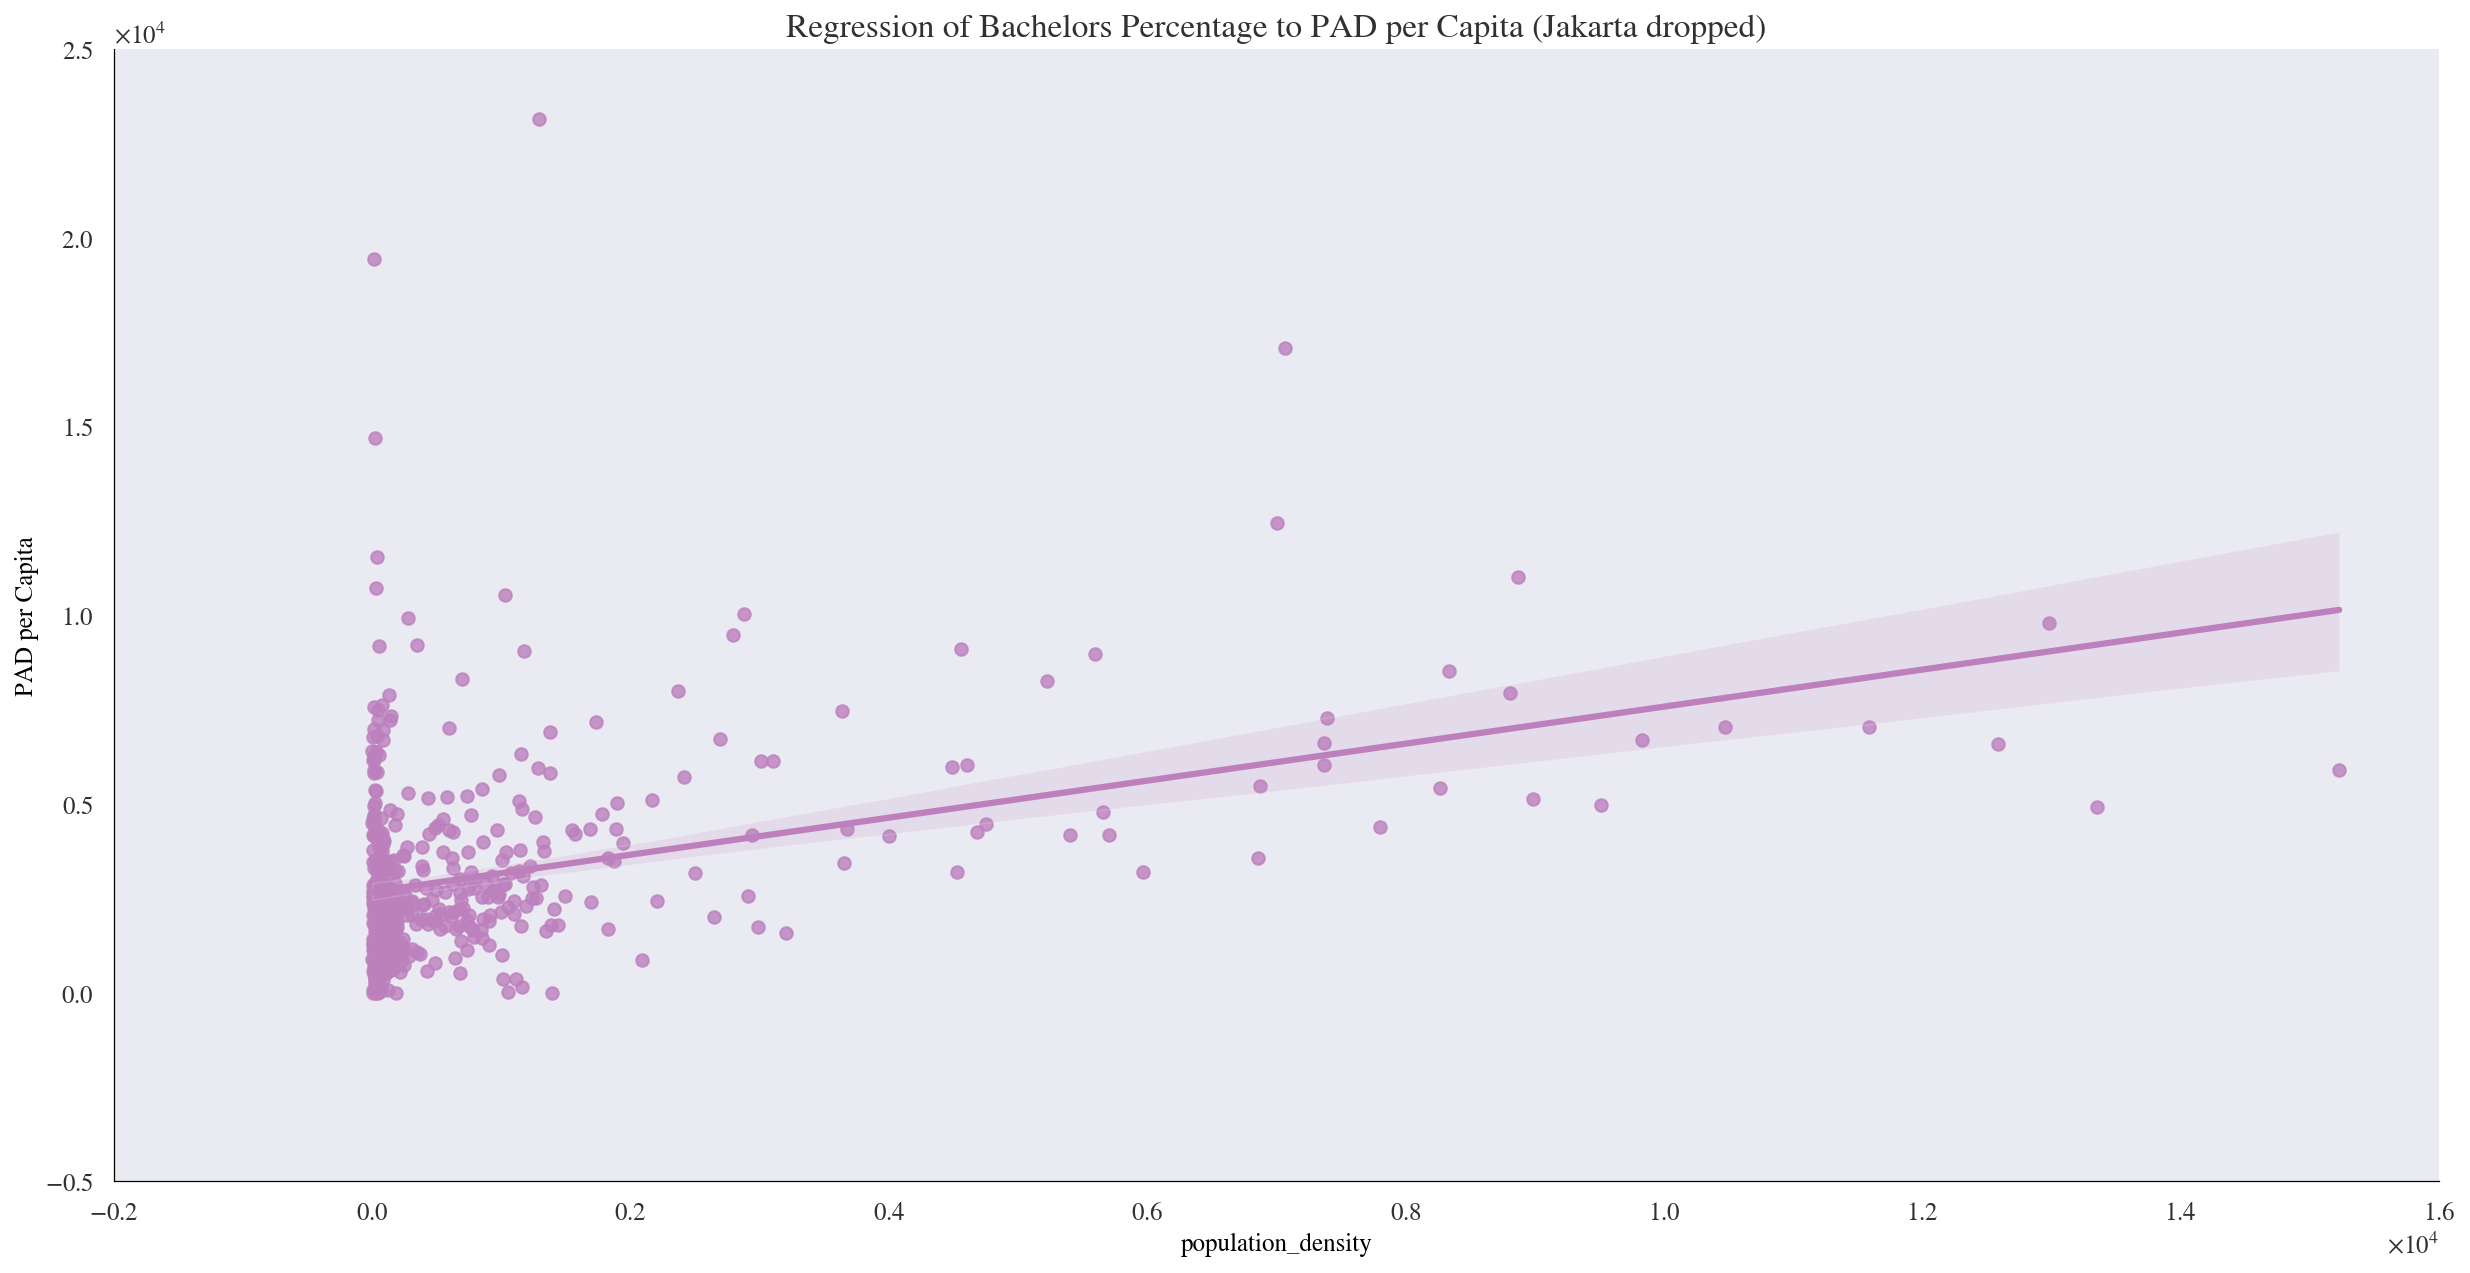

In [ ]:
#dropped_jakarta
df_no_jakarta = df.drop(df[df['Kabupaten/Kota'] == "DKI JAKARTA"].index)

ax = sns.regplot(x="population_density", y="PAD per Capita", data=df_no_jakarta)
ax.set_title("Regression of Bachelors Percentage to PAD per Capita (Jakarta dropped)", loc="center")

# Remove all outliers for population density


# viz for neg correlation

# Geospatial analysis

# Mutual information

When dealing with data with a large amount of features it is beneficial identify which are the potentially key features. To do so, we calculate the mutual information scores. What is measures is how much information is lost to predict/classify our target variable when a feature is removed. There are advantages of using mutual information over pearson correlation as it is not limited to identifying just linear relationships.

In [ ]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [ ]:
# mutual information
X = df.copy()
X = X.drop(columns=['Kabupaten/Kota'],axis=1)
y = X.pop('PAD per Capita')

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int


In [ ]:
mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

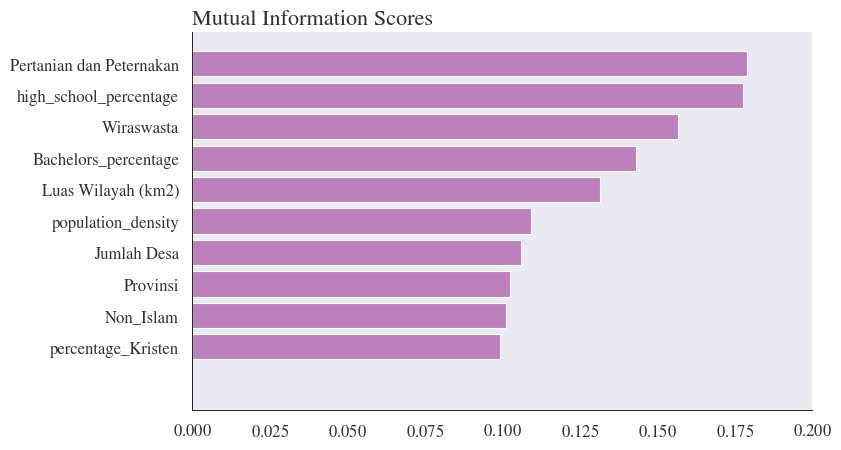

In [ ]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(10))

# grouping our cities/countries

It might very difficult and not relevant to predict the exact income of our cities. Instead we can group them by their percentiles and classify them from low income to very high income

In [ ]:
income_df = df[['PAD per Capita','Kabupaten/Kota']]
descriptive_table(income_df) # we use this are our reference to group

count    mean     std  min     25%     50%     75%      max
PAD per Capita  507.0  3171.7  2752.9  0.0  1550.1  2439.5  4048.0  25239.9

In [ ]:
income_conditions = [
    (df['PAD per Capita'] < 1550.1),
    (df['PAD per Capita'] >= 	1550.1) & (df['PAD per Capita'] < 2439.5),
    (df['PAD per Capita'] >= 2439.5) & (df['PAD per Capita'] < 4048.0 + 2752.9), # percentile + Stdev
    (df['PAD per Capita'] >= 4048.0 + 2752.9)
]
income_categories = ['low', 'medium', 'high','very high']
df['income_categories'] = np.select(income_conditions, income_categories)

In [ ]:
df[['Kabupaten/Kota','PAD per Capita','income_categories']].tail(10)

Kabupaten/Kota  PAD per Capita income_categories
497  POLEWALI MANDAR     3645.251563              high
498           MAMASA      378.180931               low
499       PASANGKAYU     1459.136268               low
500    MAMUJU TENGAH     1662.012546            medium
501         BULUNGAN     5820.992719              high
502          MALINAU     4497.088801              high
503          NUNUKAN     6168.092768              high
504     KOTA TARAKAN     4304.448661              high
505      TANA TIDUNG     4596.951864              high
506      DKI JAKARTA    25239.854568         very high

In [ ]:
df['income_categories'].value_counts()

high         214
low          127
medium       126
very high     40
Name: income_categories, dtype: int64

# Re-run mutual Information (After we categorized)

In [ ]:
X = df.copy()
X = X.drop(columns=['Kabupaten/Kota','PAD per Capita'],axis=1)
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()
y = X.pop('income_categories')
discrete_features = X.dtypes == int

In [ ]:
mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

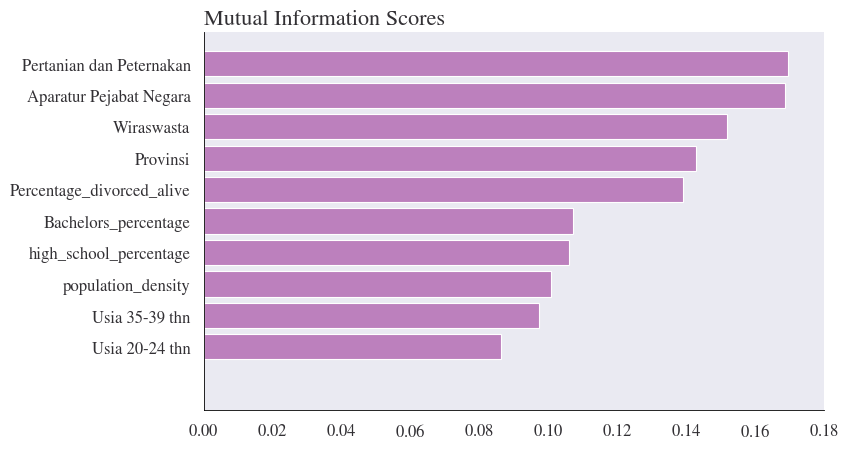

In [ ]:
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(10))

In [ ]:
# spatial analysis

# Feature engineering

We saw that from our mutual information score and spatial analysis. There is correlation between income of a regency/city and its surrounding. To make its simple lets get the median income for cities in each province

In [ ]:
# get average marketcap per year
df["Median_income_province"] = (
    df.groupby("Provinsi")
    ["PAD per Capita"]
    .transform("median")
) 

df[["Kabupaten/Kota", "Provinsi", "Median_income_province","PAD per Capita"]].head(5)

Kabupaten/Kota Provinsi  Median_income_province  PAD per Capita
0            PIDIE     ACEH             3502.447078     3495.361372
1         SIMEULUE     ACEH             3502.447078     9186.715836
2  KOTA BANDA ACEH     ACEH             3502.447078     6026.856452
3      KOTA SABANG     ACEH             3502.447078     9202.360877
4      KOTA LANGSA     ACEH             3502.447078     3994.683484

Text(0.5, 1.0, 'Regression of Median Province Income and PAD per Capta')

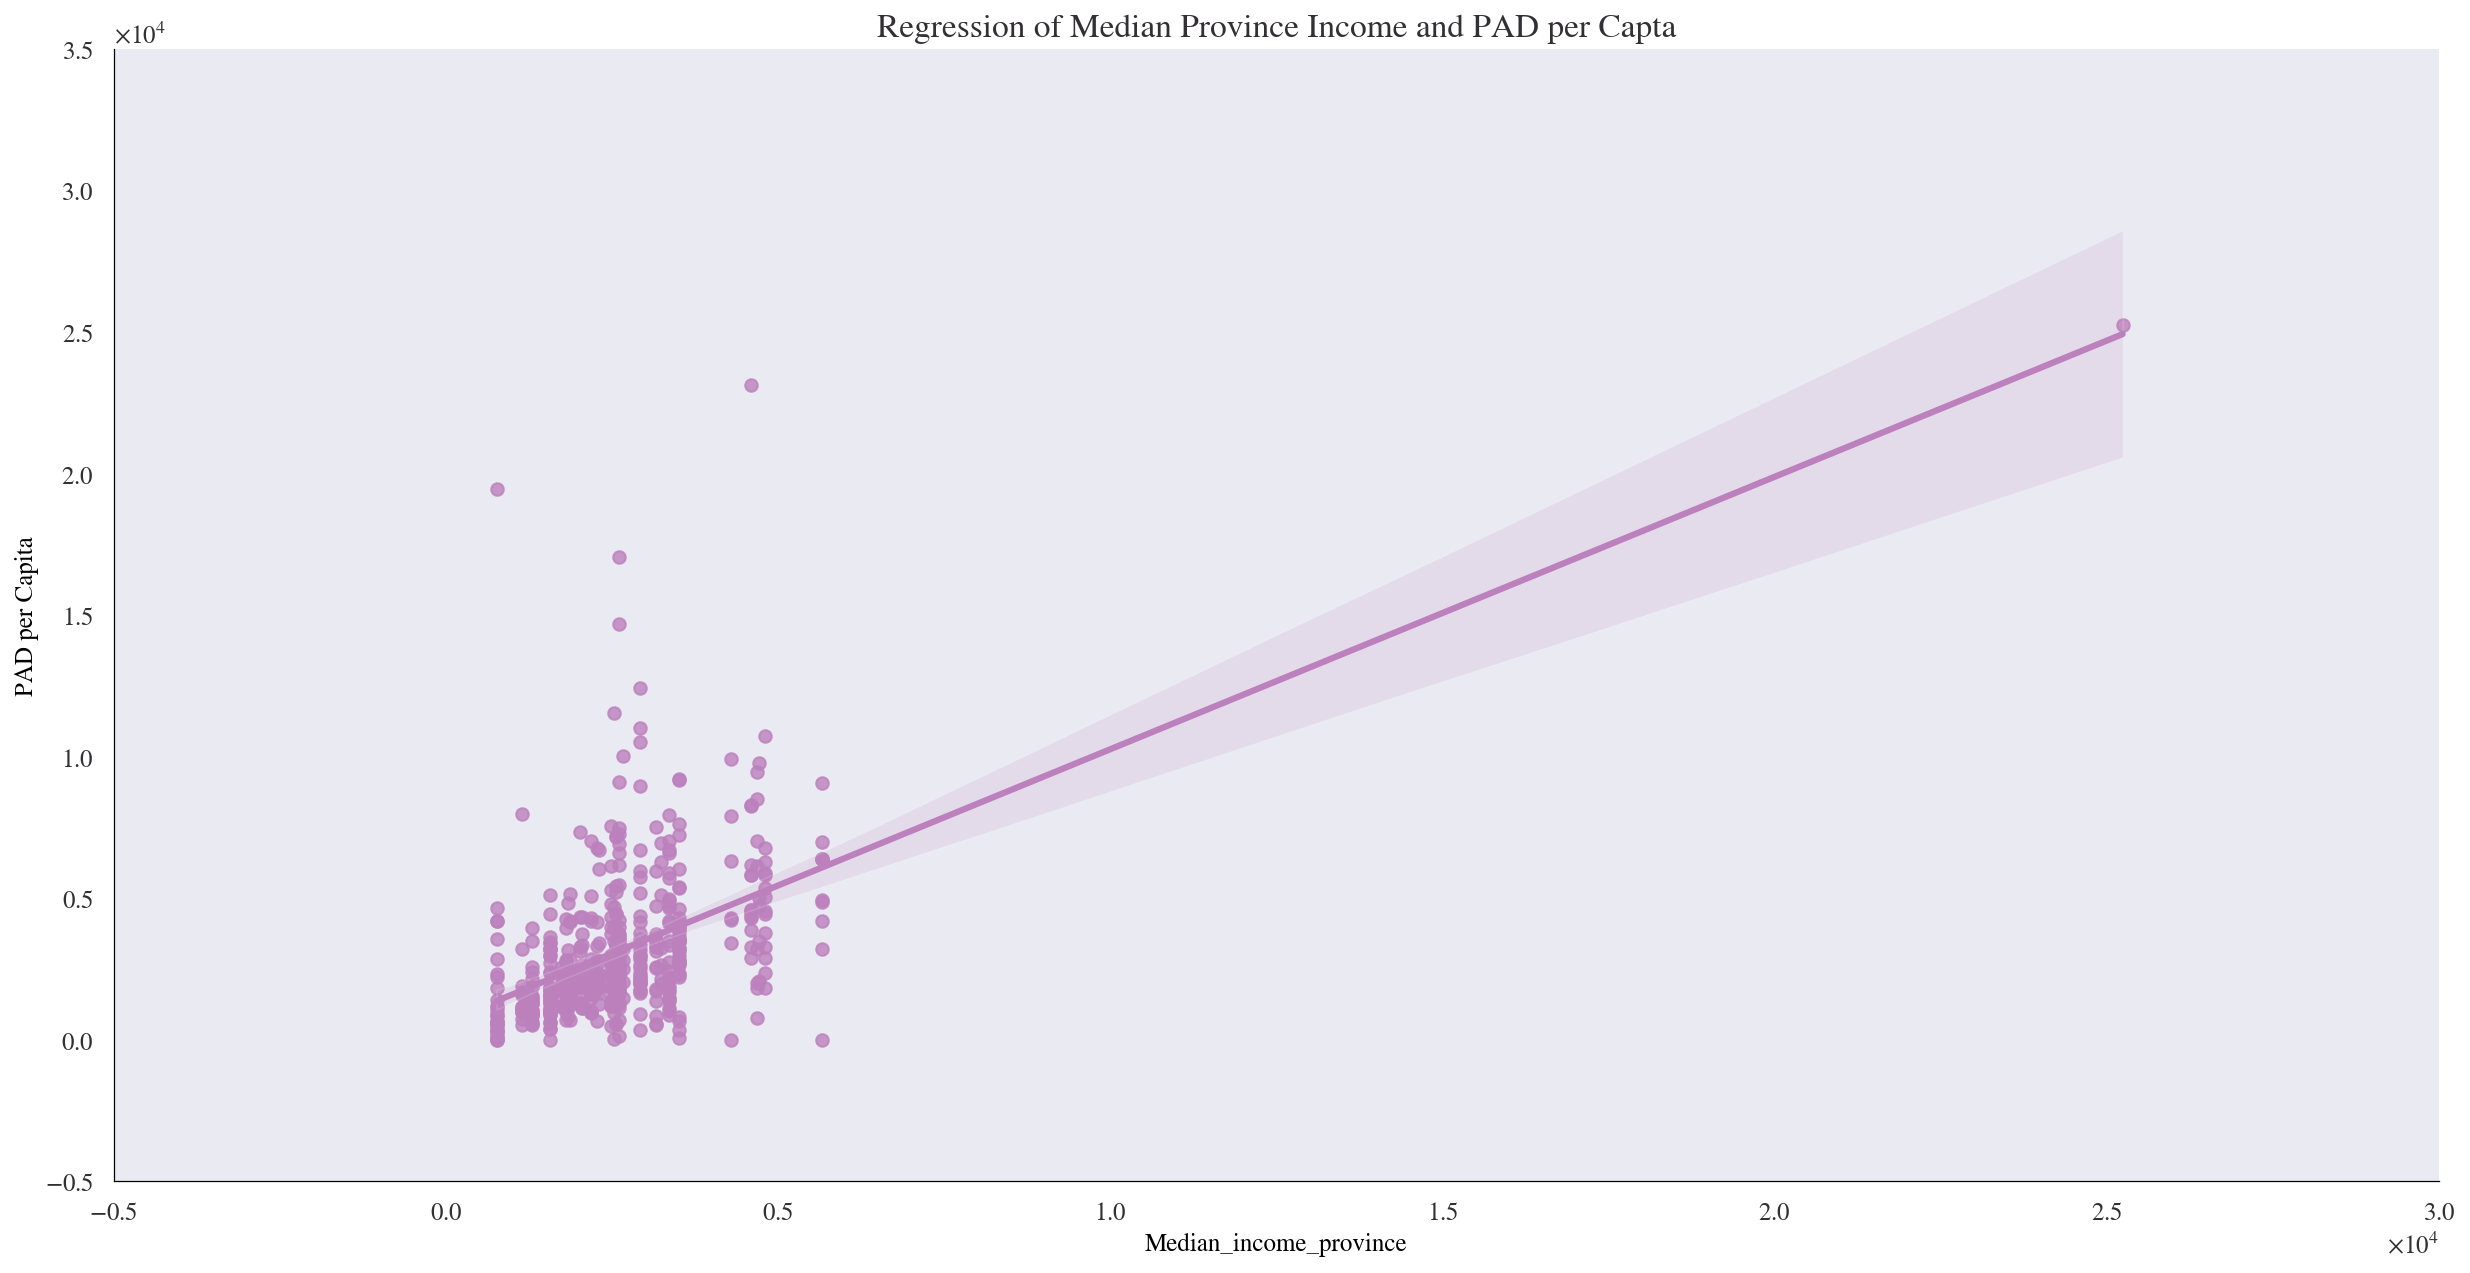

In [ ]:
ax = sns.regplot(data=df, x="Median_income_province", y="PAD per Capita")
ax.set_title("Regression of Median Province Income and PAD per Capta", loc="center")

In [ ]:
df.head()

Provinsi   Kabupaten/Kota  Jumlah Kecamatan  Jumlah Desa  Jumlah Kelurahan  \
0     ACEH            PIDIE                23          730                 0   
1     ACEH         SIMEULUE                10          138                 0   
2     ACEH  KOTA BANDA ACEH                 9           90                 0   
3     ACEH      KOTA SABANG                 3           18                 0   
4     ACEH      KOTA LANGSA                 5           66                 0   

   Jumlah Penduduk  Jumlah KK  Luas Wilayah (km2)  Perpindahan Penduduk  \
0           435797     132522                3133                220656   
1            94368      25611                1821                 45990   
2           253198      74245                  55                126525   
3            42696      12850                 122                 21161   
4           185836      53727                 217                 92425   

   Jumlah Meninggal  Perubahan Data  Wajib KTP  Laki-Laki  Perempuan  \
0               828          415357     310044     215141     220656   
1               282           85629      66453      48378      45990   
2               939          231423     171676     126673     126525   
3               175           40653      29413      21535      21161   
4               441          165304     134356      93411      92425   

   Usia 0-4 thn  Usia 5-9 thn  Usia 10-14 thn  Usia 15-19 thn  Usia 20-24 thn  \
0             9             9               9               8               8   
1             8             9               9              10               9   
2            10            10              10               6               6   
3            10            10               9               8               7   
4             8             8               9               8               8   

   Usia 25-29 thn  Usia 30-34 thn  Usia 35-39 thn  Usia 40-44 thn  \
0               8               8               7               6   
1               7               7               7               7   
2               8               9               9               7   
3               7               8               8               7   
4               7               8               8               7   

   Usia 45-49 thn  Usia 50-54 thn  Usia 55-59 thn  Usia 60-64 thn  \
0               5               4               3               3   
1               5               4               3               2   
2               6               4               3               2   
3               6               4               3               2   
4               6               5               4               3   

   Usia 65-69 thn  Usia 70-74 thn  Usia 75 thn ke Atas  Lahir thn 2018  \
0               2               1                    2            8079   
1               1               1                    1            1730   
2               1               0                    1            5294   
3               2               1                    1             848   
4               2               1                    1            3164   

   Lahir sebelum thn 2018  Pertumbuhan penduduk thn 2016 (%)  \
0                  408225                                  2   
1                   88807                                  2   
2                  234368                                  2   
3                   39601                                  2   
4                  174490                                  2   

   Pertumbuhan penduduk thn 2017 (%)  Pertumbuhan penduduk thn 2018 (%)  \
0                                  2                                  2   
1                                  2                                  2   
2                                  2                                  2   
3                                  2                                  2   
4                                  2                                  2   

   Pertumbuhan penduduk thn 2019 (%)  P

## Dealing with categorical data

In our Province column, we are dealing with categorical data. Our model cannot interpret words/strings. There are several ways to deal with this. In this situation we will be using dummy variables to represent the different provinces. 

Essentially, what this does is we create an individual column for each province and encode it with a 1 if our sample is in a Province and 0 otherwise.

In [ ]:
df = pd.get_dummies(df, columns=["Provinsi"])

In [ ]:
df.head()

Kabupaten/Kota  Jumlah Kecamatan  Jumlah Desa  Jumlah Kelurahan  \
0            PIDIE                23          730                 0   
1         SIMEULUE                10          138                 0   
2  KOTA BANDA ACEH                 9           90                 0   
3      KOTA SABANG                 3           18                 0   
4      KOTA LANGSA                 5           66                 0   

   Jumlah Penduduk  Jumlah KK  Luas Wilayah (km2)  Perpindahan Penduduk  \
0           435797     132522                3133                220656   
1            94368      25611                1821                 45990   
2           253198      74245                  55                126525   
3            42696      12850                 122                 21161   
4           185836      53727                 217                 92425   

   Jumlah Meninggal  Perubahan Data  Wajib KTP  Laki-Laki  Perempuan  \
0               828          415357     310044     215141     220656   
1               282           85629      66453      48378      45990   
2               939          231423     171676     126673     126525   
3               175           40653      29413      21535      21161   
4               441          165304     134356      93411      92425   

   Usia 0-4 thn  Usia 5-9 thn  Usia 10-14 thn  Usia 15-19 thn  Usia 20-24 thn  \
0             9             9               9               8               8   
1             8             9               9              10               9   
2            10            10              10               6               6   
3            10            10               9               8               7   
4             8             8               9               8               8   

   Usia 25-29 thn  Usia 30-34 thn  Usia 35-39 thn  Usia 40-44 thn  \
0               8               8               7               6   
1               7               7               7               7   
2               8               9               9               7   
3               7               8               8               7   
4               7               8               8               7   

   Usia 45-49 thn  Usia 50-54 thn  Usia 55-59 thn  Usia 60-64 thn  \
0               5               4               3               3   
1               5               4               3               2   
2               6               4               3               2   
3               6               4               3               2   
4               6               5               4               3   

   Usia 65-69 thn  Usia 70-74 thn  Usia 75 thn ke Atas  Lahir thn 2018  \
0               2               1                    2            8079   
1               1               1                    1            1730   
2               1               0                    1            5294   
3               2               1                    1             848   
4               2               1                    1            3164   

   Lahir sebelum thn 2018  Pertumbuhan penduduk thn 2016 (%)  \
0                  408225                                  2   
1                   88807                                  2   
2                  234368                                  2   
3                   39601                                  2   
4                  174490                                  2   

   Pertumbuhan penduduk thn 2017 (%)  Pertumbuhan penduduk thn 2018 (%)  \
0                                  2                                  2   
1                                  2                                  2   
2                                  2                                  2   
3                                  2                                  2   
4                                  2                                  2   

   Pertumbuhan penduduk thn 2019 (%)  Pertumbuhan penduduk thn 2020 (%)  \
0                   

# Data modeling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

y = df[['income_categories']]
#X = X.loc[:,~X.columns.duplicated()] # certain cols were duplicates
X = df.copy()
X = X.drop(columns=['Kabupaten/Kota','PAD per Capita','income_categories'],axis=1)
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1,shuffle=True)

In [ ]:
my_model = RandomForestClassifier(n_estimators=8000,
                                 random_state=23).fit(train_X, train_y.values.ravel())
y_pred = my_model.predict(val_X)
print("Accuracy:",metrics.accuracy_score(val_y, y_pred))

Accuracy: 0.5984251968503937


# Xgboost

In [ ]:
xgb_model = xgb.XGBClassifier(objective='multi:softmax', n_estimators=50,
                              learning_rate=0.07,max_depth=5,gamma=5,colsample_bytree=0.7) # parameters were found using grid search.  Refer to method below

xgb_model.fit(train_X, train_y.values.ravel())
y_pred = xgb_model.predict(val_X)
print("Accuracy:",metrics.accuracy_score(val_y, y_pred))

Accuracy: 0.5826771653543307


# Improving model performance
As mentioned before, removing features may actually improve our model performance. This all falls under dimensionality reduction. High dimension data is when there are alot of independent variables in comparision to our number of data points
## Dimensionality reduction
1. Removing features with multicolinearity 
2. Recursive elimination 
3. PCA

## Grid search ( Hyperparameter tuning)

In [ ]:
# gbm_param_grid = {
#     'learning_rate' : [0.1],
#     'colsample_bytree': [0.8,0.7,0.9],
#     'n_estimators': [60,75,77],
#     'max_depth': [7,10,12],
#     'gamma' : [0.1,0.05],
#     'objective': ['multi:softmax']
# } 

# xgb_model = xgb.XGBClassifier()
# grid_acc = GridSearchCV(estimator=xgb_model,param_grid=gbm_param_grid, cv=2, verbose=1)
# grid_acc.fit(X,y.values.ravel())

# print("Best parameters found: ", grid_acc.best_params_)
# print( "best score : ",grid_acc.best_score_)

# Evaluating model performance

In [ ]:
class_rep = classification_report(val_y,y_pred,output_dict=True)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


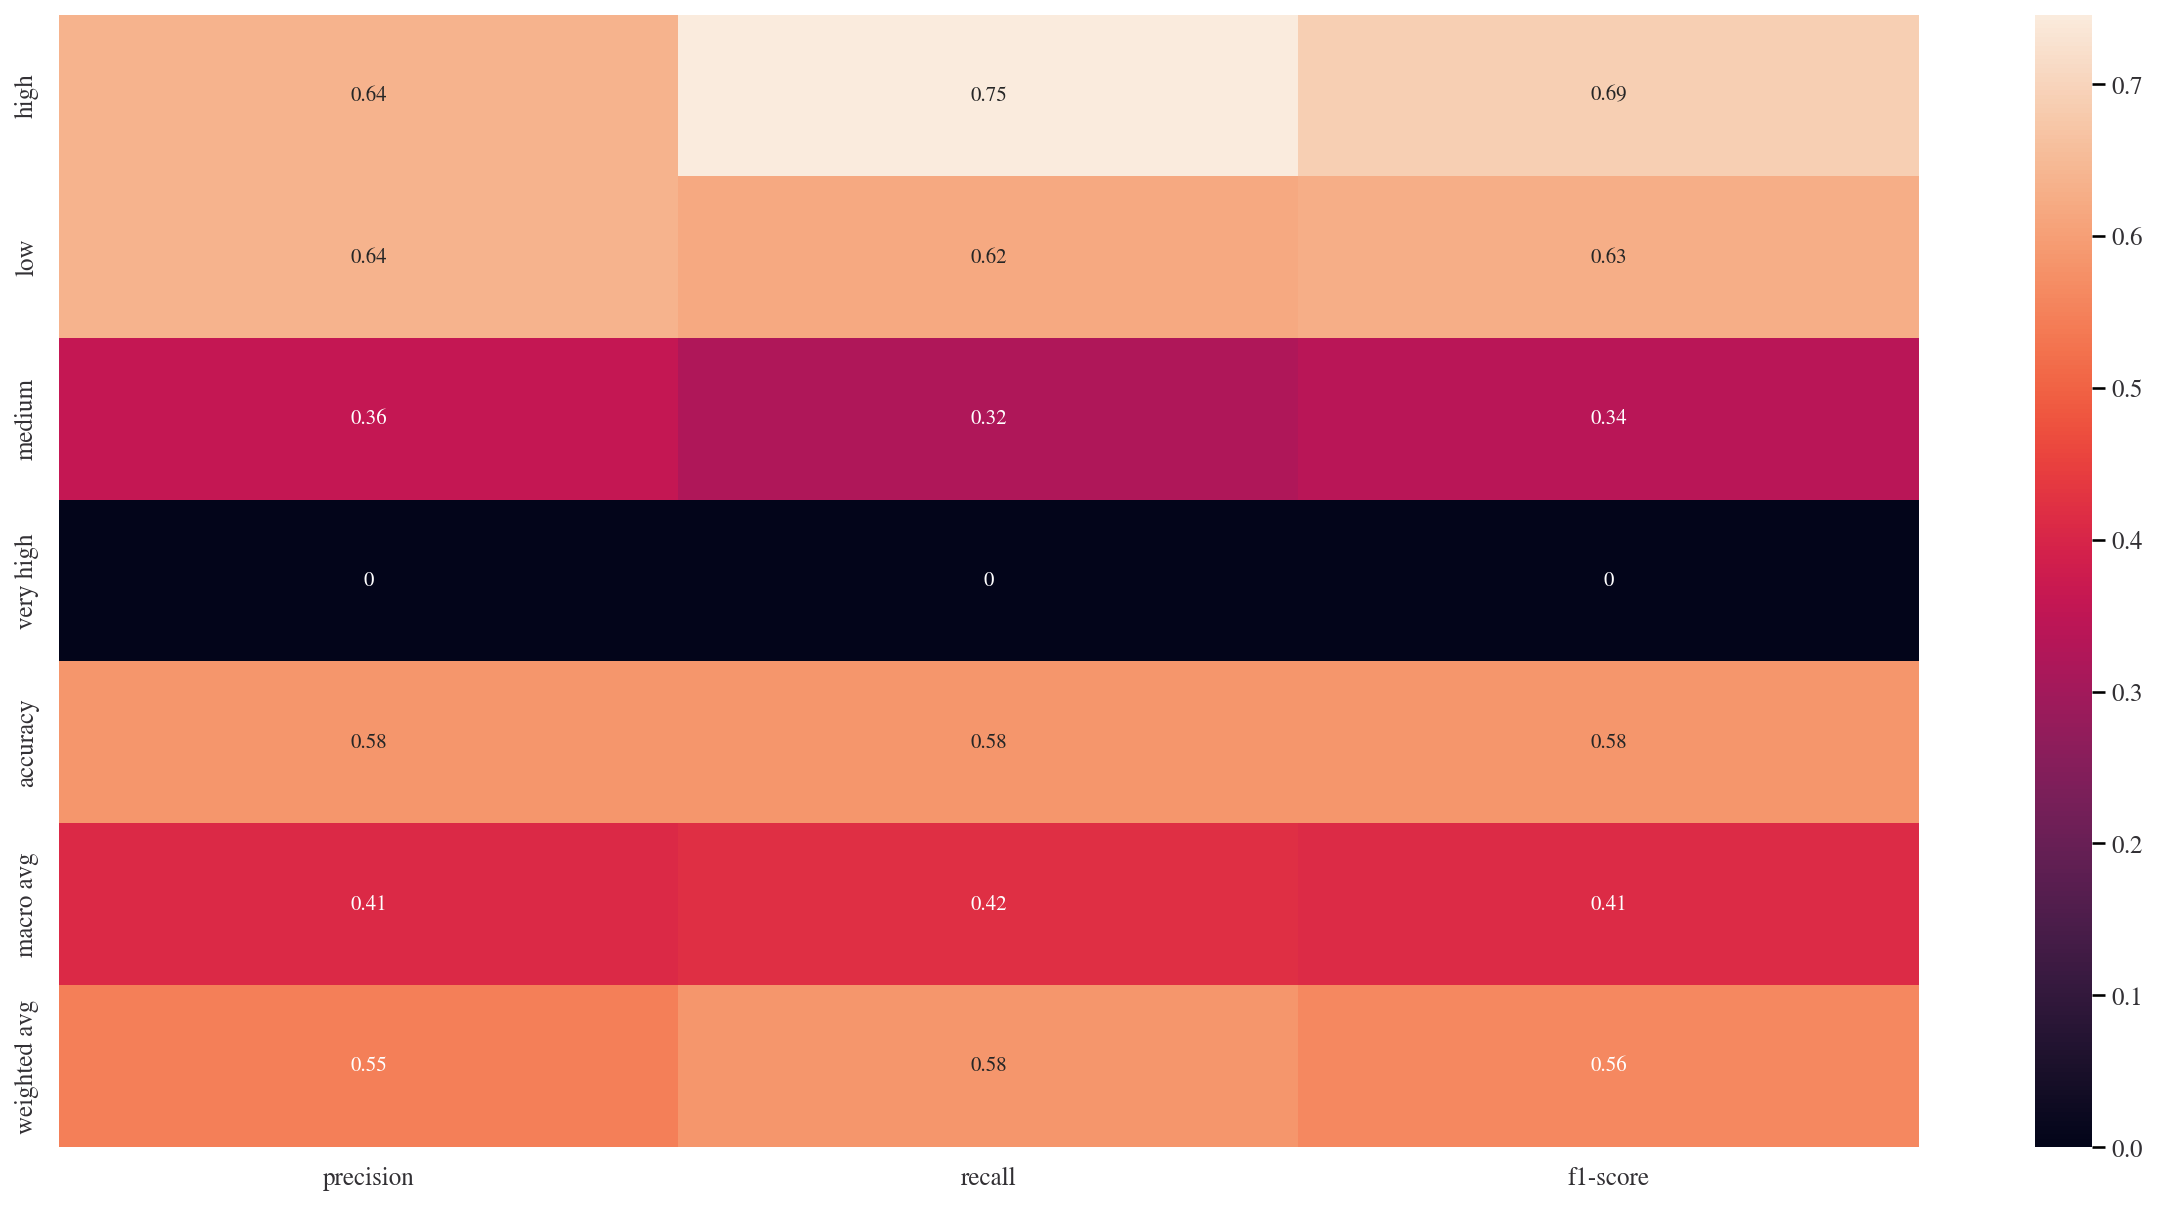

In [ ]:
sns.heatmap(pd.DataFrame(class_rep).iloc[:-1, :].T, annot=True)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


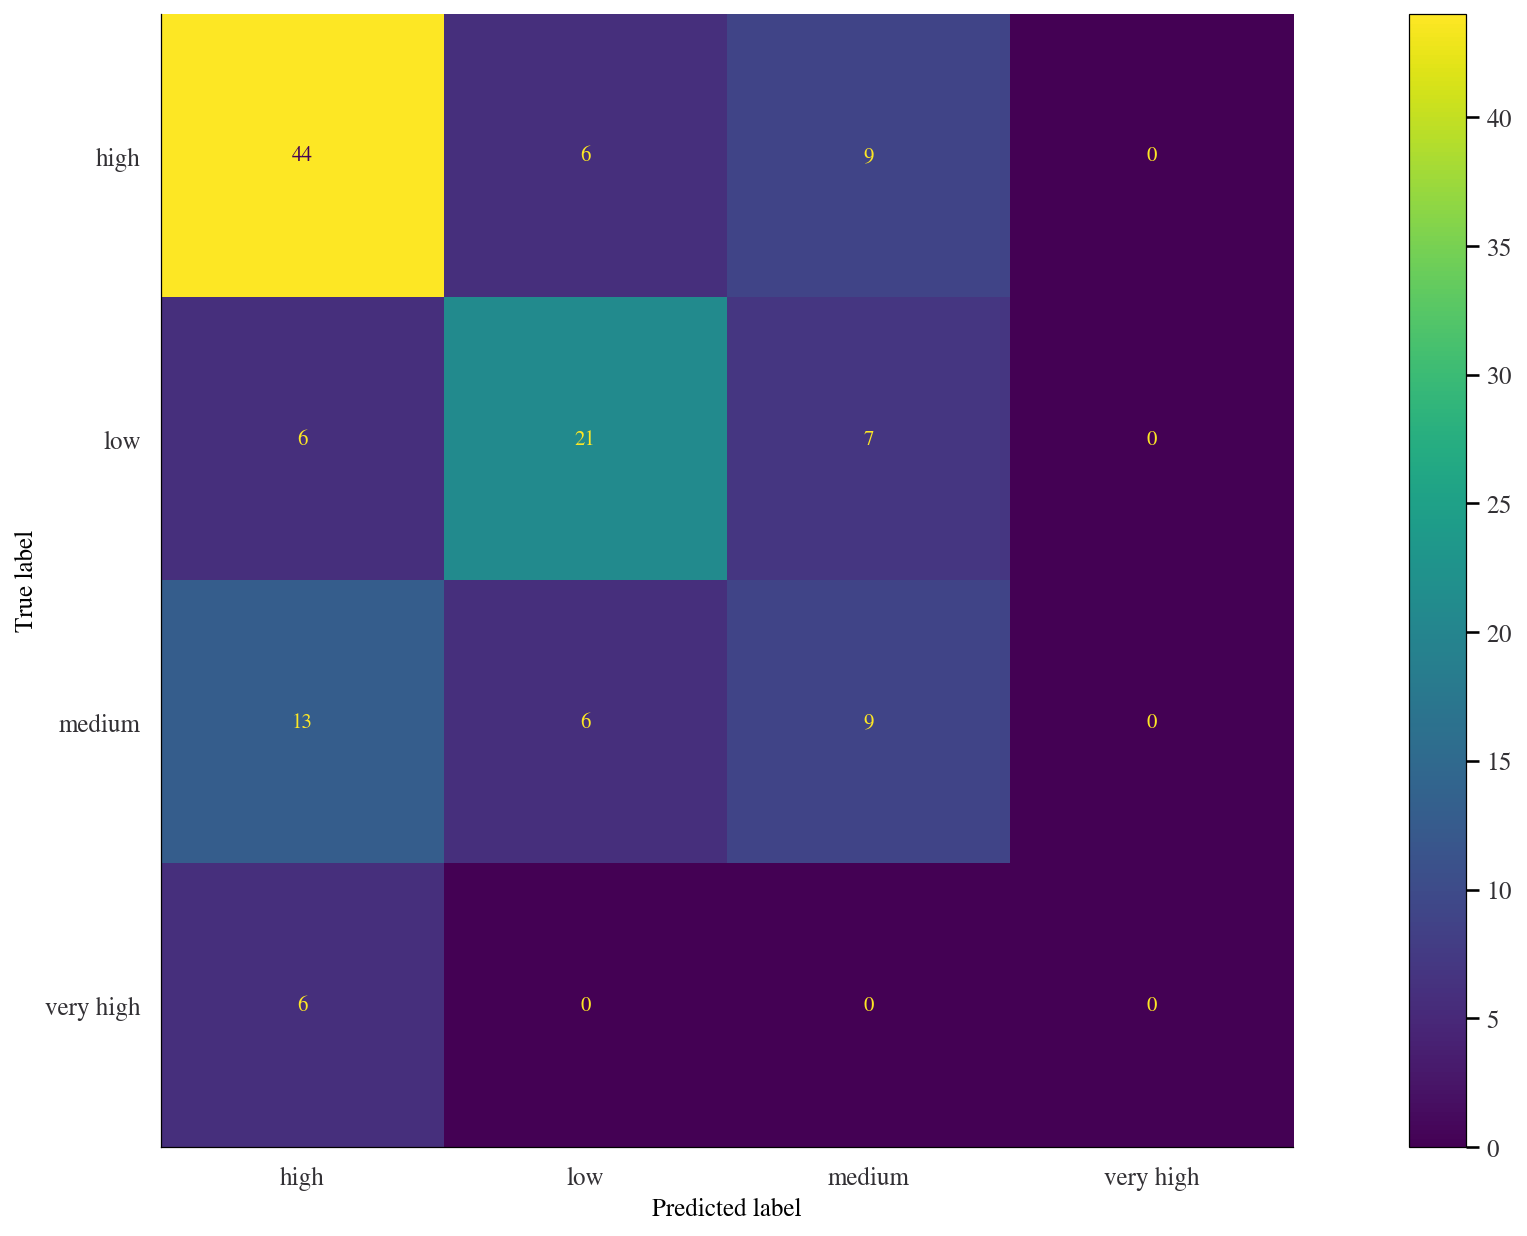

In [ ]:
plot_confusion_matrix(xgb_model, val_X, val_y) 
plt.rcParams["figure.figsize"] = (10, 6)
plt.show()

# Xgboost feature importance

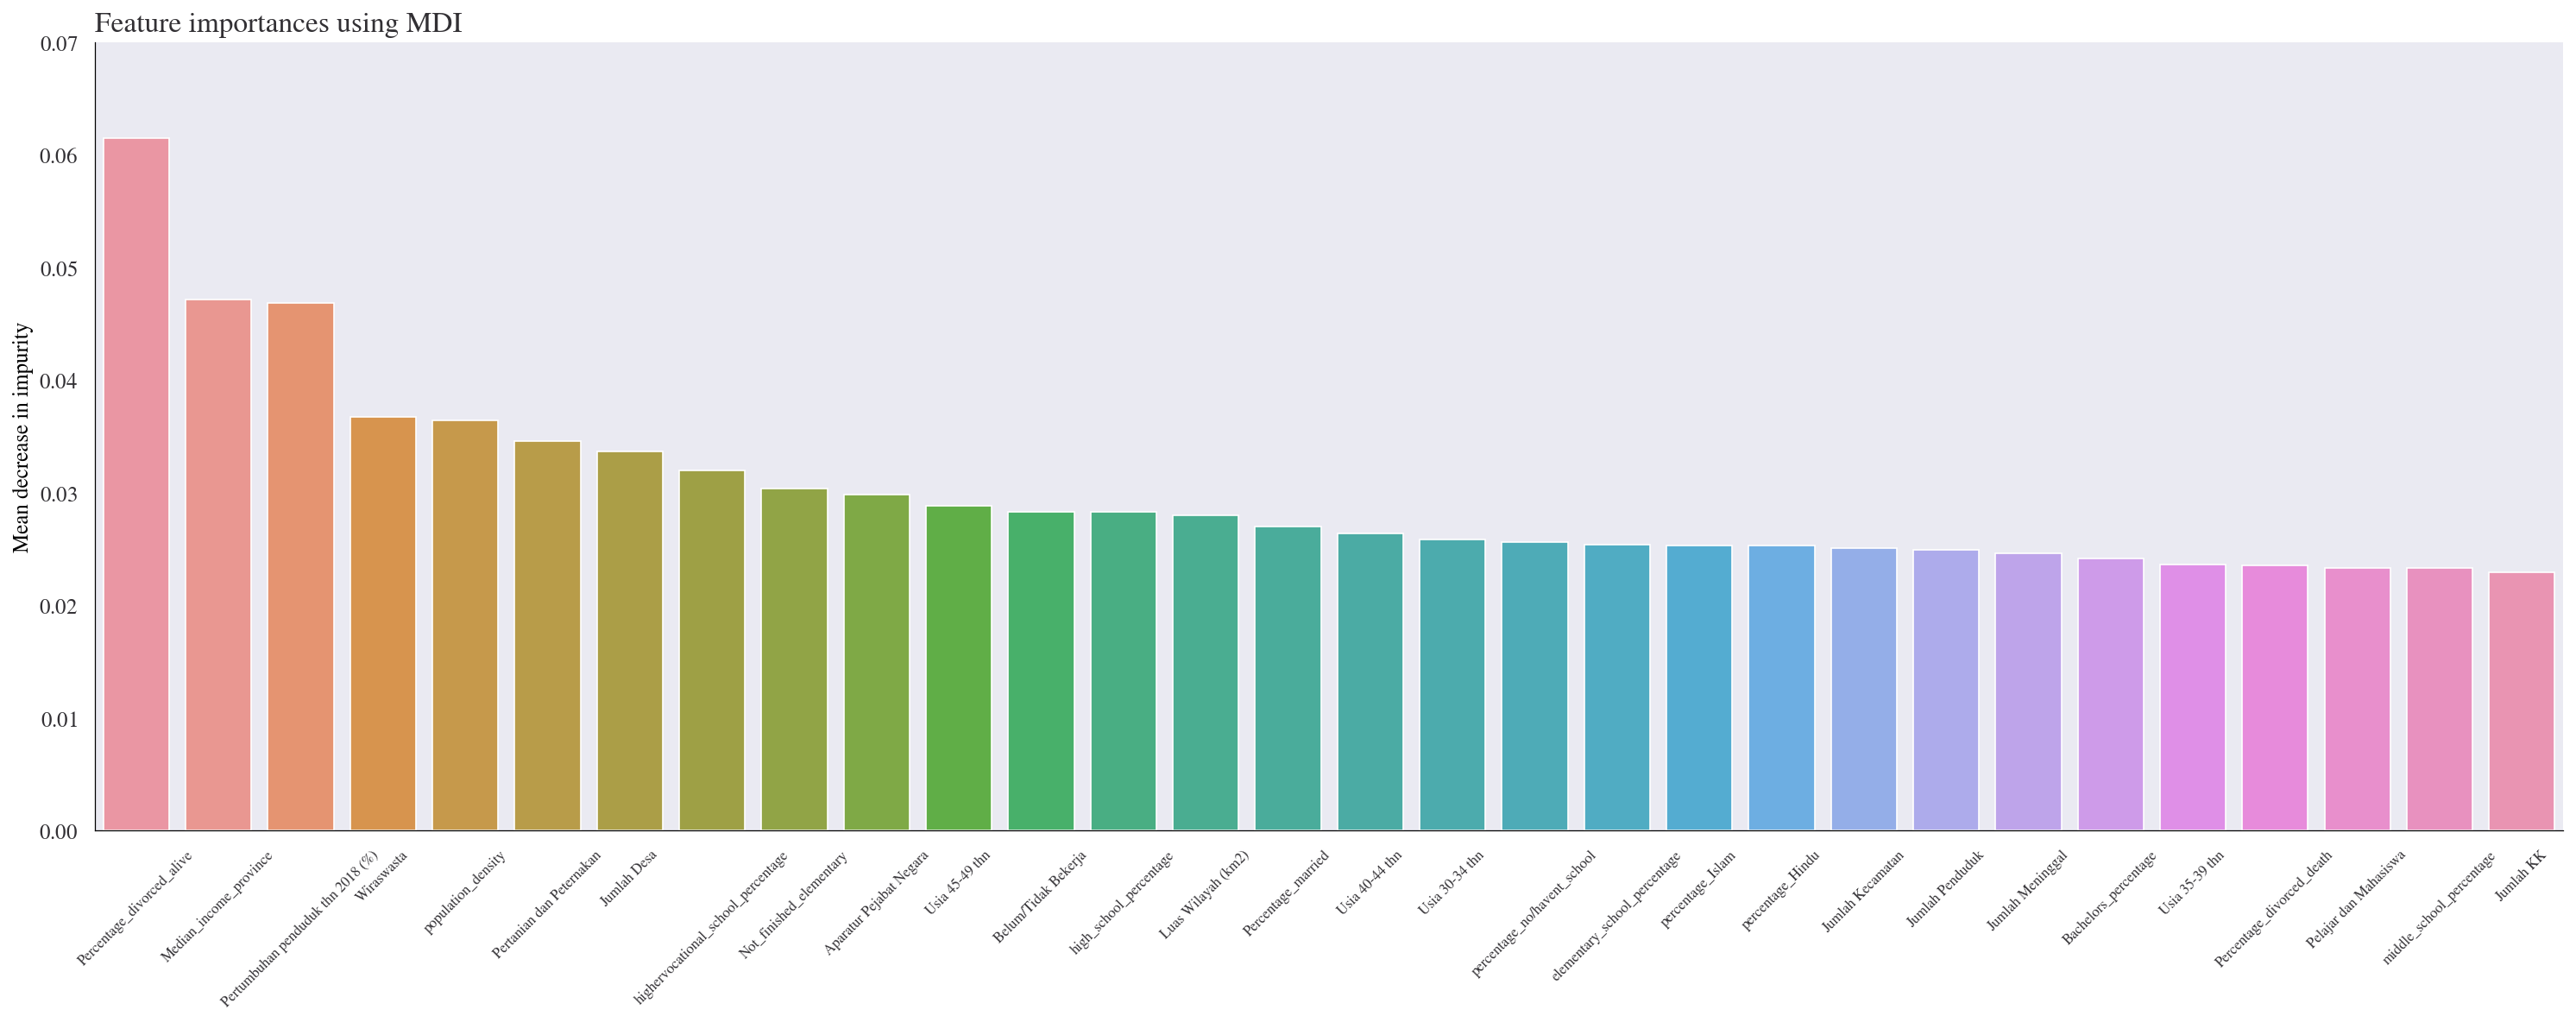

In [ ]:
feature_names = X.columns
importances = xgb_model.feature_importances_
#std = np.std([tree.feature_importances_ for tree in xgb_model.estimators_], axis=0)


forest_importances = pd.Series(importances, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False).head(30)

fig, ax = plt.subplots()
#forest_importances.plot.bar(ax=ax)
ax = sns.barplot(x=forest_importances.index, y=forest_importances.values)
plt.xticks(rotation=45,fontsize=8)
plt.gcf().set_size_inches(20,8)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

# How our model decides cities with high income

how our model decides to classify a token with very high market cap
Shap is a library used to explain ML models. It uses a game theory approach to see which features are most important and how each feature impacts our model.

The y-axis is the features names and are arranged based on feature importance. Our x-axis shows how a value of that feature impacts the output of our model. The color of the data point indicates the range value of a particulars samples feature.

In this plot we see how a model classifies a coin to be very high.

In [ ]:
class_labels = ['high','low','medium','very high']

In [ ]:
import shap
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)
shap.initjs()

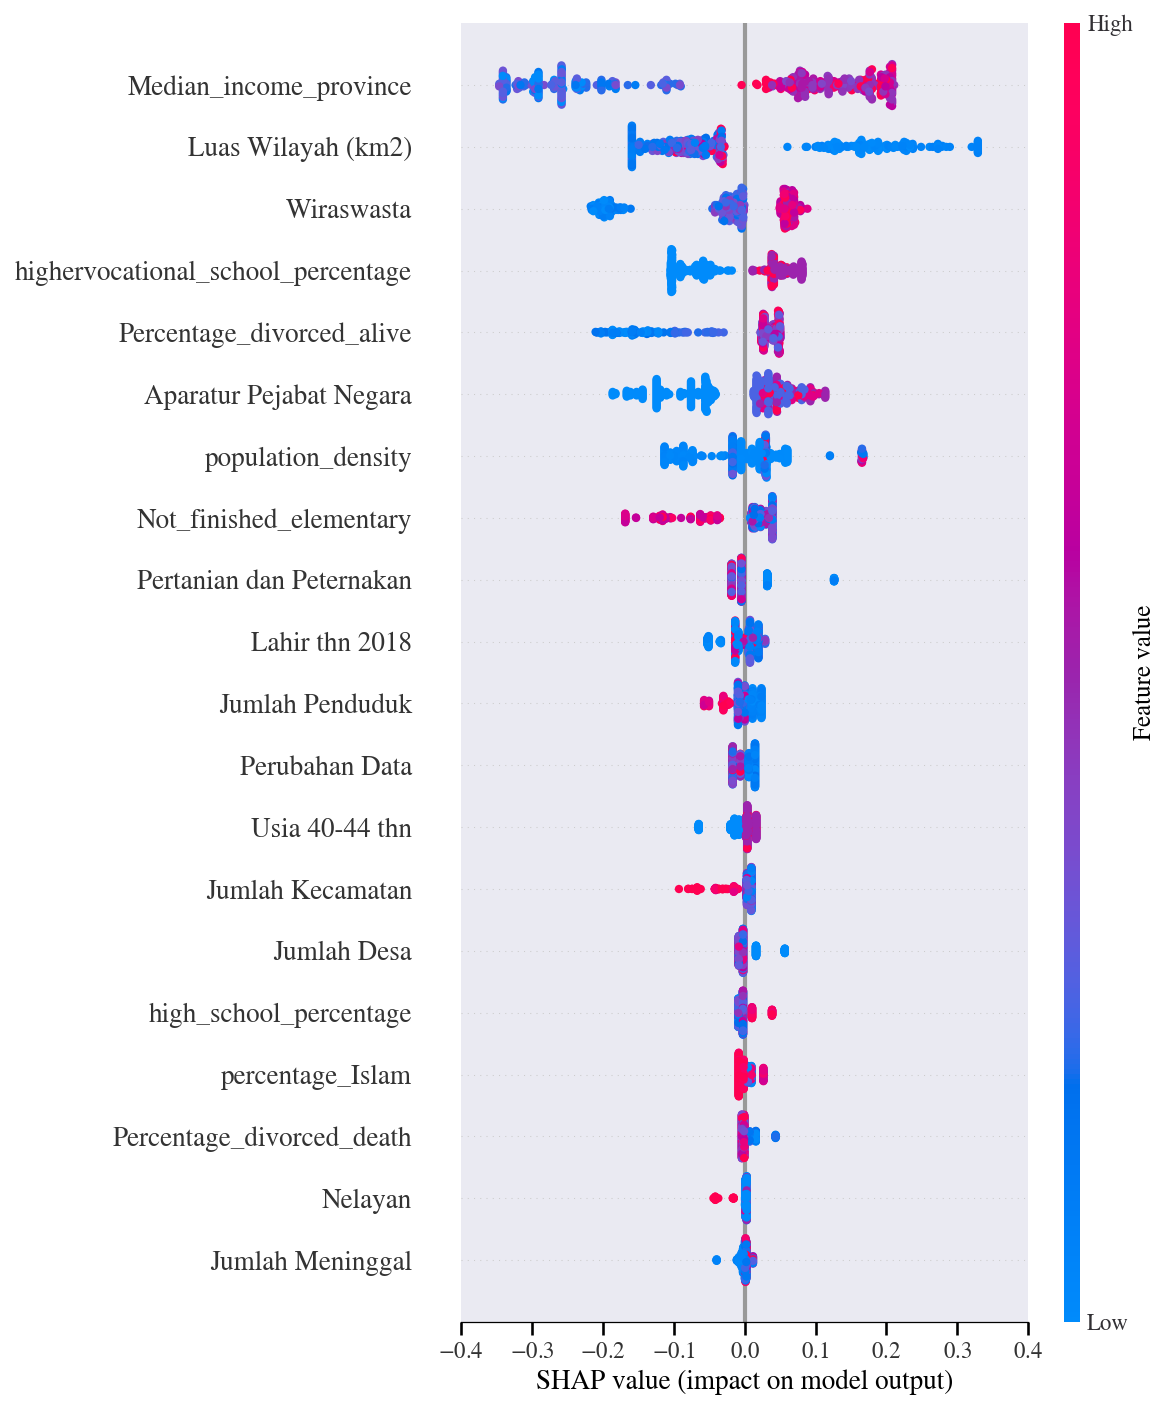

In [ ]:
shap.summary_plot(shap_values[0], X.values, feature_names = X.columns)

In [ ]:
#remove outliers